In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [82]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, f1_score,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report,accuracy_score, precision_score, make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import XGBRegressor

from catboost import CatBoostClassifier
import lightgbm as lgb

In [3]:
raw_data = pd.read_csv('Train.csv')
tenuremap = {
    'K > 24 month': 24,
    'I 18-21 month': 18,
    'H 15-18 month': 15,
    'G 12-15 month': 12,
    'J 21-24 month': 21,
    'F 9-12 month': 9,
    'E 6-9 month': 6,
    'D 3-6 month': 3,
}
raw_data['tenure'] = raw_data['tenure'].map(tenuremap)
train_ids = raw_data['ID'].unique()
raw_data.set_index('ID',inplace=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1507834 entries, ID_YEB05X4KUGPQ to ID_T7DN0N7KLS2R
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   region            913743 non-null   object 
 1   tenure            1507834 non-null  int64  
 2   Amount            978320 non-null   float64
 3   refill_frequency  978320 non-null   float64
 4   revenue           999713 non-null   float64
 5   arpu_segment      999713 non-null   float64
 6   frequency         999713 non-null   float64
 7   data_volume       766028 non-null   float64
 8   on_net            957192 non-null   float64
 9   Procuct_1         881271 non-null   float64
 10  Procuct_2         604784 non-null   float64
 11  zone1             118986 non-null   float64
 12  zone2             95505 non-null    float64
 13  mrg               1507834 non-null  object 
 14  regularity        1507834 non-null  int64  
 15  top_pack          876011 non-nul

In [4]:
raw_test = pd.read_csv('Test.csv')
raw_test['tenure'] = raw_test['tenure'].map(tenuremap)
test_ids = raw_test['ID'].unique()
raw_test.set_index('ID',inplace=True)
raw_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 380127 entries, ID_LZ8K373W7EWV to ID_2F6Y446GS8T3
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   region            230399 non-null  object 
 1   tenure            380127 non-null  int64  
 2   Amount            247072 non-null  float64
 3   refill_frequency  247072 non-null  float64
 4   revenue           252754 non-null  float64
 5   arpu_segment      252754 non-null  float64
 6   frequency         252754 non-null  float64
 7   data_volume       193087 non-null  float64
 8   on_net            241613 non-null  float64
 9   Procuct_1         222897 non-null  float64
 10  Procuct_2         153126 non-null  float64
 11  zone1             29861 non-null   float64
 12  zone2             24076 non-null   float64
 13  mrg               380127 non-null  object 
 14  regularity        380127 non-null  int64  
 15  top_pack          221348 non-null  object 
 16  fr

In [5]:
raw_df = pd.concat([raw_data,raw_test],axis=0)
raw_df

region  tenure   Amount  refill_frequency  revenue  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN      24      NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.96              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.23              22.0  5769.23   
ID_QS4F5LEX29KM        NaN      24      NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.88              58.0  5636.75   
...                    ...     ...      ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.50              19.0  4487.18   
ID_XGDT520DFBLP        NaN      24  6901.71              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24      NaN               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.69               9.0  2264.53   
ID_2F6Y446GS8T3        NaN      24      NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  \
ID                                                                         
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0   
...                       ...        ...          ...     ...        ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN   

                 Procuct_2  zone1  zone2 mrg  regularity  \
ID                                                         
ID_YEB05X4KUGPQ        NaN    NaN    NaN  NO           3   
ID_Z9IQ9QH52KVN        NaN    NaN    NaN  NO          62   
ID_YZSU7B7M35QS        1.0    NaN    NaN  NO          61   
ID_QS4F5LEX29KM        NaN    NaN    NaN  NO           6   
ID_8IYIC9PFU8U1        0.0    NaN    NaN  NO          62   
...                    ...    ...    ...  ..         ...   
ID_MGZSA4ICBD9O       80.0    NaN    NaN  NO          54   
ID_XGDT520DFBLP        5.0    NaN    NaN  NO          59   
ID_9RDB792PB5Q4        NaN    NaN    NaN  NO          43   
ID_KDTJHH8L8Z13       19.0    2.0    NaN  NO          61   
ID_2F6Y446GS8T3        NaN    NaN    NaN  NO           1   

                                       top_pack  freq_top_pack  Target  
ID                                                                      
ID_YEB05X4KUGPQ                             NaN            NaN     0.0  
ID_Z9IQ9QH52KVN  On net 200F=Unlimited _call24H           31.0     0.0  
ID_YZSU7B7M35QS                             NaN            NaN     0.0  
ID_QS4F5LEX29KM                             NaN            NaN     0.0  
ID_8IYIC9PFU8U1     Mixt 250F=Unlimited_call24H           31.0     0.0  
...                                         ...            ...     ...  
ID_MGZSA4ICBD9O           All-net 500F=2000F;5d           20.0     NaN  
ID_XGDT520DFBLP           Data: 200 F=100MB,24H           33.0     NaN  
ID_9RDB792PB5Q4                             NaN            NaN     NaN  
ID_KDTJHH8L8Z13                Data:490F=1GB,7d            5.0     NaN  
ID_2F6Y446GS8T3                             NaN            NaN     NaN  

[1887961 rows x 18 columns]

In [6]:
raw_df.describe(include='all')

region        tenure        Amount  refill_frequency       revenue  \
count     1144142  1.887961e+06  1.225392e+06      1.225392e+06  1.252467e+06   
unique         14           NaN           NaN               NaN           NaN   
top     Mandalore           NaN           NaN               NaN           NaN   
freq       450058           NaN           NaN               NaN           NaN   
mean          NaN  2.357489e+01  2.361189e+03      1.152111e+01  2.351714e+03   
std           NaN  2.006815e+00  3.031419e+03      1.326193e+01  3.057557e+03   
min           NaN  3.000000e+00  4.270000e+00      1.000000e+00  4.300000e-01   
25%           NaN  2.400000e+01  4.273500e+02      2.000000e+00  4.273500e+02   
50%           NaN  2.400000e+01  1.282050e+03      7.000000e+00  1.282050e+03   
75%           NaN  2.400000e+01  3.141030e+03      1.600000e+01  3.144870e+03   
max           NaN  2.400000e+01  1.241453e+05      1.460000e+02  1.136966e+05   

        arpu_segment     frequency   data_volume        on_net     Procuct_1  \
count   1.252467e+06  1.252467e+06  9.591150e+05  1.198805e+06  1.104168e+06   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    7.839074e+02  1.396570e+01  3.352942e+03  2.781632e+02  9.529843e+01   
std     1.019184e+03  1.467633e+01  1.305294e+04  8.743802e+02  2.034538e+02   
min     0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%     1.423100e+02  3.000000e+00  0.000000e+00  5.000000e+00  7.000000e+00   
50%     4.273500e+02  9.000000e+00  2.570000e+02  2.700000e+01  2.900000e+01   
75%     1.048290e+03  2.000000e+01  2.879500e+03  1.560000e+02  9.900000e+01   
max     3.789872e+04  9.100000e+01  1.823866e+06  5.080900e+04  1.204000e+04   

            Procuct_2          zone1          zone2      mrg    regularity  \
count   757910.000000  148847.000000  119581.000000  1887961  1.887961e+06   
unique            NaN            NaN            NaN        1           NaN   
top               NaN            NaN            NaN       NO           NaN   
freq              NaN            NaN            NaN  1887961           NaN   
mean        23.127040       8.106727       7.503726      NaN  2.805170e+01   
std         63.820128      42.492434      32.323915      NaN  2.228245e+01   
min          0.000000       0.000000       0.000000      NaN  1.000000e+00   
25%          2.000000       0.000000       0.000000      NaN  6.000000e+00   
50%          6.000000       1.000000       2.000000      NaN  2.400000e+01   
75%         20.000000       3.000000       5.000000      NaN  5.100000e+01   
max       4174.000000    4792.000000    3143.000000      NaN  6.200000e+01   

                     top_pack  freq_top_pack        Target  
count                 1097359   1.097359e+06  1.507834e+06  
unique                    133            NaN           NaN  
top     All-net 500F=2000F;5d            NaN           NaN  
freq                   278499            NaN           NaN  
mean                      NaN   9.263443e+00  1.873648e-01  
std                       NaN   1.226870e+01  3.902042e-01  
min                       NaN   1.000000e+00  0.000000e+00  
25%                       NaN   2.000000e+00  0.000000e+00  
50%                       NaN   5.000000e+00  0.000000e+00  
75%                       NaN   1.200000e+01  0.000000e+00  
max                       NaN   6.290000e+02  1.000000e+00

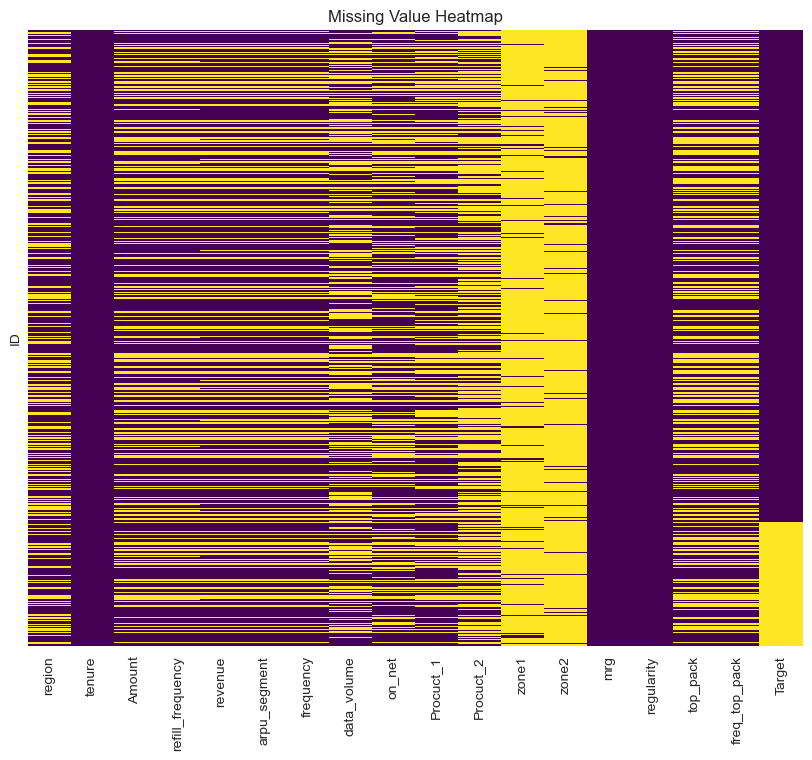

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(raw_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Value Heatmap')
plt.show()

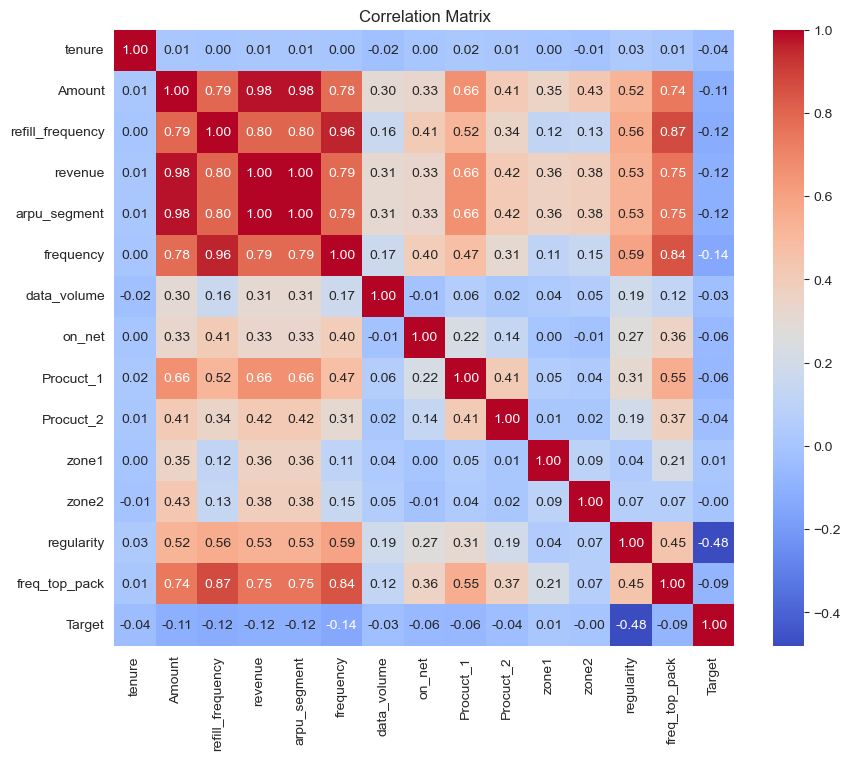

In [ ]:
correlation_matrix = raw_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

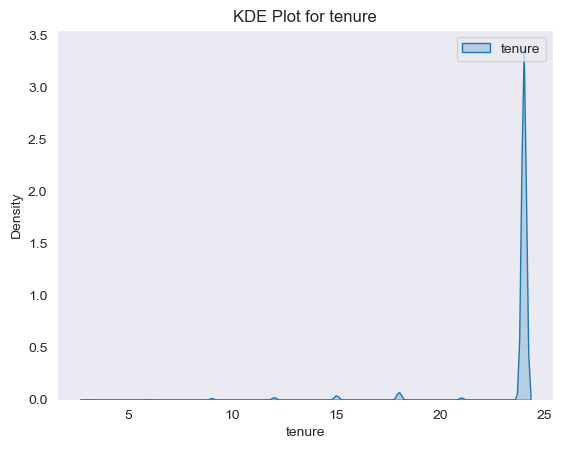

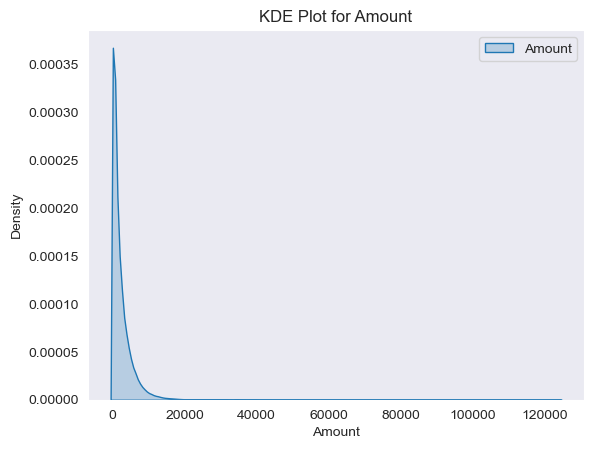

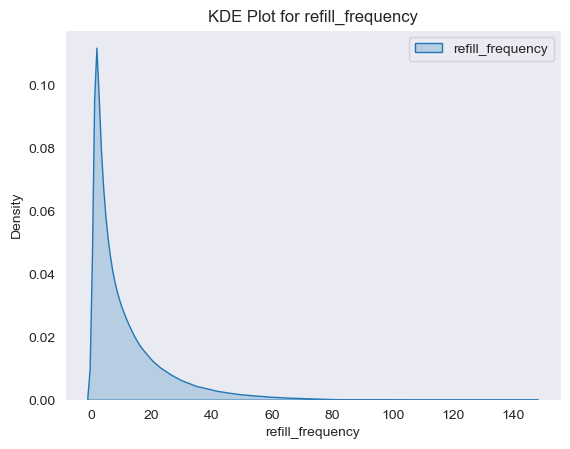

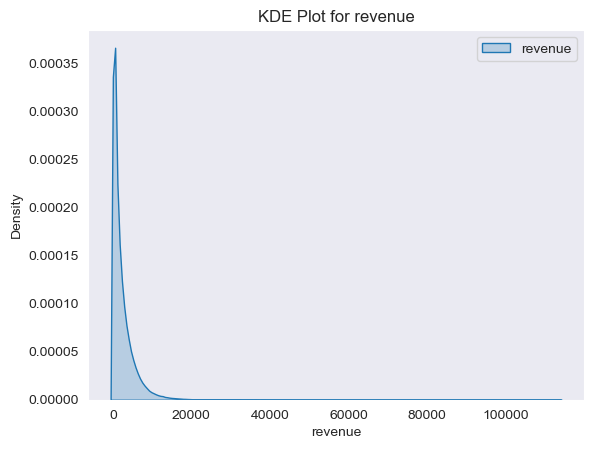

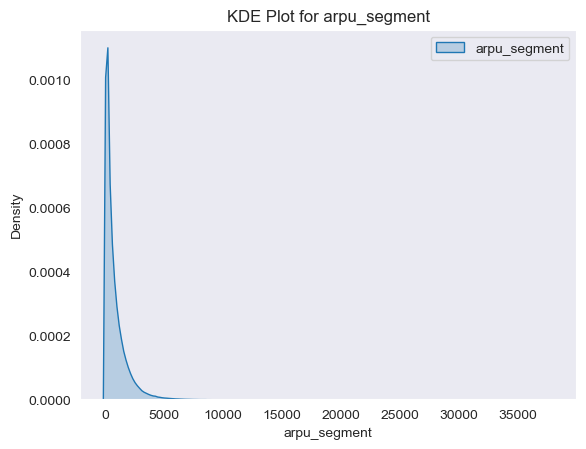

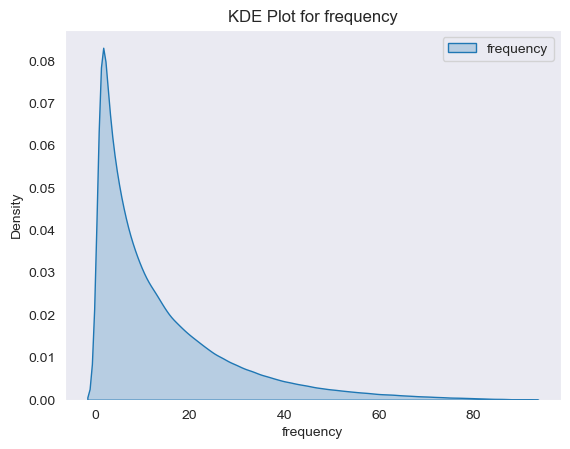

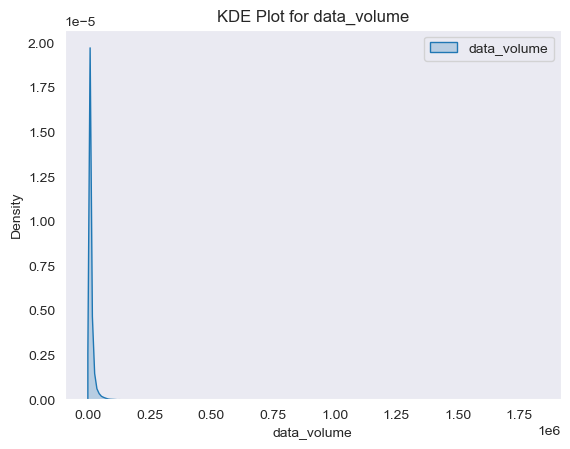

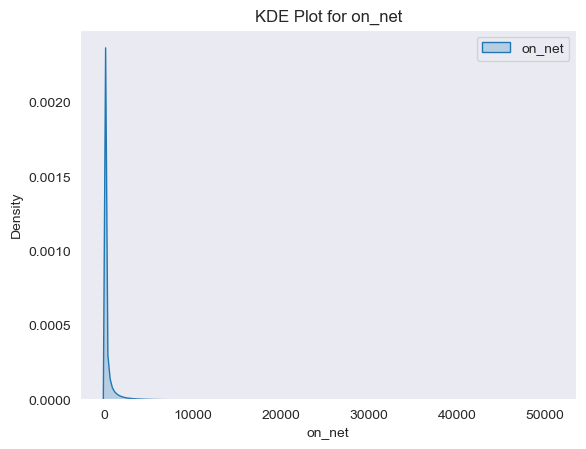

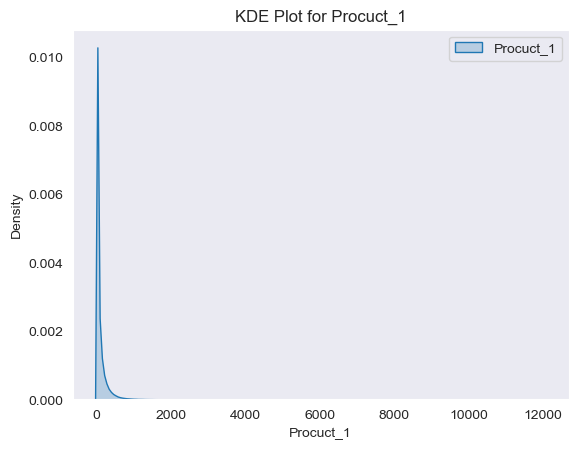

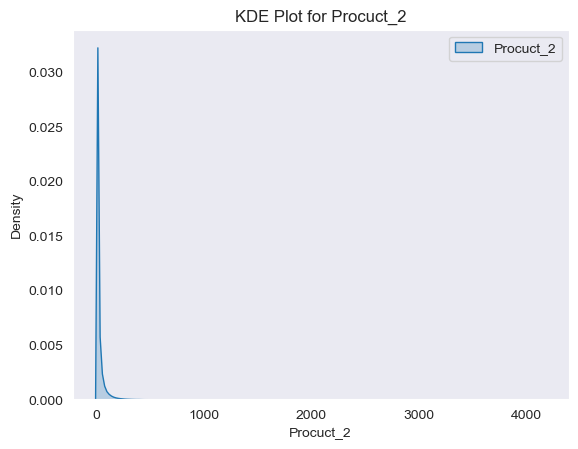

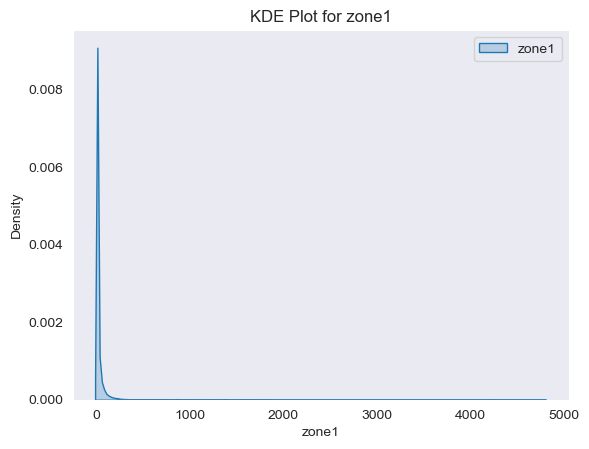

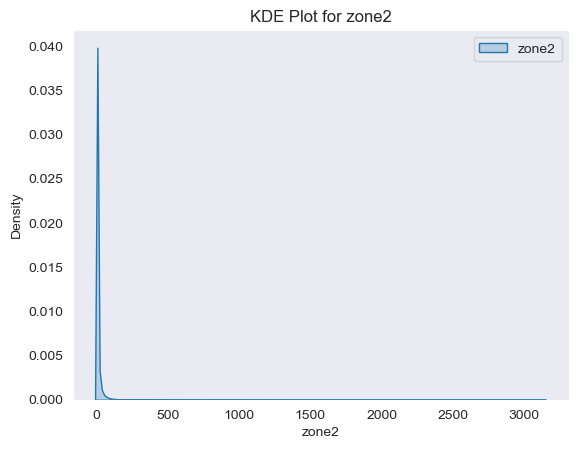

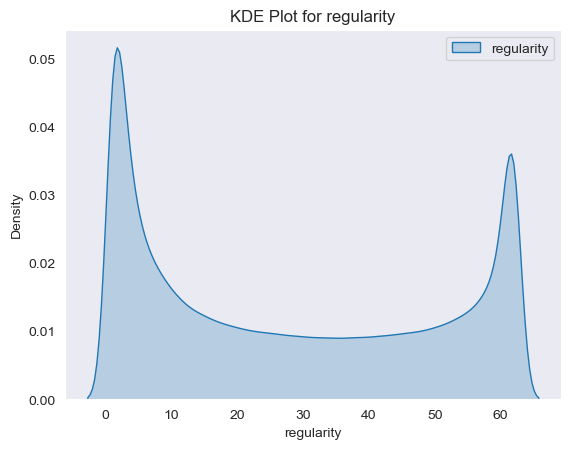

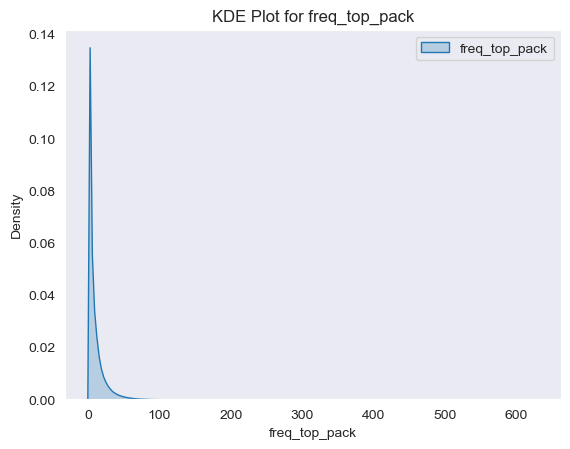

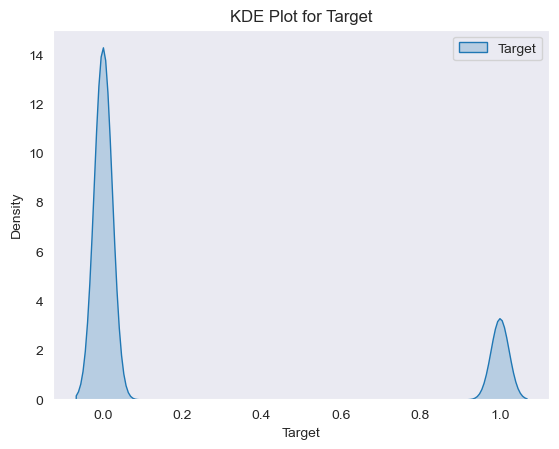

In [ ]:
eda_df = raw_df.iloc[:,1:18].copy().drop(columns =['top_pack','mrg'])
for column in eda_df.columns:
    sns.kdeplot(eda_df[column], label=column, shade=True)
    plt.title(f'KDE Plot for {column}')
    plt.legend()
    plt.show()

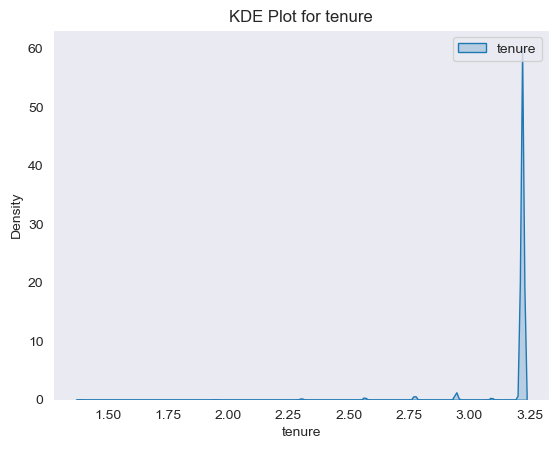

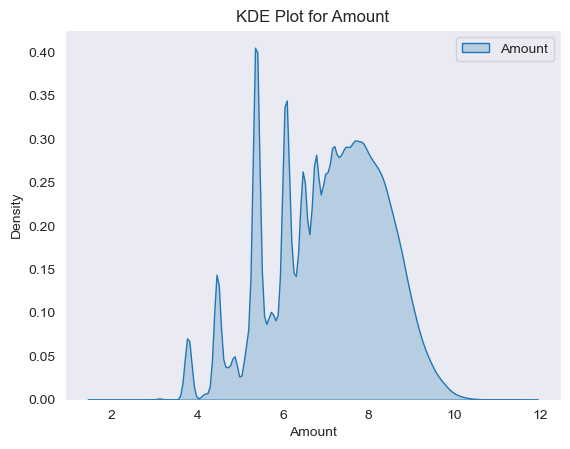

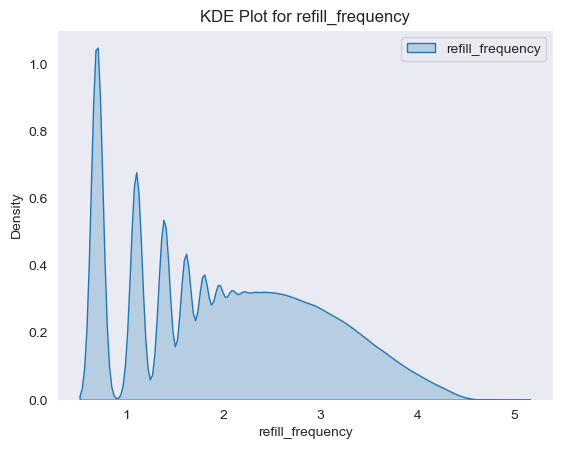

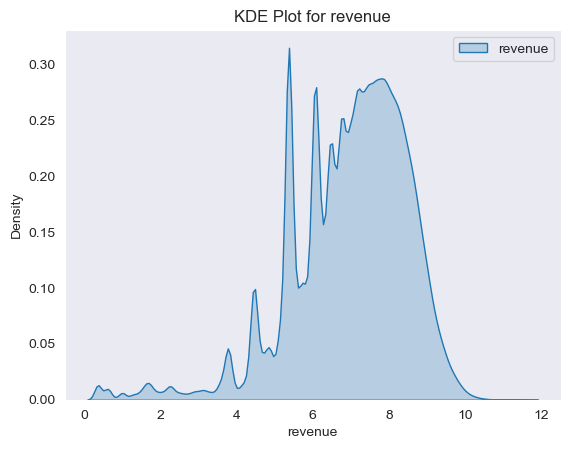

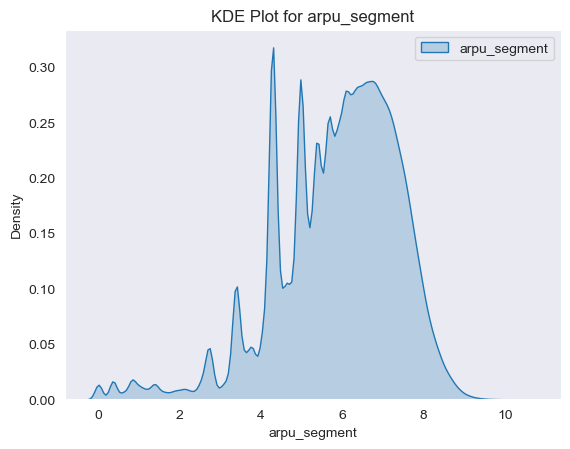

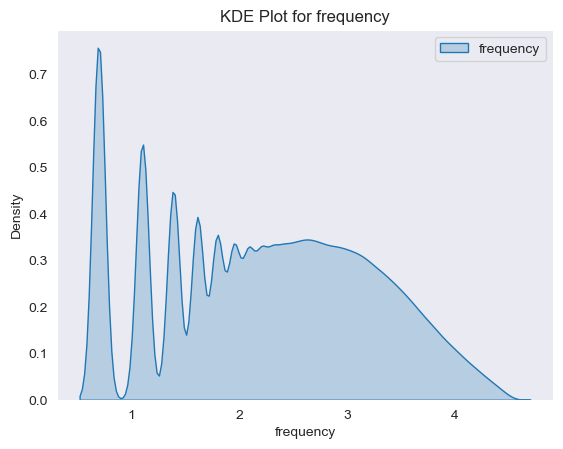

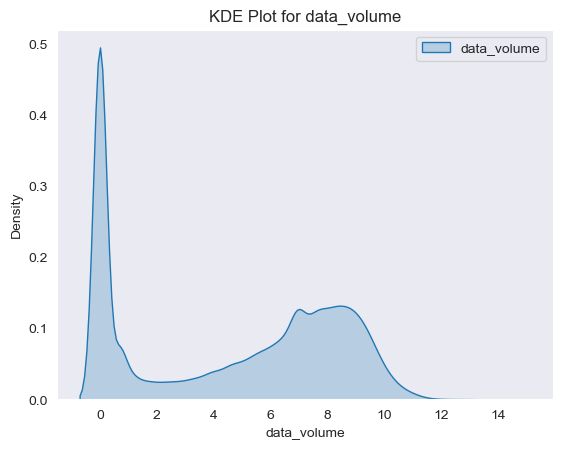

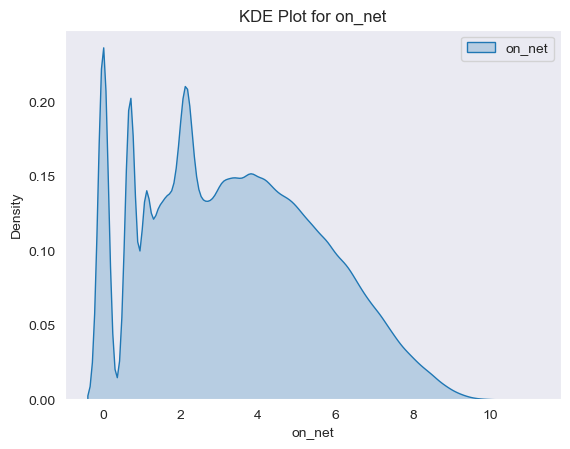

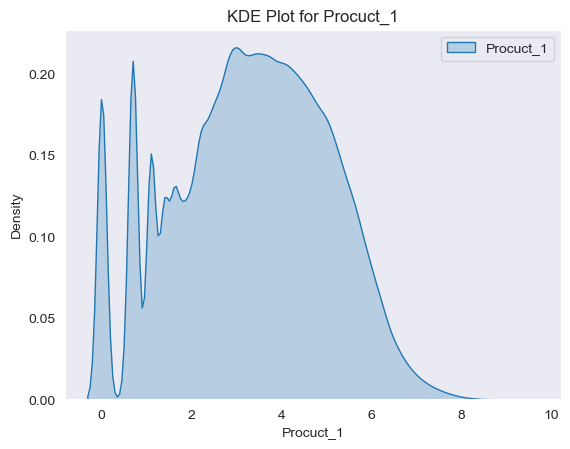

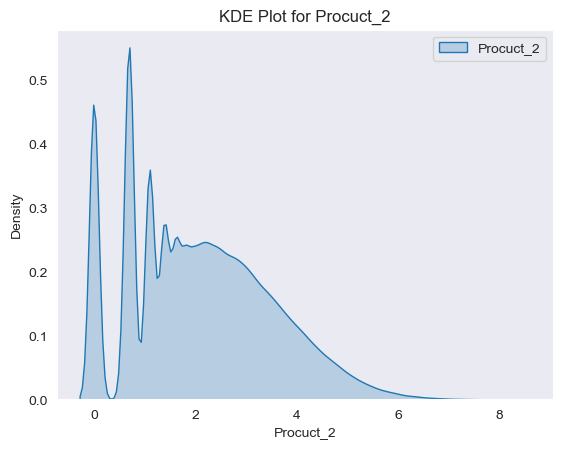

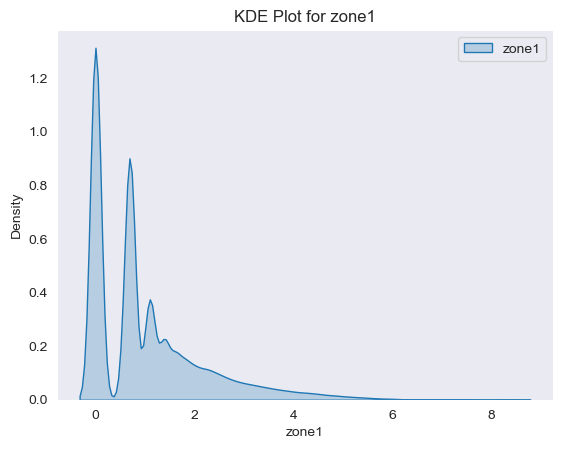

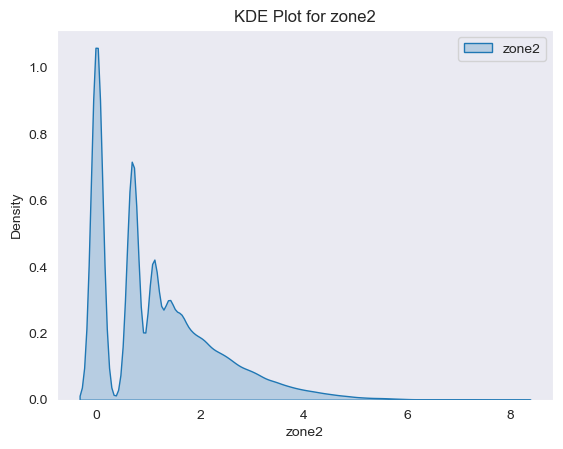

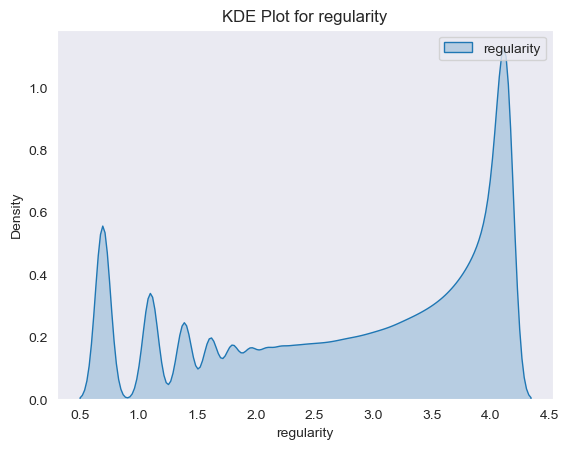

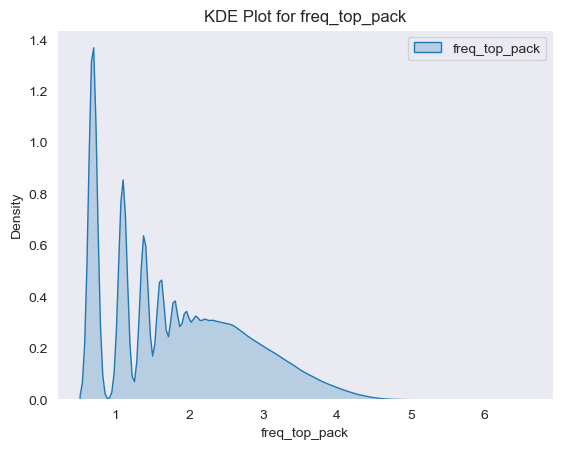

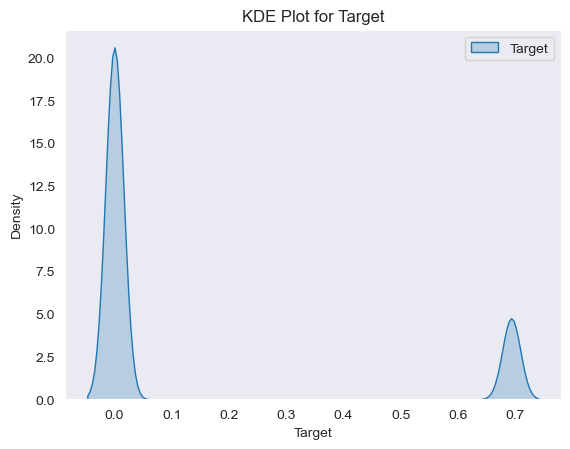

In [ ]:
log_eda_df = np.log(raw_df.iloc[:,1:18].copy().drop(columns =['top_pack','mrg'])+1)
for column in log_eda_df.columns:
    sns.kdeplot(log_eda_df[column], label=column, shade=True)
    plt.title(f'KDE Plot for {column}')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


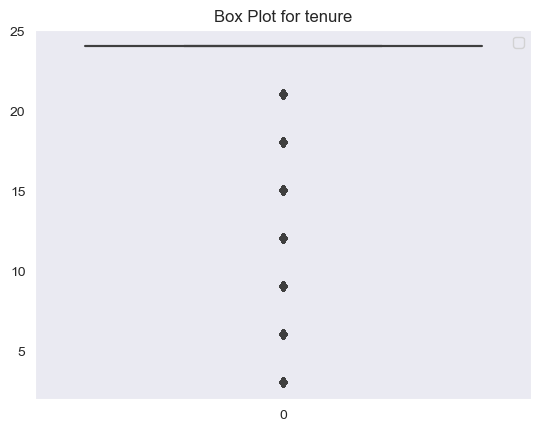

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


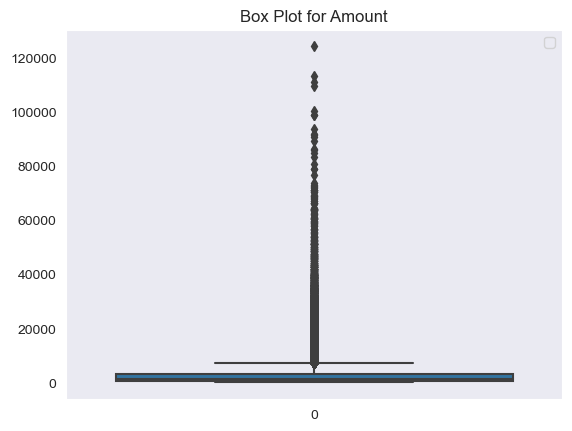

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


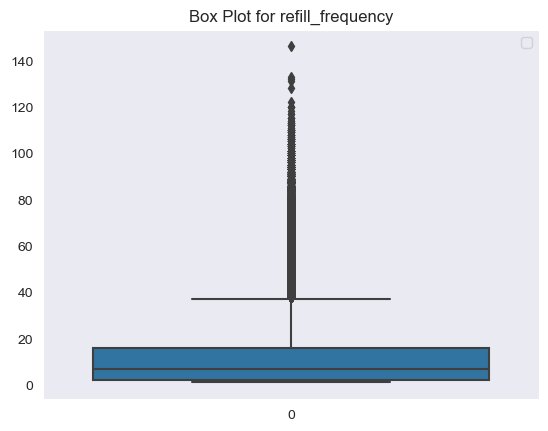

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


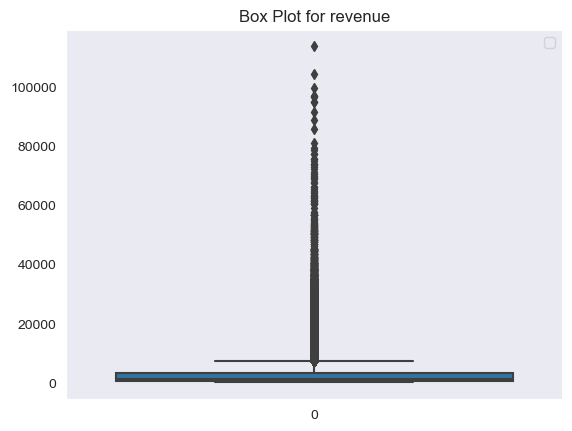

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


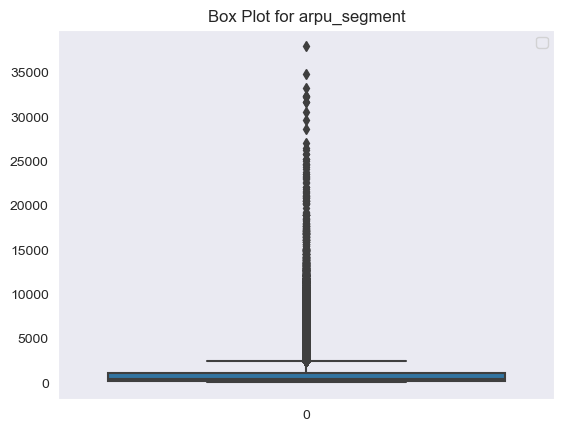

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


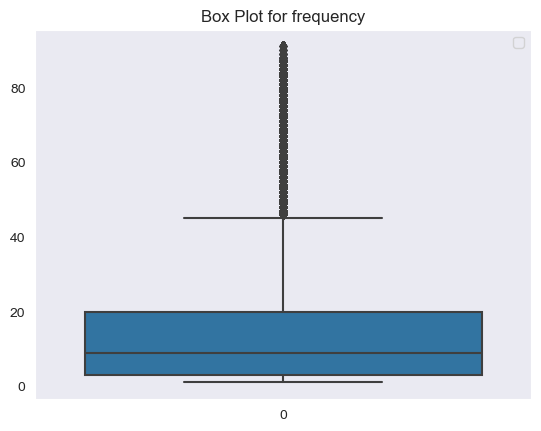

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


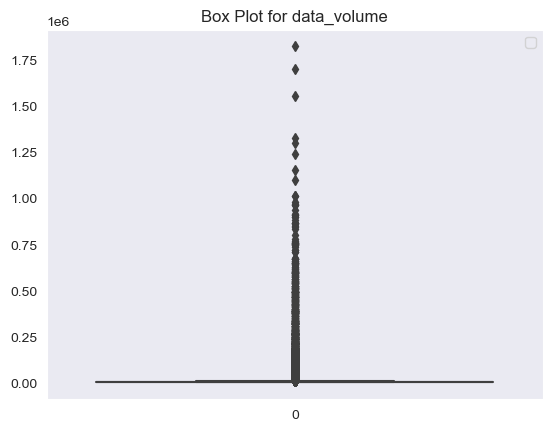

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


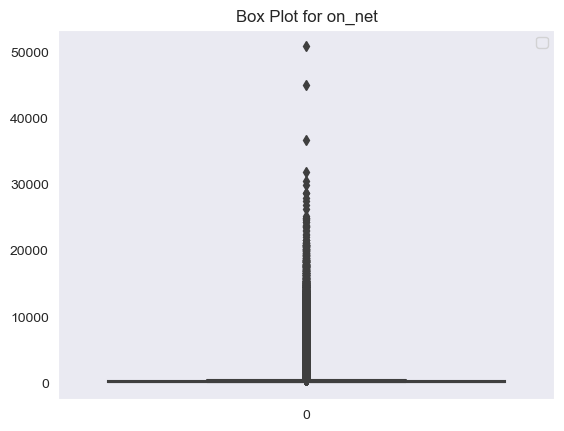

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


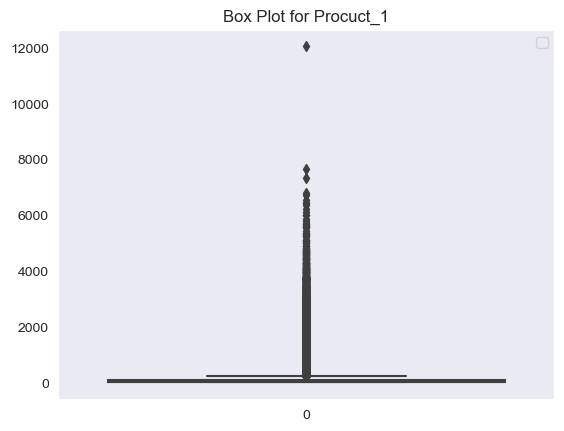

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


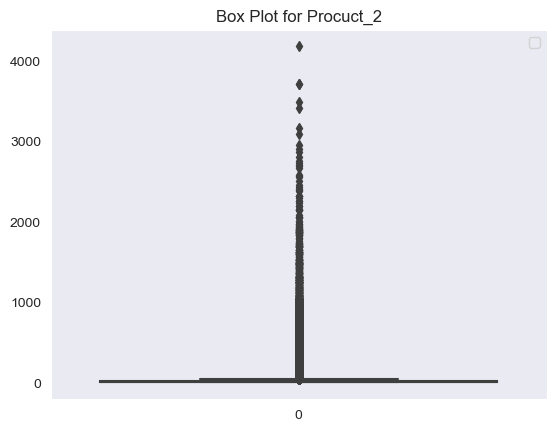

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


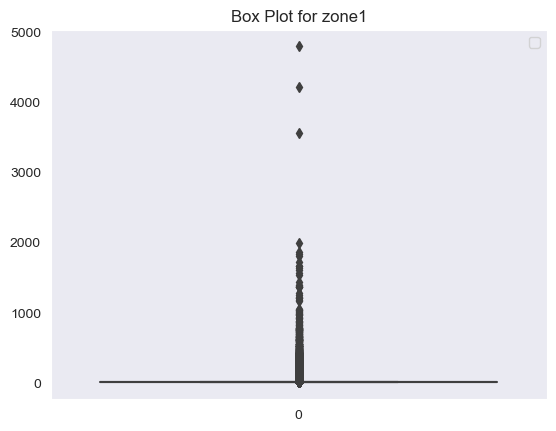

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


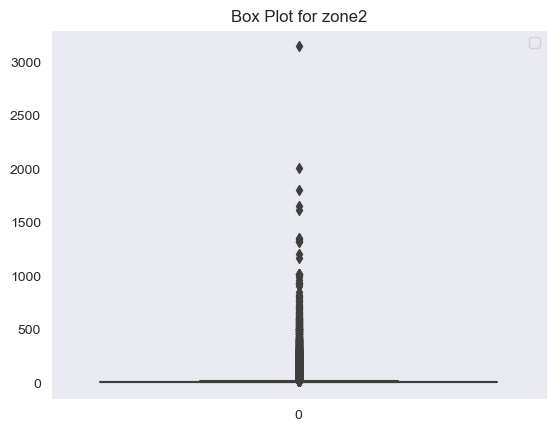

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


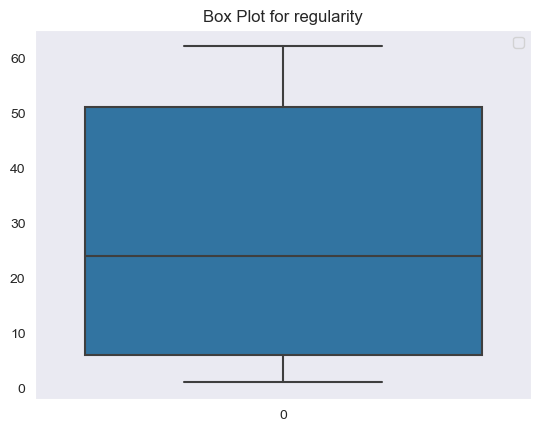

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


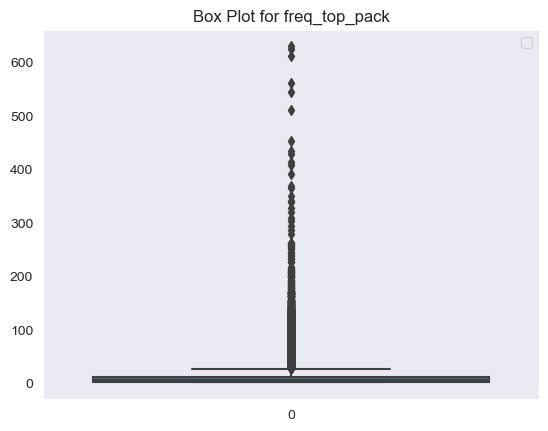

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


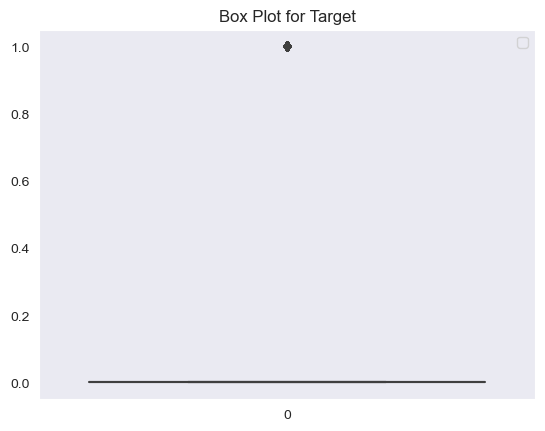

In [ ]:
for column in eda_df.columns:
    sns.boxplot(eda_df[column])
    plt.title(f'Box Plot for {column}')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


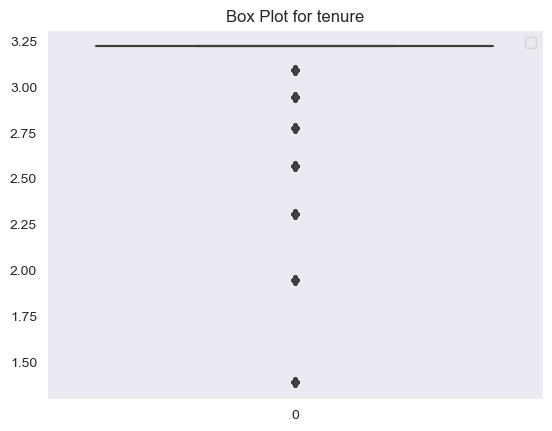

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


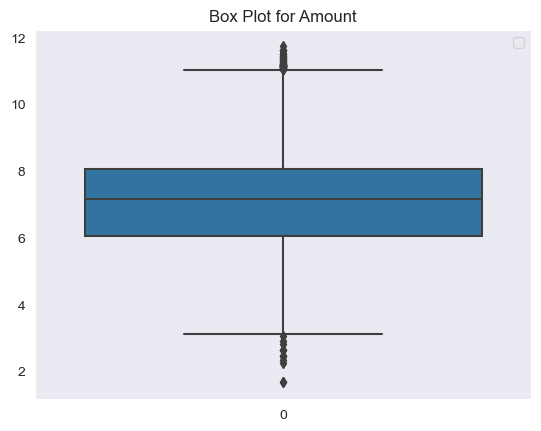

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


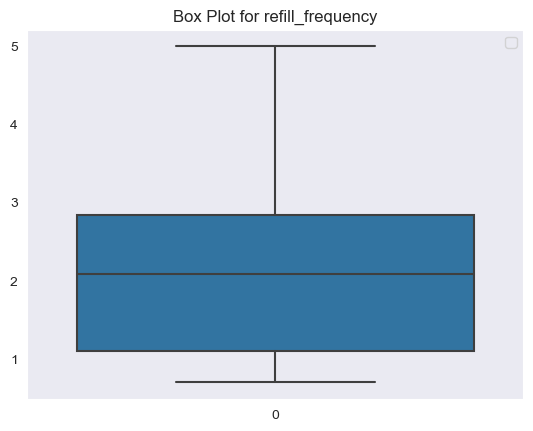

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


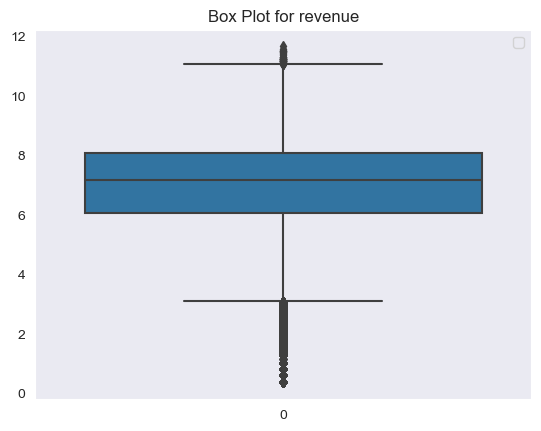

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


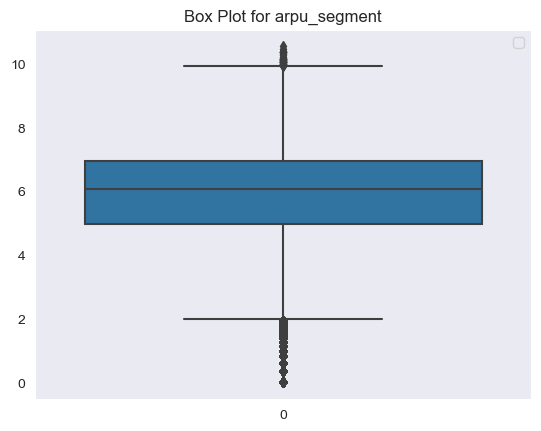

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


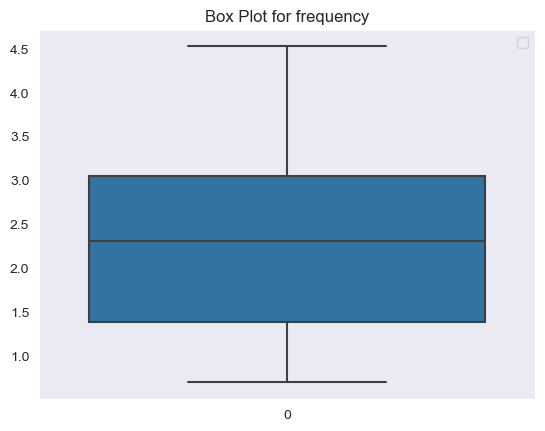

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


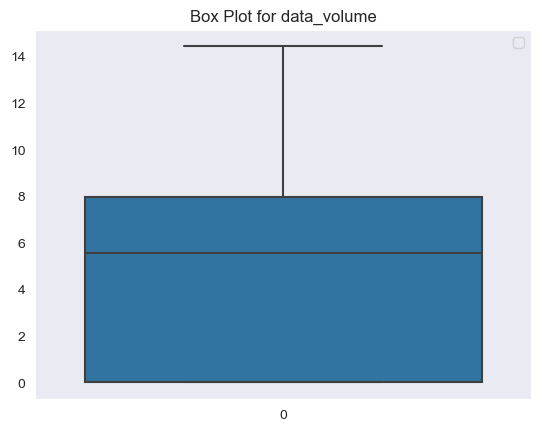

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


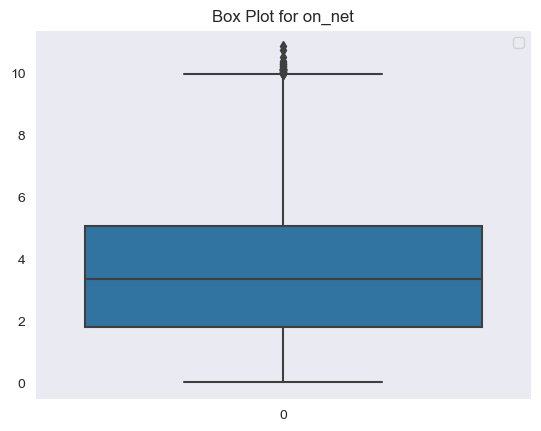

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


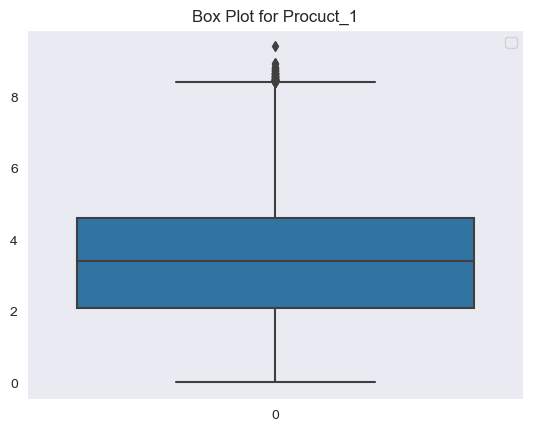

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


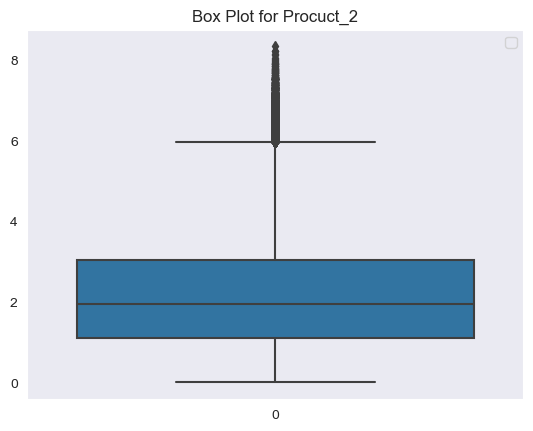

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


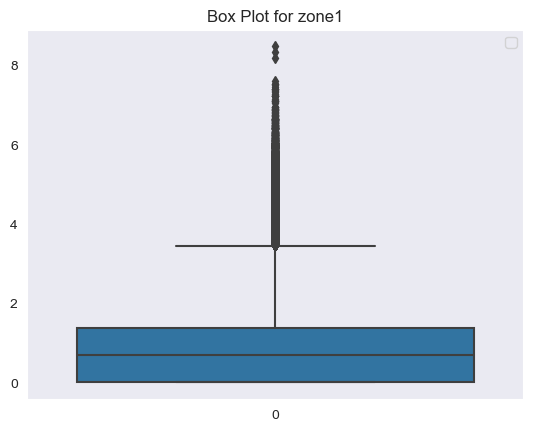

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


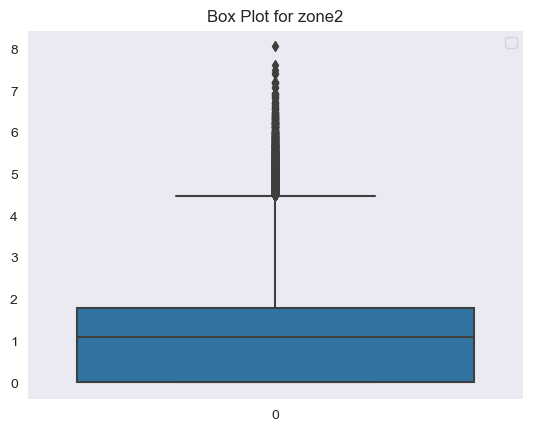

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


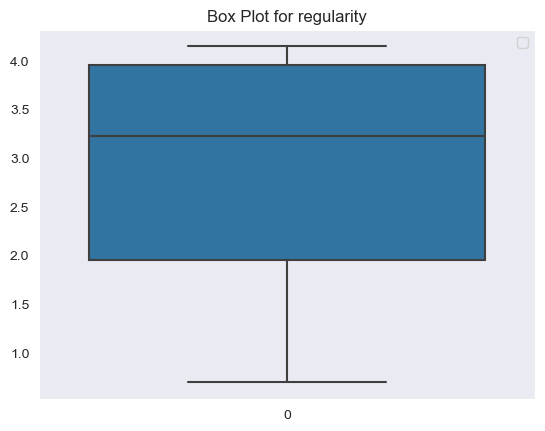

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


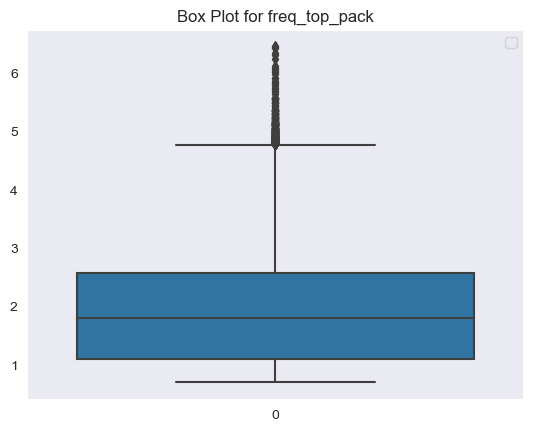

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


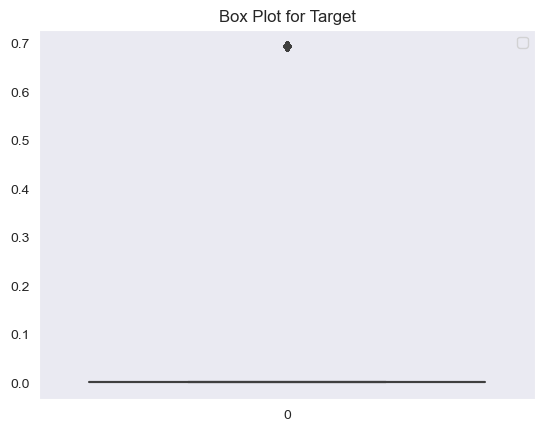

In [ ]:
for column in log_eda_df.columns:
    sns.boxplot(log_eda_df[column])
    plt.title(f'Box Plot for {column}')
    plt.legend()
    plt.show()

In [ ]:
log_eda_df.shape

(1887961, 15)

In [ ]:
log_eda_df.isnull().sum()

tenure                    0
Amount               662569
refill_frequency     662569
revenue              635494
arpu_segment         635494
frequency            635494
data_volume          928846
on_net               689156
Procuct_1            783793
Procuct_2           1130051
zone1               1739114
zone2               1768380
regularity                0
freq_top_pack        790602
Target               380127
dtype: int64

In [7]:
log_eda_df = np.log(raw_df.iloc[:,1:18].copy().drop(columns =['top_pack','mrg'])+1)
features_for_clustering = ['tenure', 'Amount', 'frequency','on_net','regularity']

# Extract the relevant features and scale them
cluster_data = log_eda_df[features_for_clustering]
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(cluster_data),columns=features_for_clustering)

In [8]:
for tenure in scaled_data.tenure.unique():
    print(scaled_data.isnull().sum())
    region_med_1 = scaled_data[scaled_data['tenure'] == tenure].groupby('regularity')
    scaled_data[scaled_data['tenure'] == tenure] = scaled_data[scaled_data['tenure'] == tenure].fillna(region_med_1.transform('median'))
    print('After Fill:  ')
    print(scaled_data.isnull().sum())
    
scaled_data

tenure             0
Amount        662569
frequency     635494
on_net        689156
regularity         0
dtype: int64
After Fill:  
tenure            0
Amount        40297
frequency     38581
on_net        45824
regularity        0
dtype: int64
tenure            0
Amount        40297
frequency     38581
on_net        45824
regularity        0
dtype: int64
After Fill:  
tenure            0
Amount        23793
frequency     22800
on_net        26892
regularity        0
dtype: int64
tenure            0
Amount        23793
frequency     22800
on_net        26892
regularity        0
dtype: int64
After Fill:  
tenure            0
Amount        14109
frequency     13508
on_net        16035
regularity        0
dtype: int64
tenure            0
Amount        14109
frequency     13508
on_net        16035
regularity        0
dtype: int64
After Fill:  
tenure            0
Amount        11002
frequency     10531
on_net        12384
regularity        0
dtype: int64
tenure            0
Amount        1

tenure    Amount  frequency    on_net  regularity
0        0.196461 -1.309689  -1.600989 -0.941271   -1.276145
1        0.196461  1.085852   1.517278  1.372557    1.092585
2        0.196461  1.233608   0.900517 -1.575864    1.078838
3        0.196461 -1.309689  -1.185702 -0.839124   -0.795313
4        0.196461  1.174149   1.899522  1.310073    1.092585
...           ...       ...        ...       ...         ...
1887956  0.196461  1.001755   0.807342  0.305938    0.975902
1887957  0.196461  1.372083   1.517278  0.558881    1.050664
1887958  0.196461  0.190865  -1.600989 -1.258568    0.784173
1887959  0.196461  0.525764   0.392055 -0.306678    1.078838
1887960  0.196461 -1.309689  -1.600989 -1.258568   -1.871711

[1887961 rows x 5 columns]

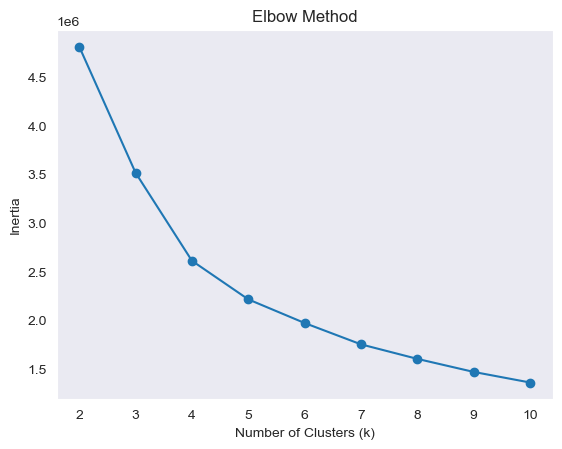

In [9]:
inertia_values = []
k_values = range(2, 11)  # You can adjust the range as needed

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [10]:
scaled_data['cluster'] = kmeans.predict(scaled_data)
scaled_data

tenure    Amount  frequency    on_net  regularity  cluster
0        0.196461 -1.309689  -1.600989 -0.941271   -1.276145        1
1        0.196461  1.085852   1.517278  1.372557    1.092585        8
2        0.196461  1.233608   0.900517 -1.575864    1.078838        5
3        0.196461 -1.309689  -1.185702 -0.839124   -0.795313        7
4        0.196461  1.174149   1.899522  1.310073    1.092585        8
...           ...       ...        ...       ...         ...      ...
1887956  0.196461  1.001755   0.807342  0.305938    0.975902        5
1887957  0.196461  1.372083   1.517278  0.558881    1.050664        8
1887958  0.196461  0.190865  -1.600989 -1.258568    0.784173        0
1887959  0.196461  0.525764   0.392055 -0.306678    1.078838        5
1887960  0.196461 -1.309689  -1.600989 -1.258568   -1.871711        1

[1887961 rows x 6 columns]

5 seems the best choice

In [11]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(scaled_data)
raw_df['cluster'] = kmeans.predict(scaled_data)
raw_df

region  tenure   Amount  refill_frequency  revenue  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN      24      NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.96              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.23              22.0  5769.23   
ID_QS4F5LEX29KM        NaN      24      NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.88              58.0  5636.75   
...                    ...     ...      ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.50              19.0  4487.18   
ID_XGDT520DFBLP        NaN      24  6901.71              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24      NaN               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.69               9.0  2264.53   
ID_2F6Y446GS8T3        NaN      24      NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  \
ID                                                                         
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0   
...                       ...        ...          ...     ...        ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN   

                 Procuct_2  zone1  zone2 mrg  regularity  \
ID                                                         
ID_YEB05X4KUGPQ        NaN    NaN    NaN  NO           3   
ID_Z9IQ9QH52KVN        NaN    NaN    NaN  NO          62   
ID_YZSU7B7M35QS        1.0    NaN    NaN  NO          61   
ID_QS4F5LEX29KM        NaN    NaN    NaN  NO           6   
ID_8IYIC9PFU8U1        0.0    NaN    NaN  NO          62   
...                    ...    ...    ...  ..         ...   
ID_MGZSA4ICBD9O       80.0    NaN    NaN  NO          54   
ID_XGDT520DFBLP        5.0    NaN    NaN  NO          59   
ID_9RDB792PB5Q4        NaN    NaN    NaN  NO          43   
ID_KDTJHH8L8Z13       19.0    2.0    NaN  NO          61   
ID_2F6Y446GS8T3        NaN    NaN    NaN  NO           1   

                                       top_pack  freq_top_pack  Target  \
ID                                                                       
ID_YEB05X4KUGPQ                             NaN            NaN     0.0   
ID_Z9IQ9QH52KVN  On net 200F=Unlimited _call24H           31.0     0.0   
ID_YZSU7B7M35QS                             NaN            NaN     0.0   
ID_QS4F5LEX29KM                             NaN            NaN     0.0   
ID_8IYIC9PFU8U1     Mixt 250F=Unlimited_call24H           31.0     0.0   
...                                         ...            ...     ...   
ID_MGZSA4ICBD9O           All-net 500F=2000F;5d           20.0     NaN   
ID_XGDT520DFBLP           Data: 200 F=100MB,24H           33.0     NaN   
ID_9RDB792PB5Q4                             NaN            NaN     NaN   
ID_KDTJHH8L8Z13                Data:490F=1GB,7d            5.0     NaN   
ID_2F6Y446GS8T3                             NaN            NaN     NaN   

                 cluster  
ID                        
ID_YEB05X4KUGPQ        4  
ID_Z9IQ9QH52KVN        3  
ID_YZSU7B7M35QS        2  
ID_QS4F5LEX29KM        1  
ID_8IYIC9PFU8U1        3  
...                  ...  
ID_MGZSA4ICBD9O        2  
ID_XGDT520DFBLP        3  
ID_9RDB792PB5Q4        0  
ID_KDTJHH8L8Z13        2  


In [12]:
raw_df['Target'] = raw_df['Target'].fillna('999').astype(int)
raw_df

region  tenure   Amount  refill_frequency  revenue  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN      24      NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.96              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.23              22.0  5769.23   
ID_QS4F5LEX29KM        NaN      24      NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.88              58.0  5636.75   
...                    ...     ...      ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.50              19.0  4487.18   
ID_XGDT520DFBLP        NaN      24  6901.71              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24      NaN               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.69               9.0  2264.53   
ID_2F6Y446GS8T3        NaN      24      NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  \
ID                                                                         
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0   
...                       ...        ...          ...     ...        ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN   

                 Procuct_2  zone1  zone2 mrg  regularity  \
ID                                                         
ID_YEB05X4KUGPQ        NaN    NaN    NaN  NO           3   
ID_Z9IQ9QH52KVN        NaN    NaN    NaN  NO          62   
ID_YZSU7B7M35QS        1.0    NaN    NaN  NO          61   
ID_QS4F5LEX29KM        NaN    NaN    NaN  NO           6   
ID_8IYIC9PFU8U1        0.0    NaN    NaN  NO          62   
...                    ...    ...    ...  ..         ...   
ID_MGZSA4ICBD9O       80.0    NaN    NaN  NO          54   
ID_XGDT520DFBLP        5.0    NaN    NaN  NO          59   
ID_9RDB792PB5Q4        NaN    NaN    NaN  NO          43   
ID_KDTJHH8L8Z13       19.0    2.0    NaN  NO          61   
ID_2F6Y446GS8T3        NaN    NaN    NaN  NO           1   

                                       top_pack  freq_top_pack  Target  \
ID                                                                       
ID_YEB05X4KUGPQ                             NaN            NaN       0   
ID_Z9IQ9QH52KVN  On net 200F=Unlimited _call24H           31.0       0   
ID_YZSU7B7M35QS                             NaN            NaN       0   
ID_QS4F5LEX29KM                             NaN            NaN       0   
ID_8IYIC9PFU8U1     Mixt 250F=Unlimited_call24H           31.0       0   
...                                         ...            ...     ...   
ID_MGZSA4ICBD9O           All-net 500F=2000F;5d           20.0     999   
ID_XGDT520DFBLP           Data: 200 F=100MB,24H           33.0     999   
ID_9RDB792PB5Q4                             NaN            NaN     999   
ID_KDTJHH8L8Z13                Data:490F=1GB,7d            5.0     999   
ID_2F6Y446GS8T3                             NaN            NaN     999   

                 cluster  
ID                        
ID_YEB05X4KUGPQ        4  
ID_Z9IQ9QH52KVN        3  
ID_YZSU7B7M35QS        2  
ID_QS4F5LEX29KM        1  
ID_8IYIC9PFU8U1        3  
...                  ...  
ID_MGZSA4ICBD9O        2  
ID_XGDT520DFBLP        3  
ID_9RDB792PB5Q4        0  
ID_KDTJHH8L8Z13        2  


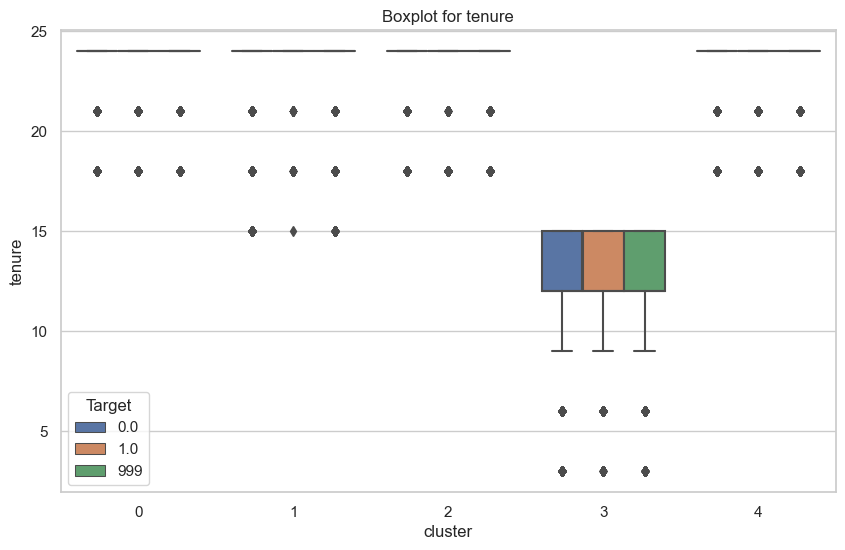

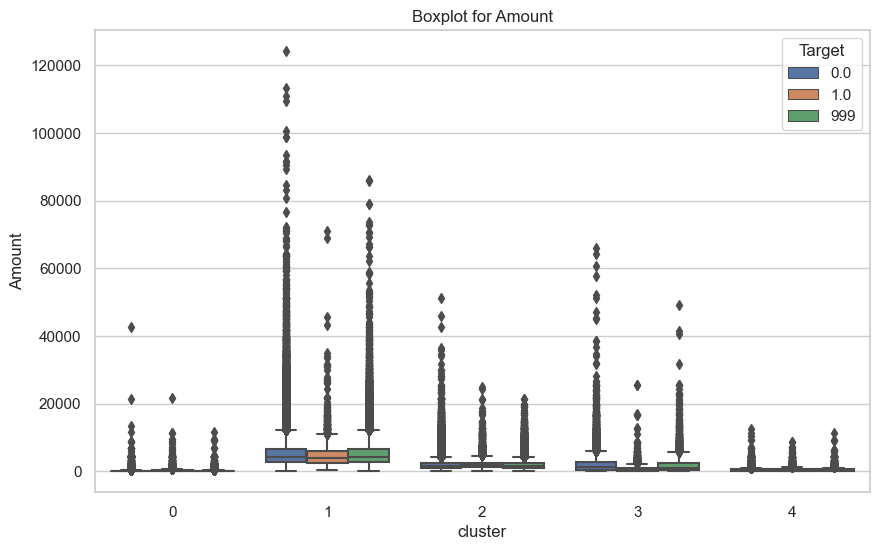

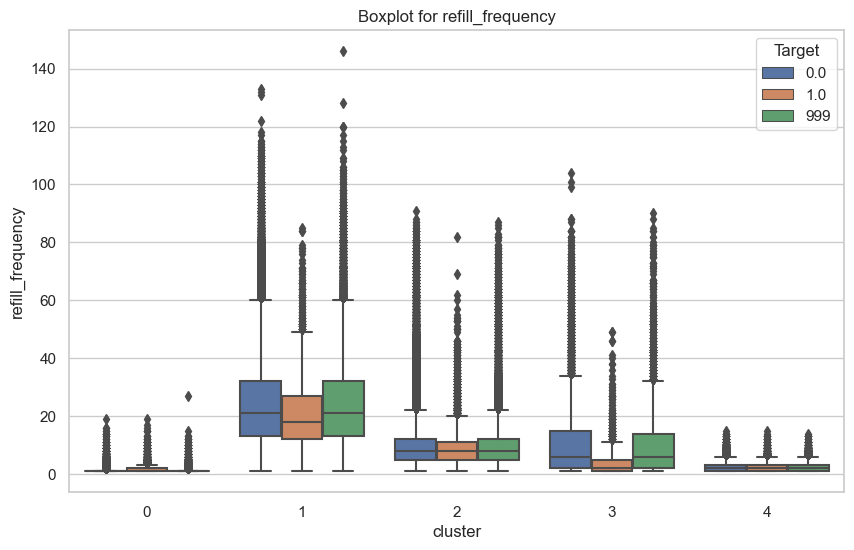

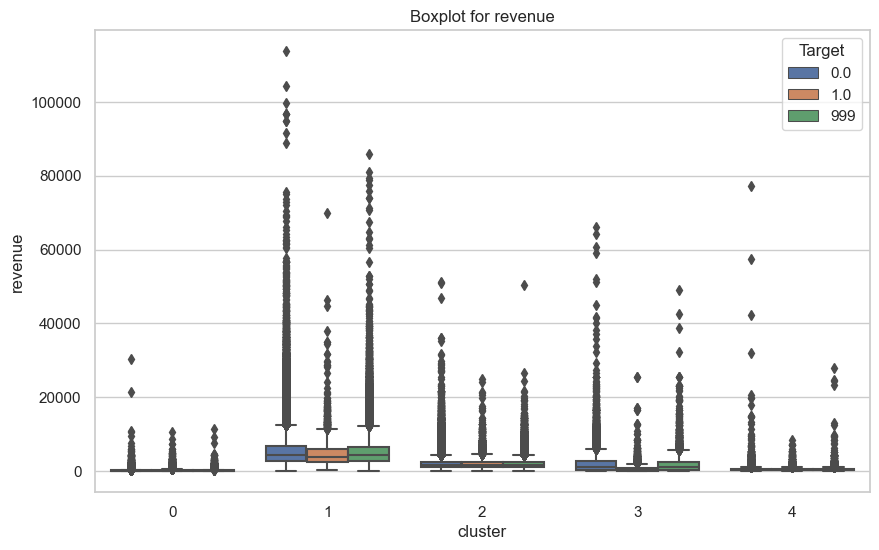

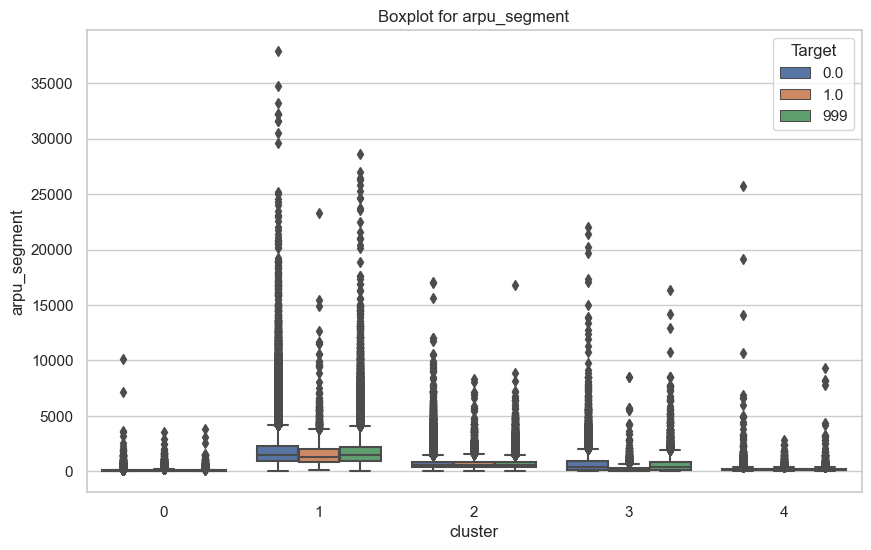

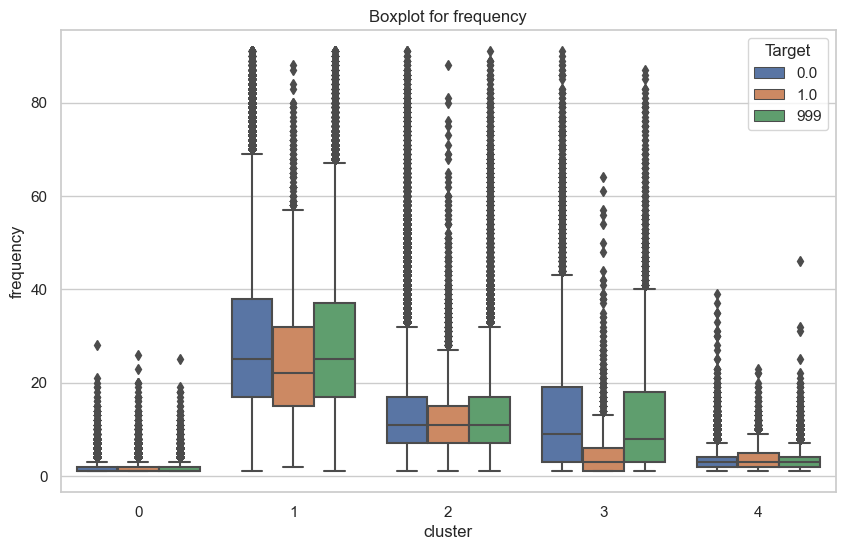

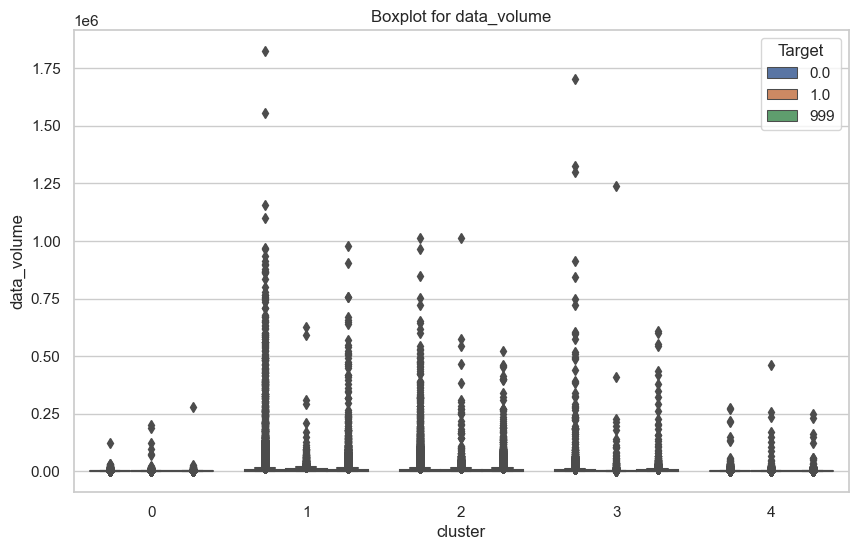

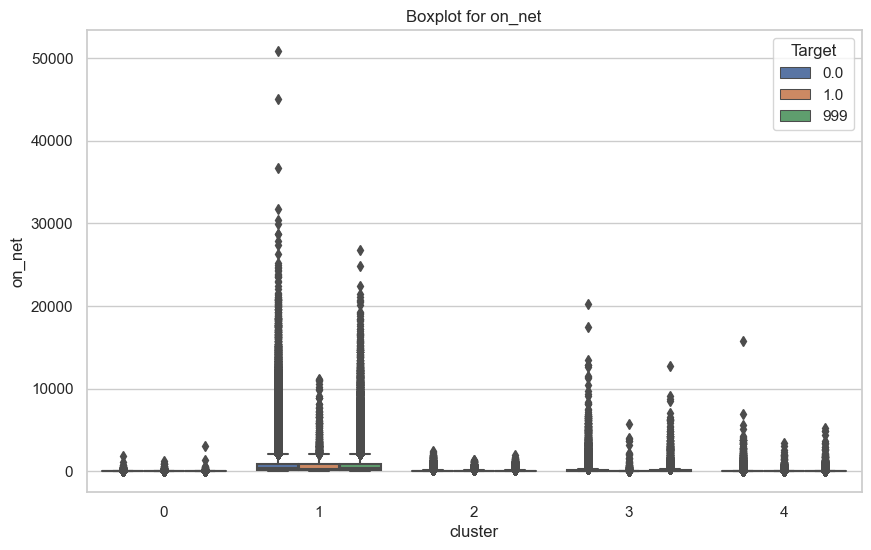

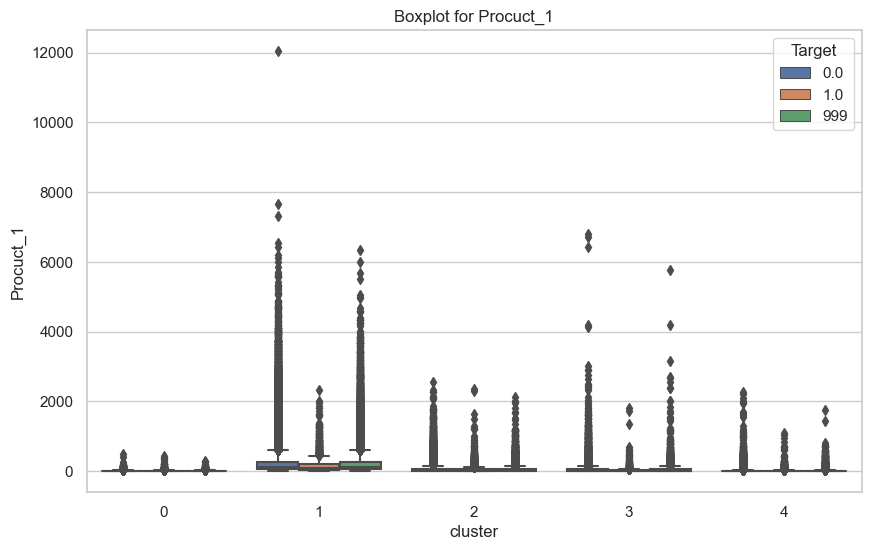

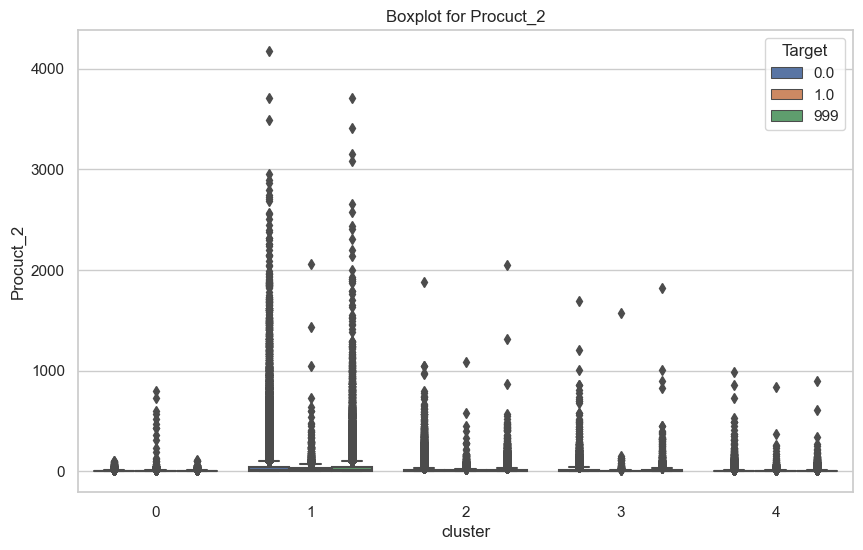

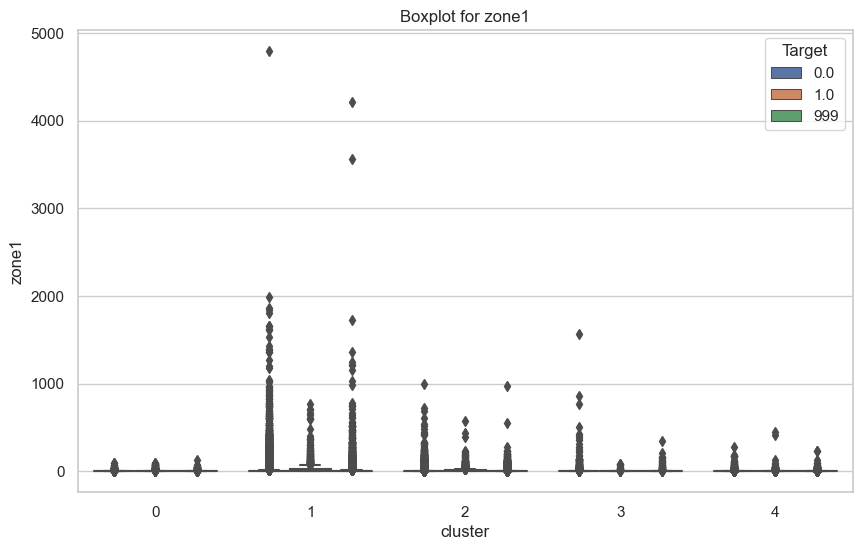

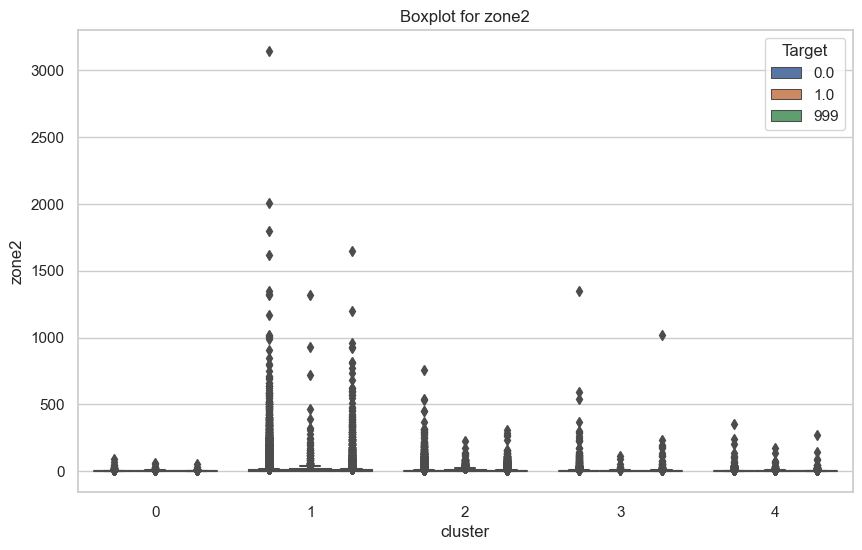

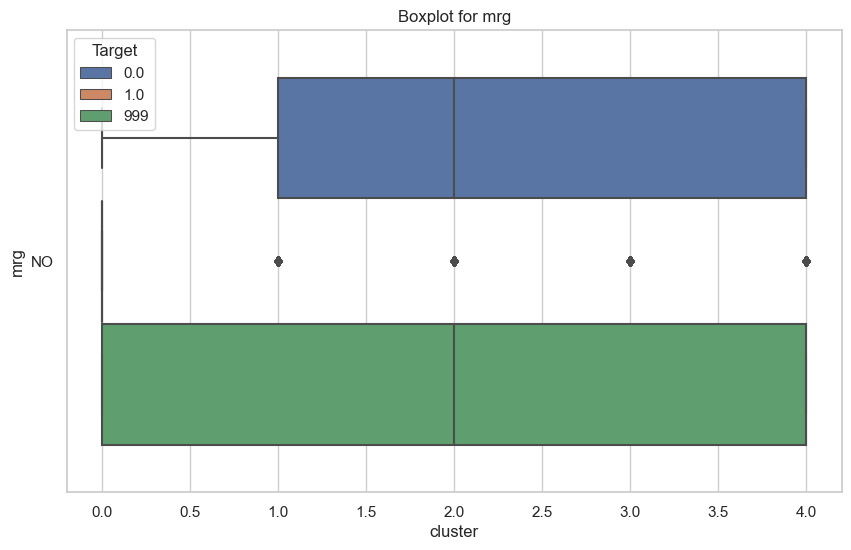

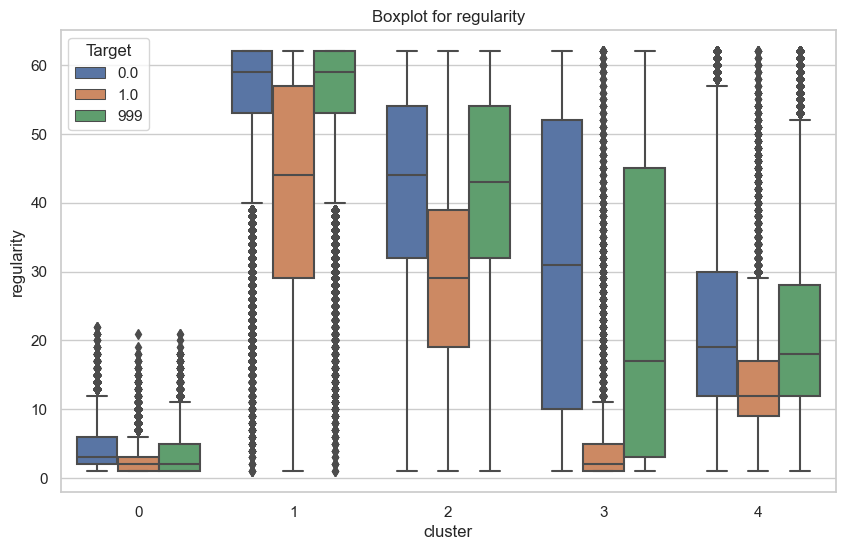

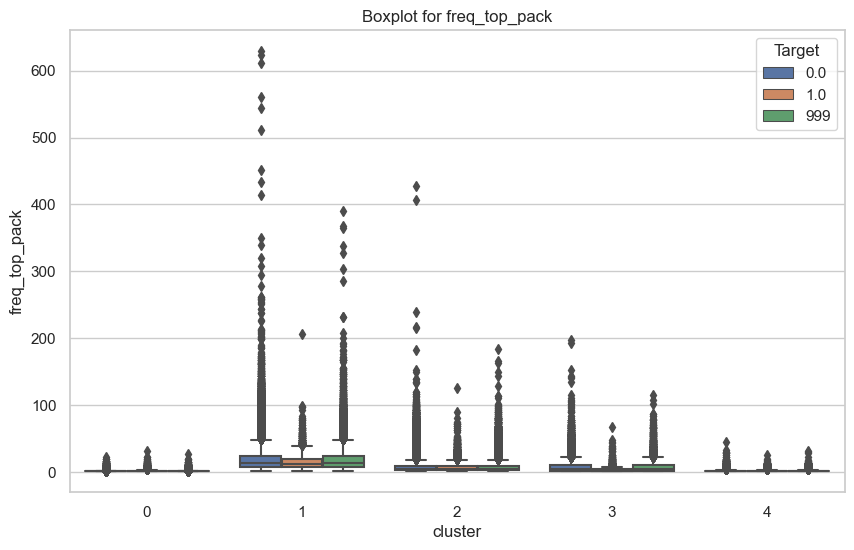

In [ ]:
features_to_plot = raw_df.iloc[:,1:17].drop(columns='top_pack').columns

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a boxplot for each feature
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.boxplot(x='cluster', y=feature, data=raw_df,hue='Target')
    plt.title(f'Boxplot for {feature}')
    plt.show()

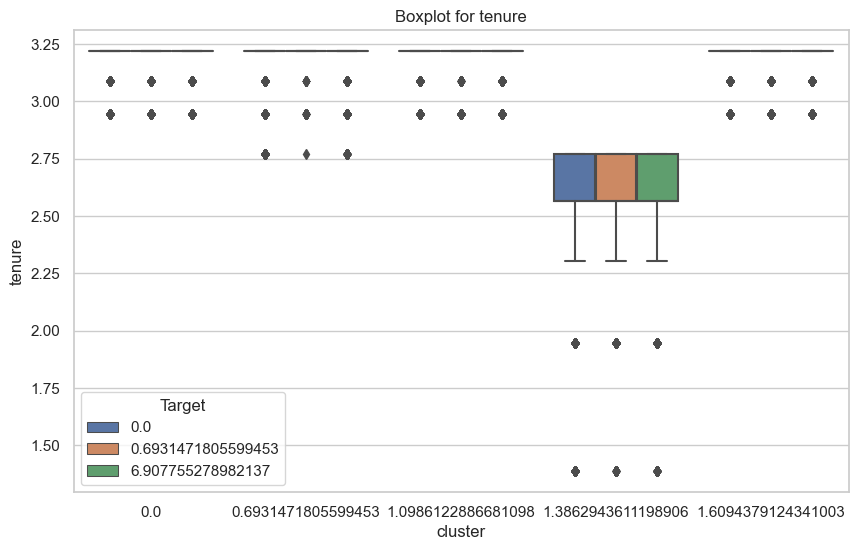

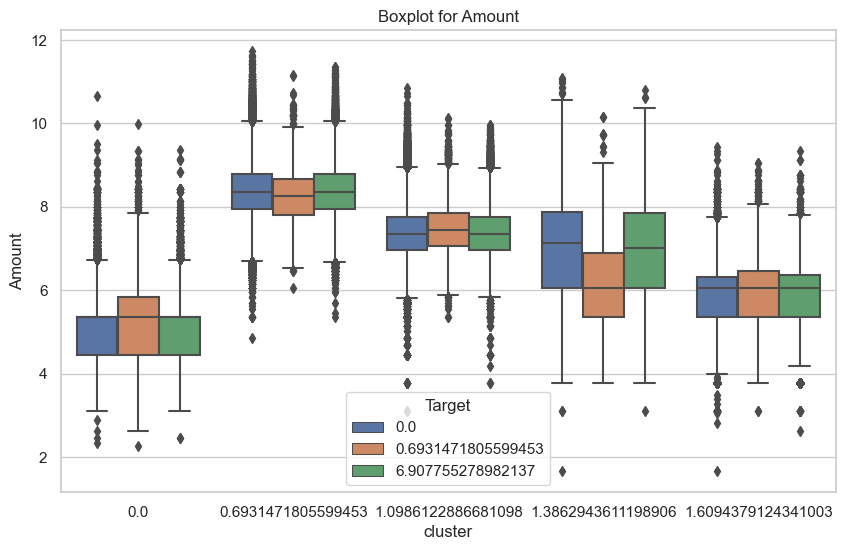

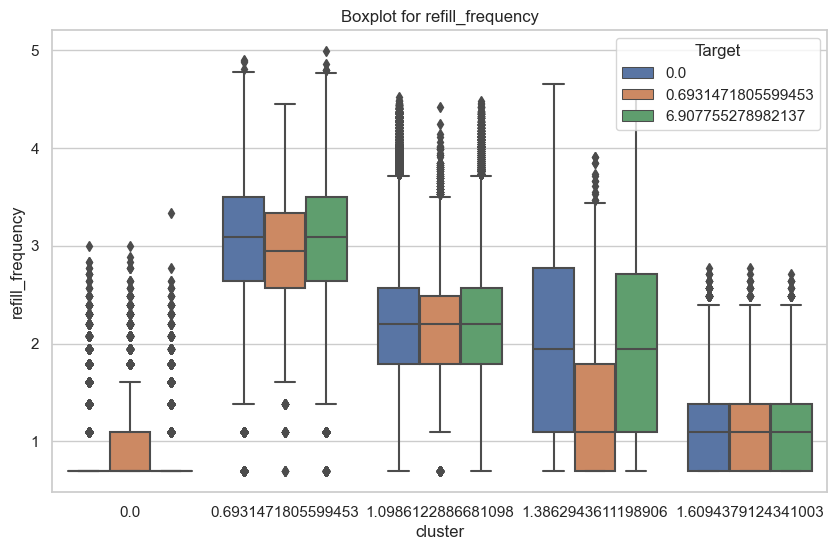

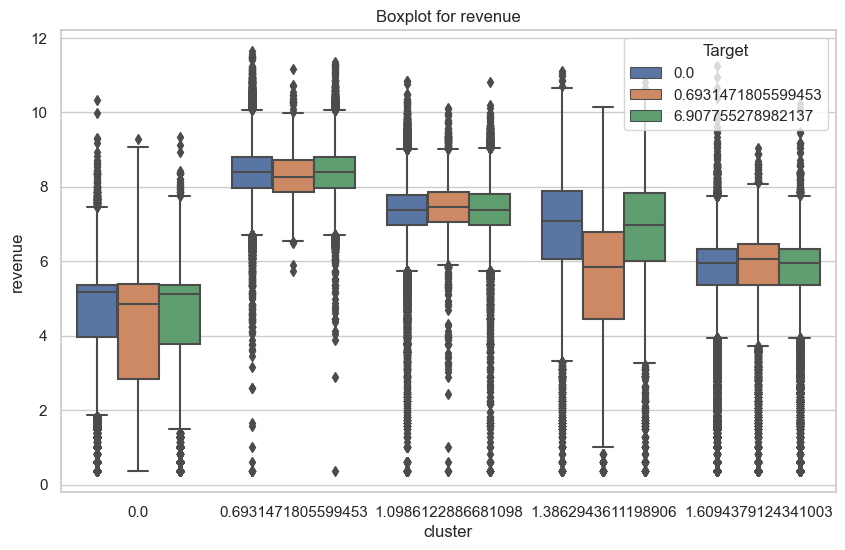

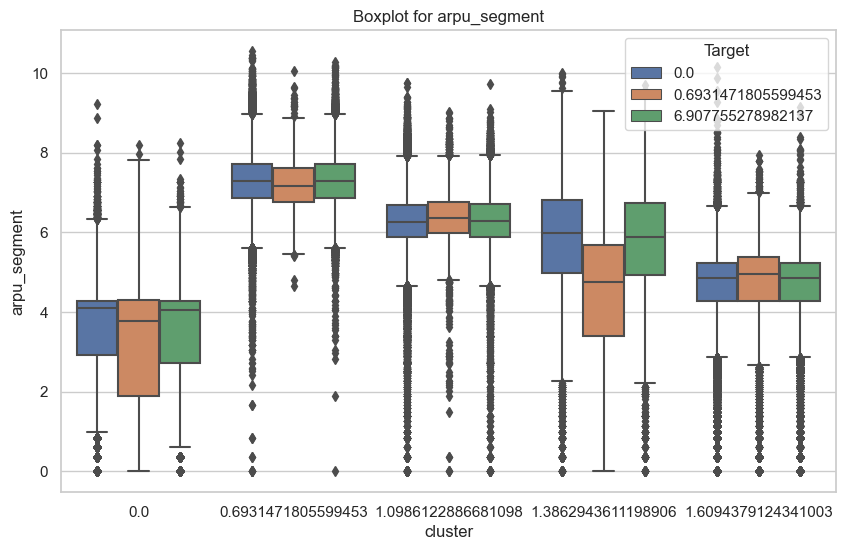

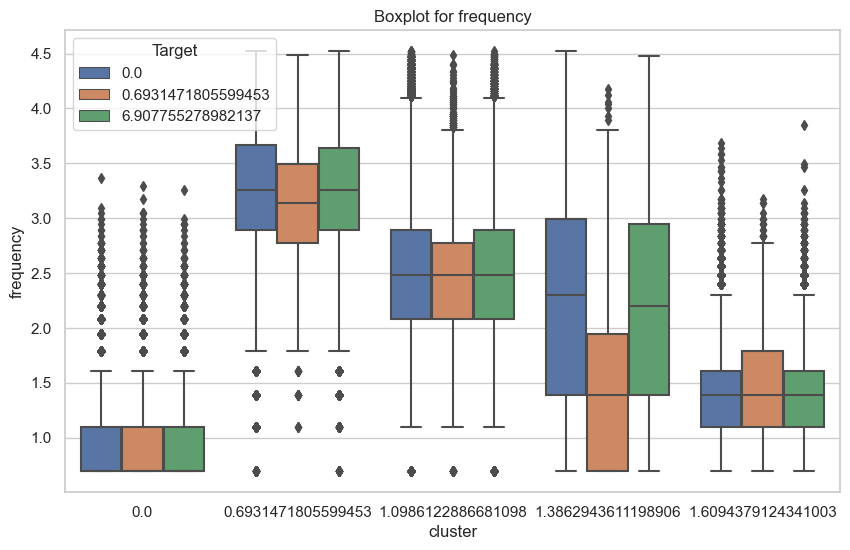

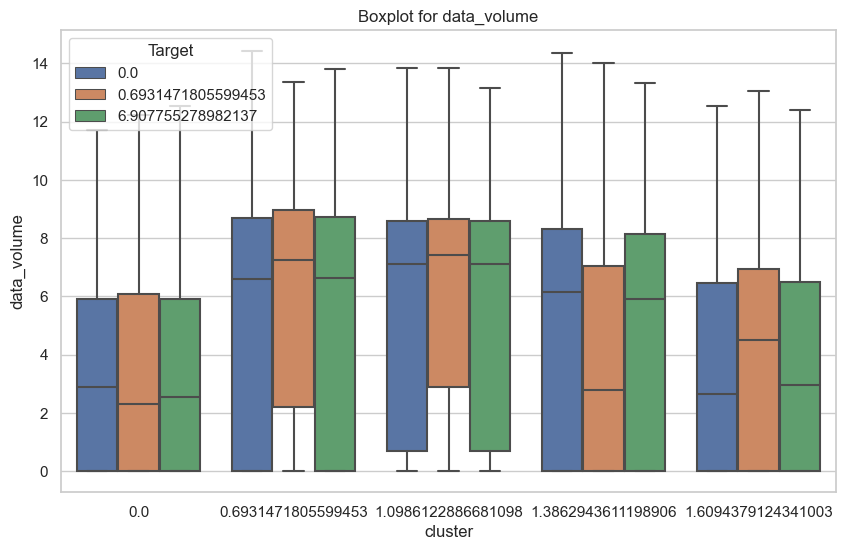

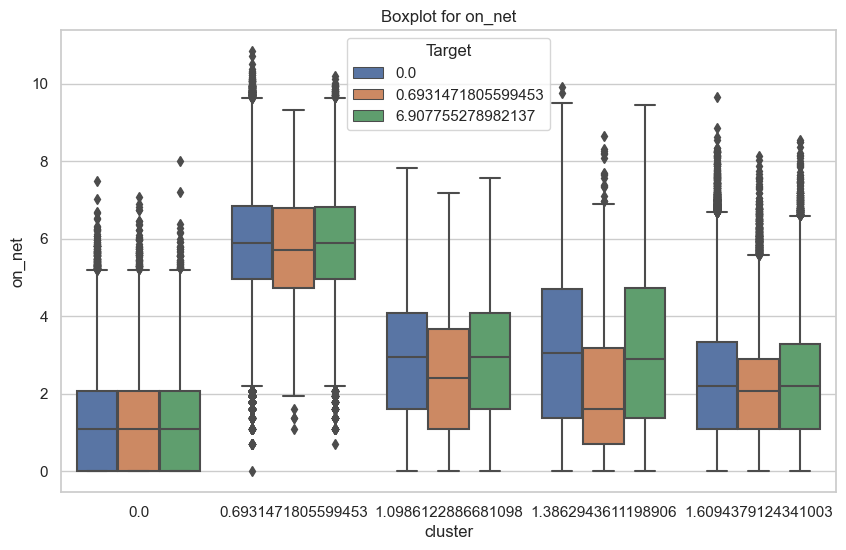

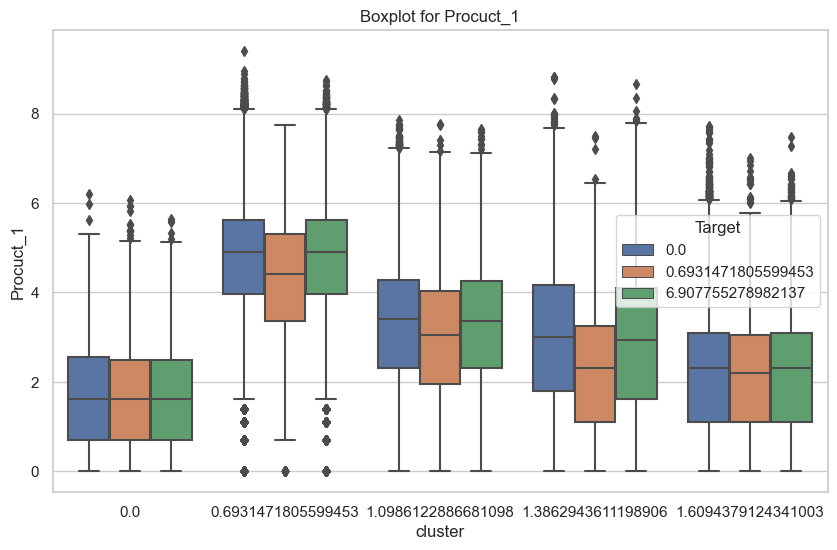

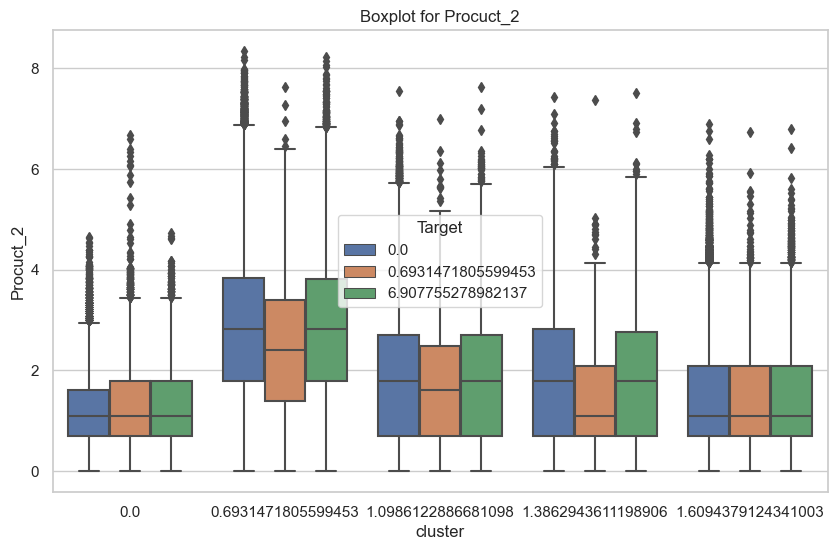

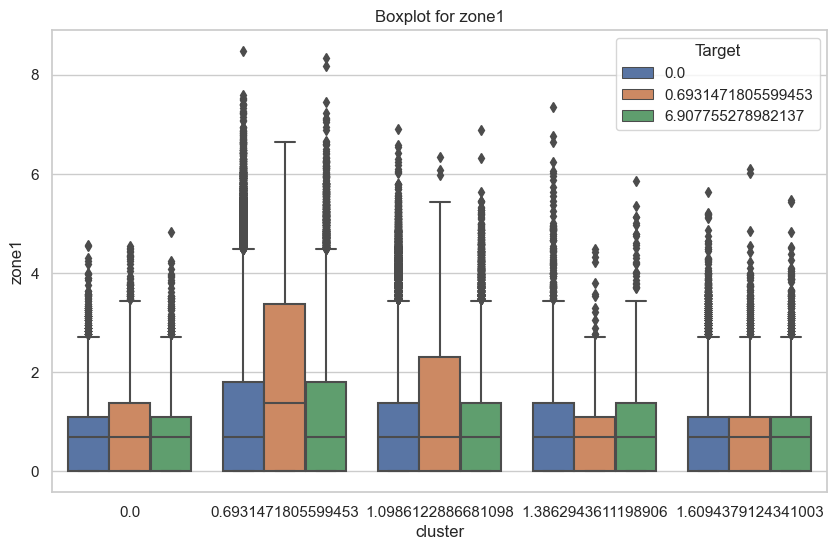

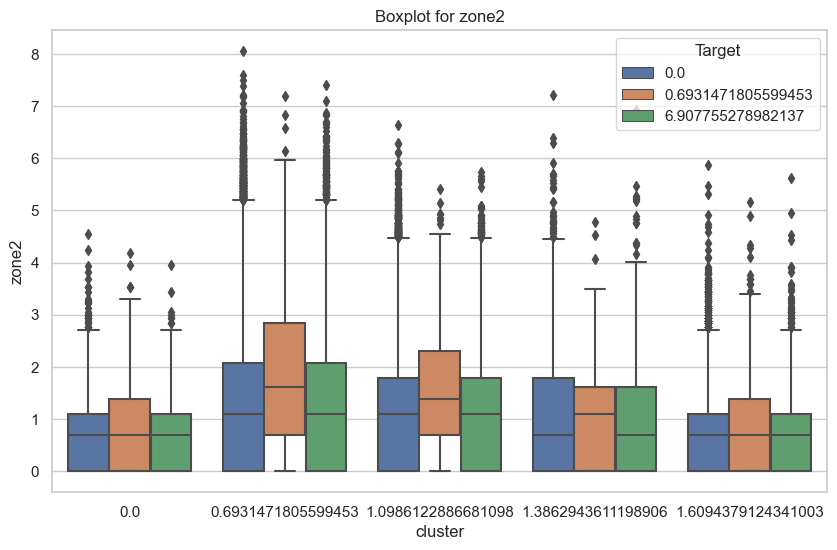

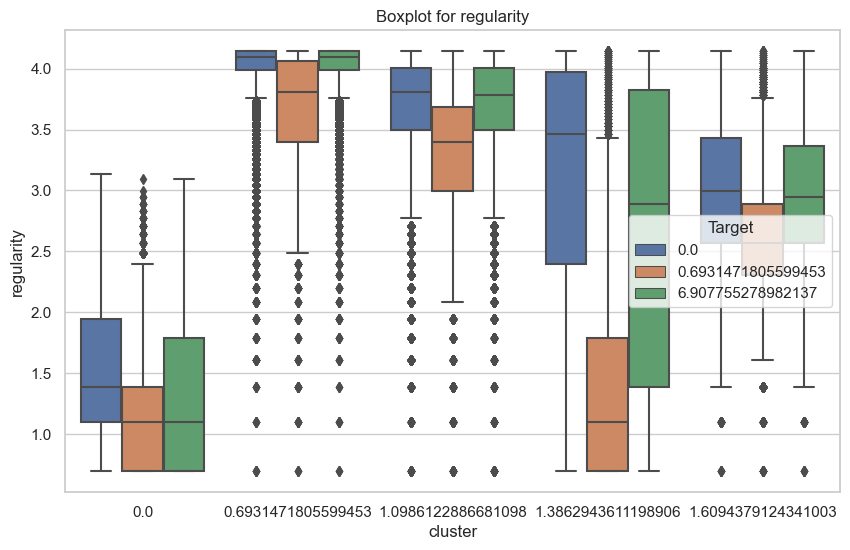

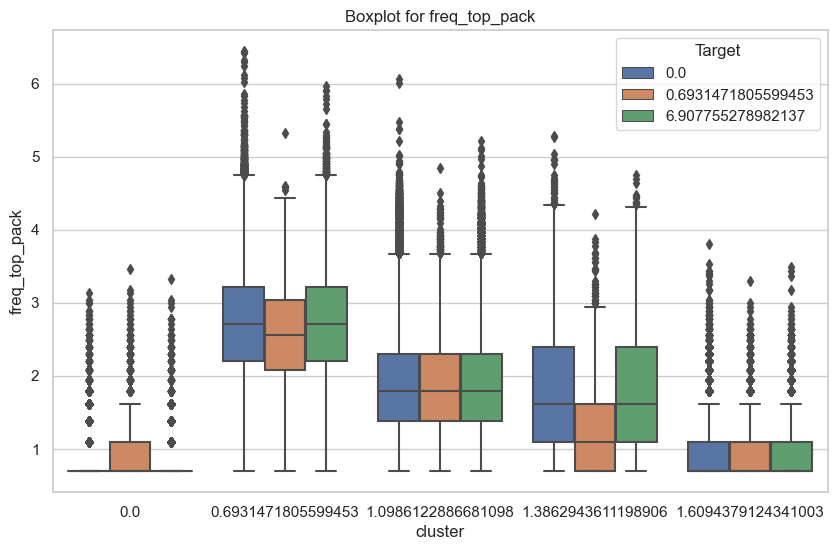

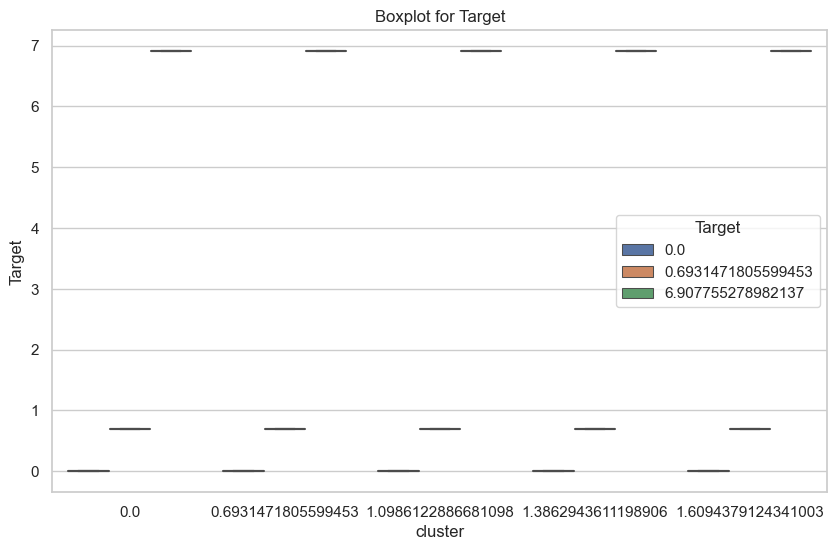

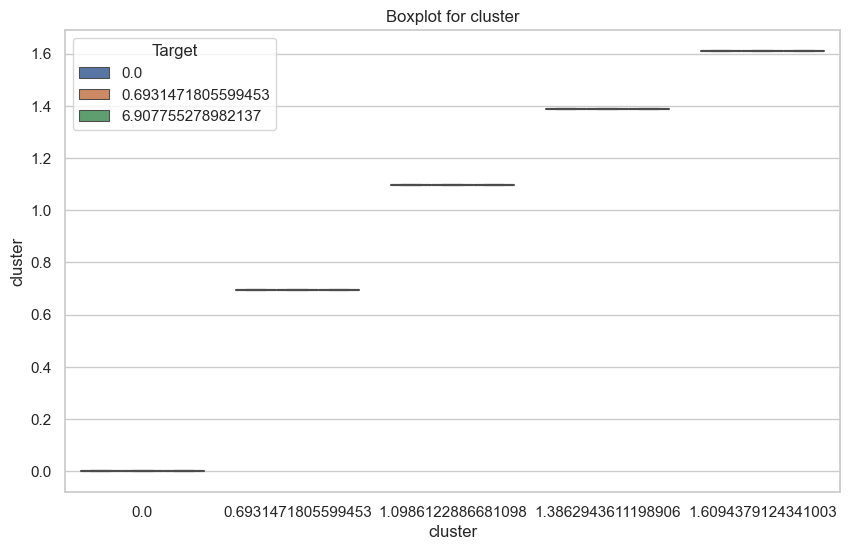

In [ ]:
features_to_plot = log_eda_df.columns
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.boxplot(x='cluster', y=feature, data=log_eda_df,hue='Target')
    plt.title(f'Boxplot for {feature}')
    plt.show()

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1887961 entries, ID_YEB05X4KUGPQ to ID_2F6Y446GS8T3
Data columns (total 19 columns):
 #   Column            Dtype  
---  ------            -----  
 0   region            object 
 1   tenure            int64  
 2   Amount            float64
 3   refill_frequency  float64
 4   revenue           float64
 5   arpu_segment      float64
 6   frequency         float64
 7   data_volume       float64
 8   on_net            float64
 9   Procuct_1         float64
 10  Procuct_2         float64
 11  zone1             float64
 12  zone2             float64
 13  mrg               object 
 14  regularity        int64  
 15  top_pack          object 
 16  freq_top_pack     float64
 17  Target            int32  
 18  cluster           int32  
dtypes: float64(12), int32(2), int64(2), object(3)
memory usage: 338.2+ MB


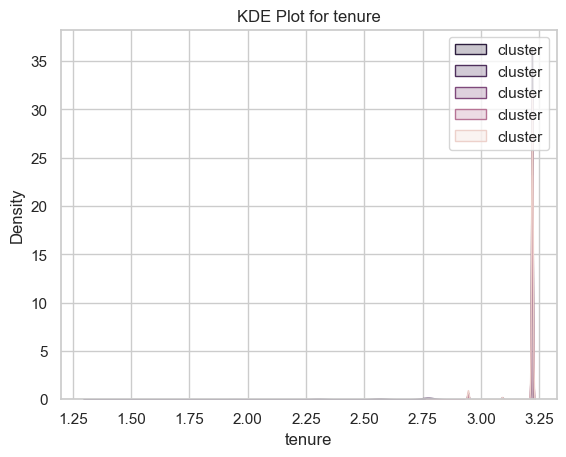

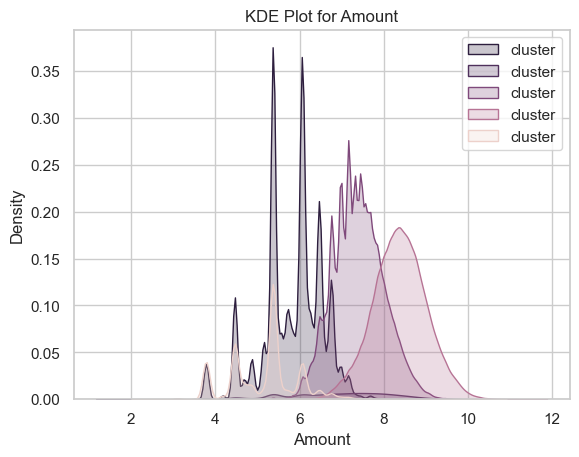

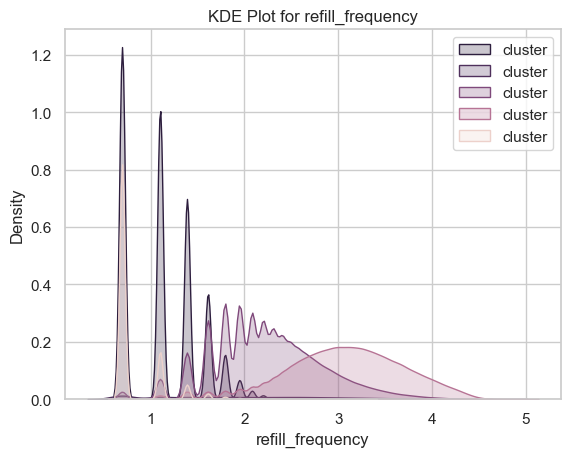

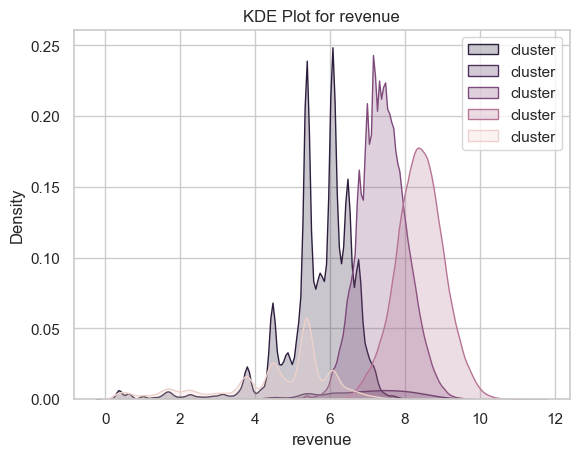

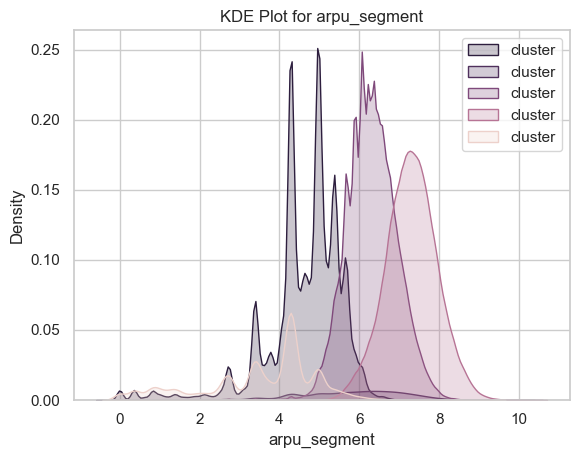

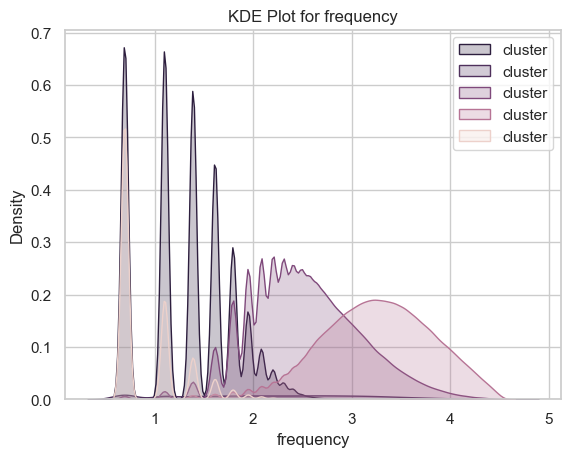

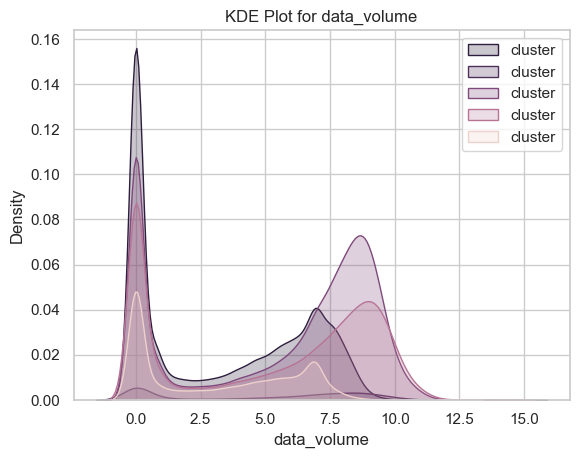

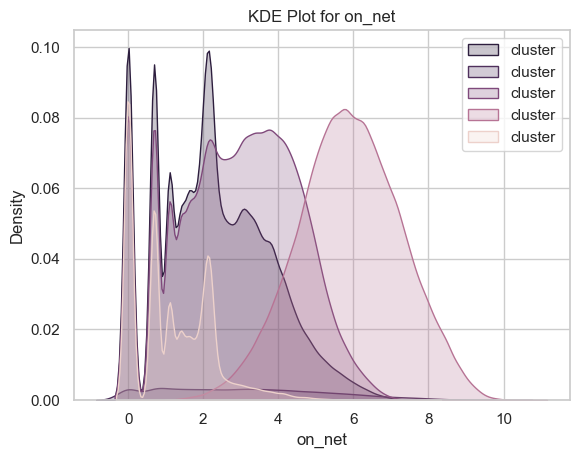

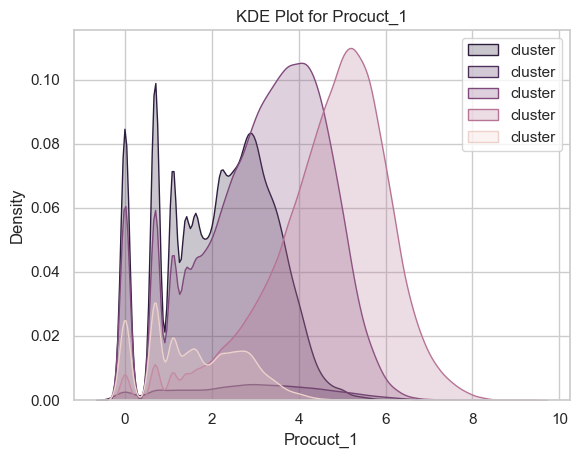

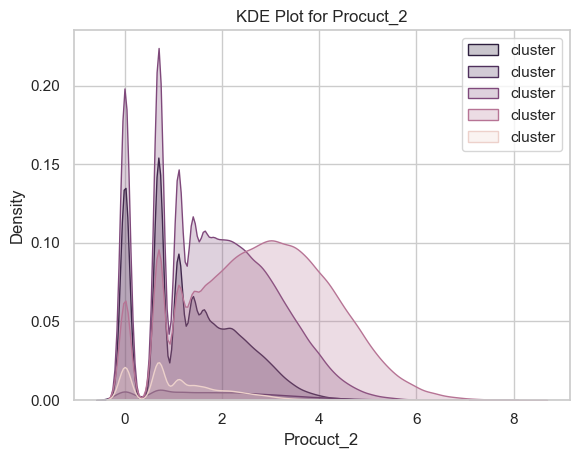

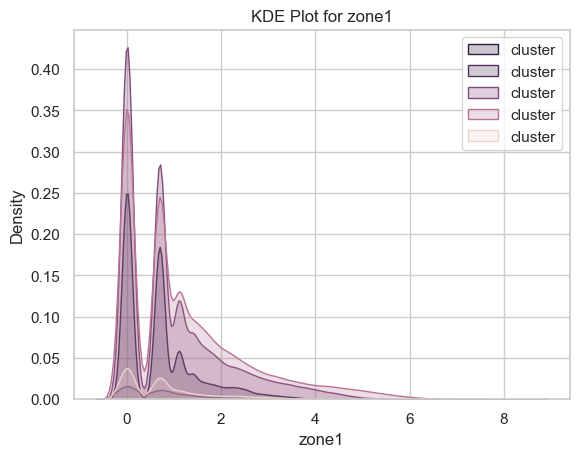

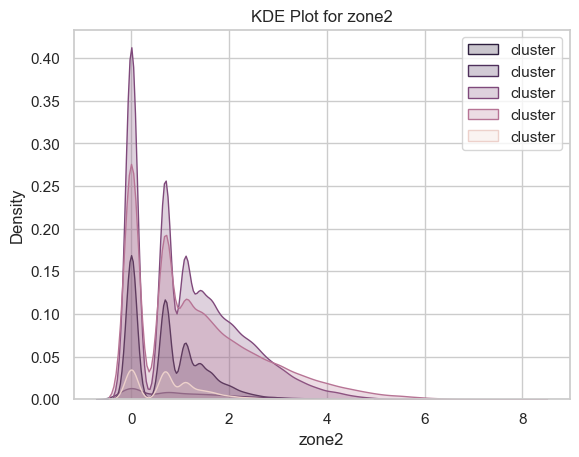

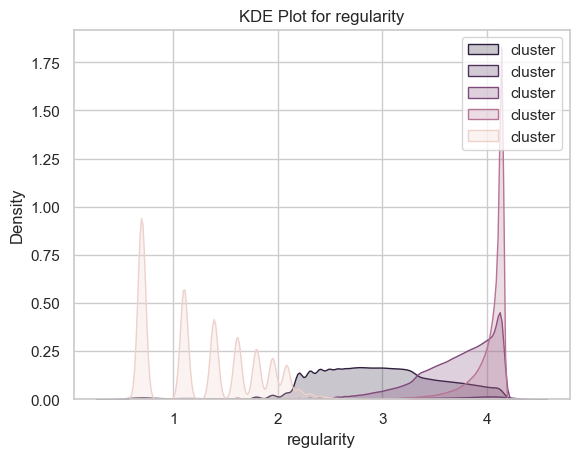

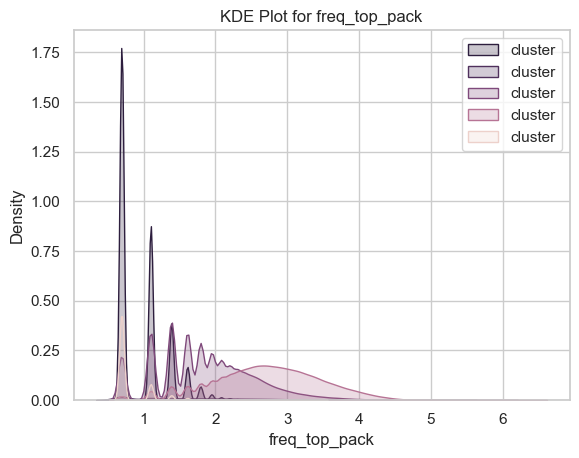

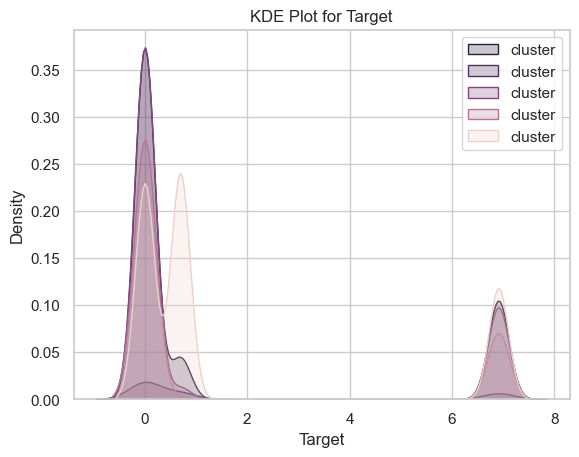

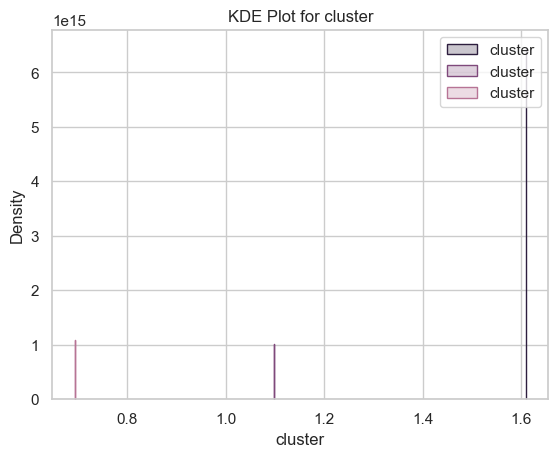

In [ ]:
log_eda_df = np.log(raw_df.iloc[:,1:19].copy().drop(columns =['top_pack','mrg'])+1)
for column in log_eda_df.columns:
    sns.kdeplot(data=log_eda_df, x=log_eda_df[column], label='cluster', shade=True,hue='cluster')
    plt.title(f'KDE Plot for {column}')
    plt.legend()
    plt.show()

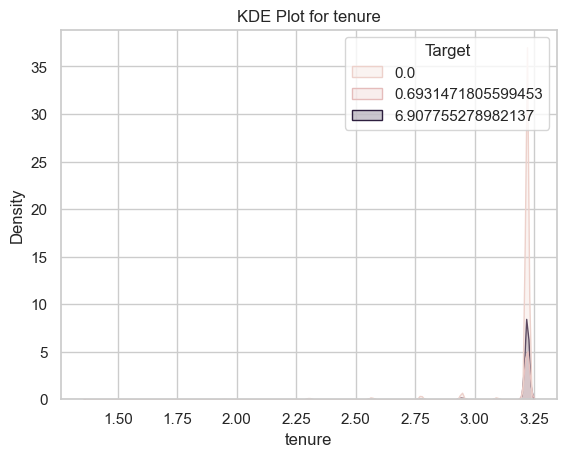

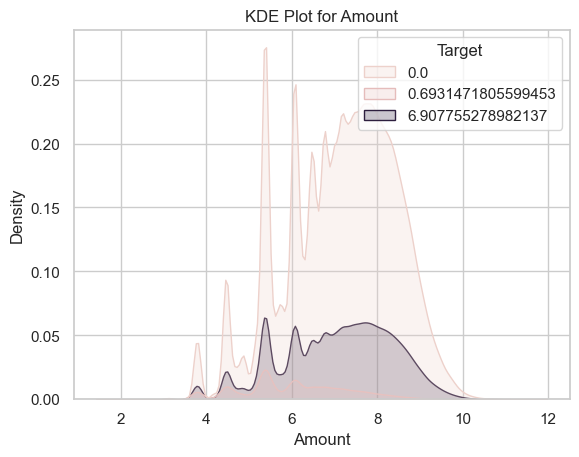

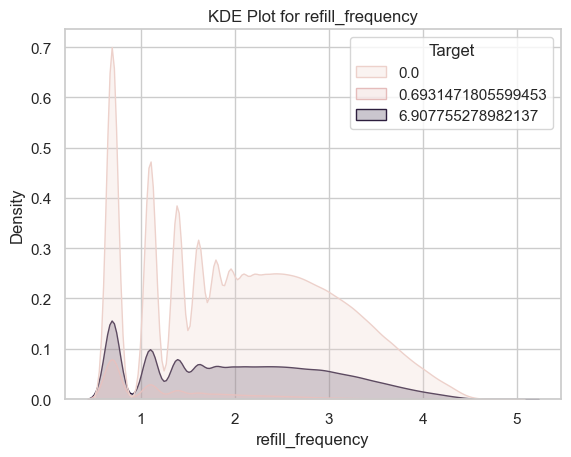

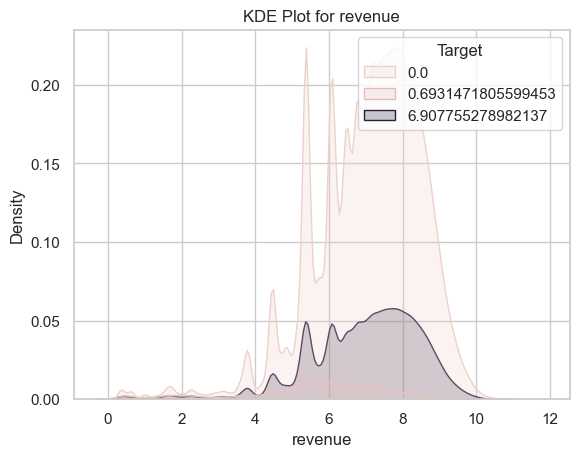

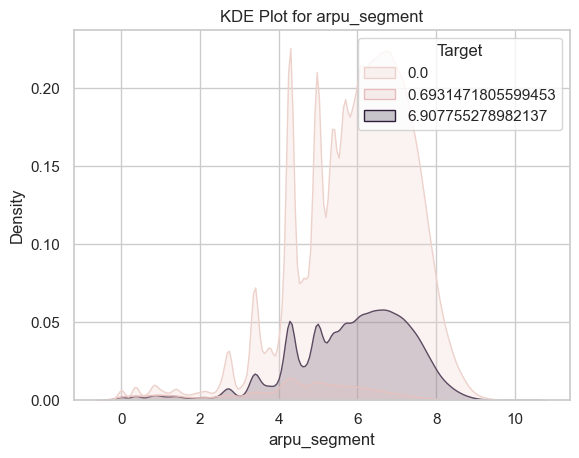

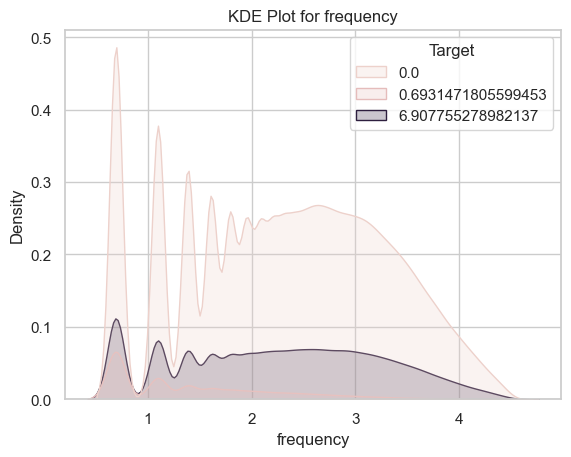

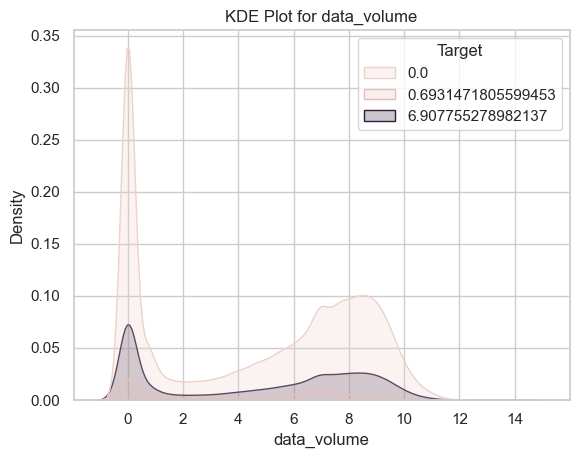

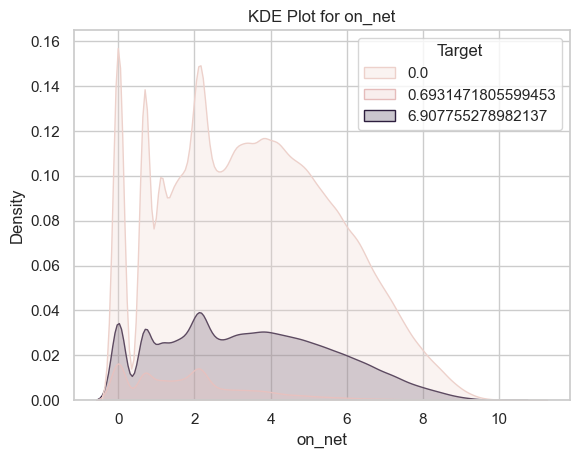

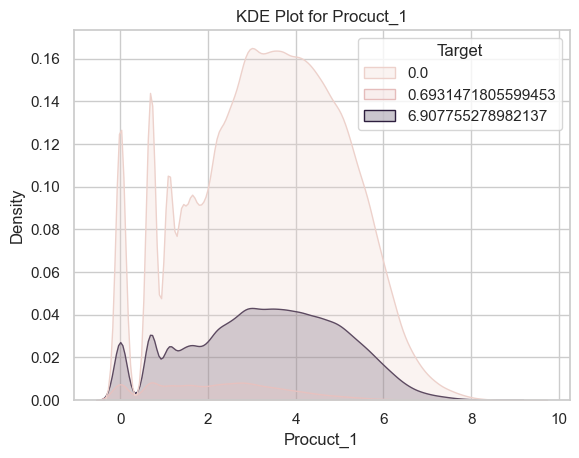

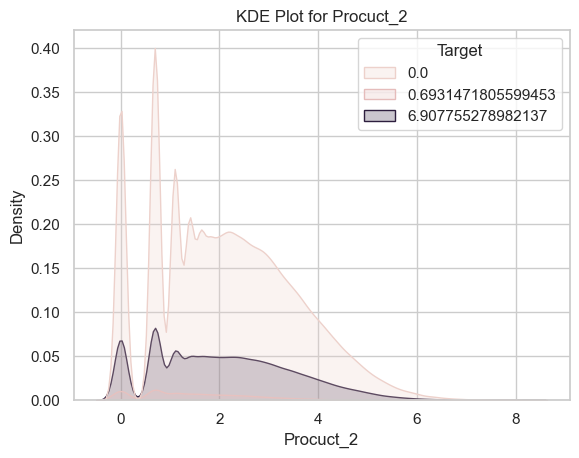

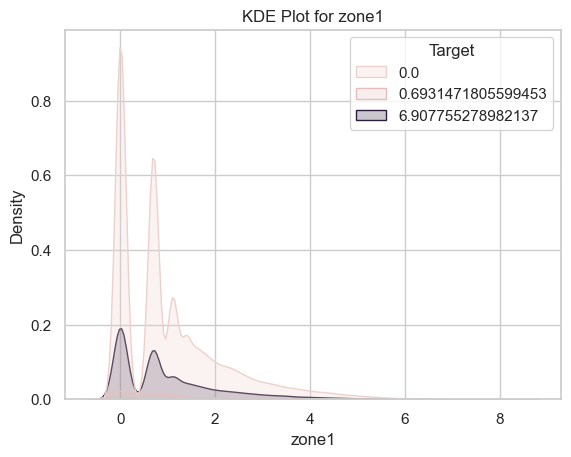

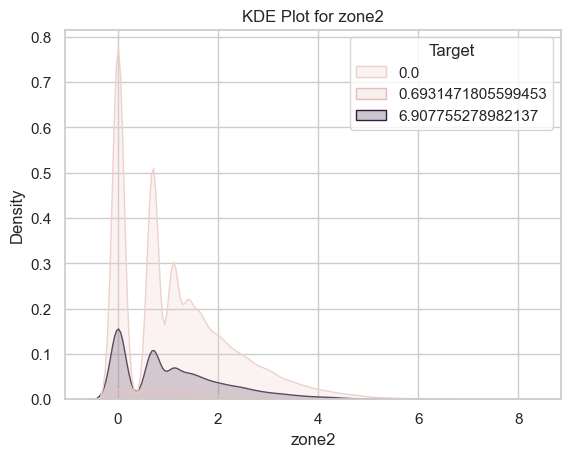

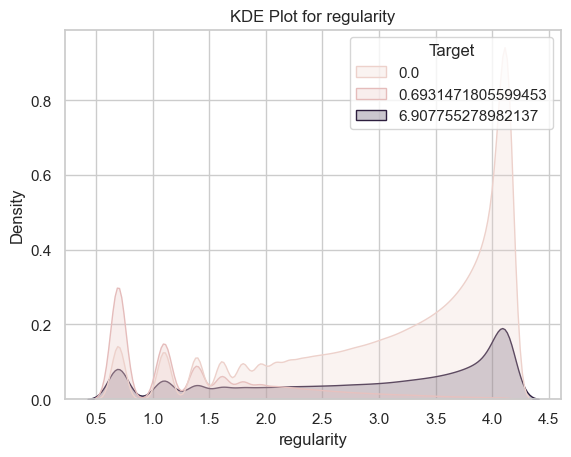

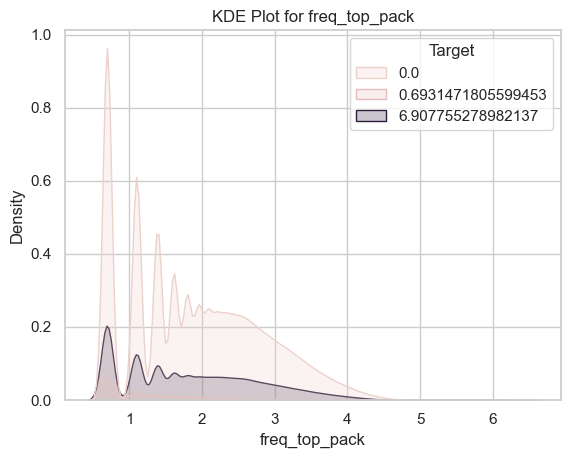

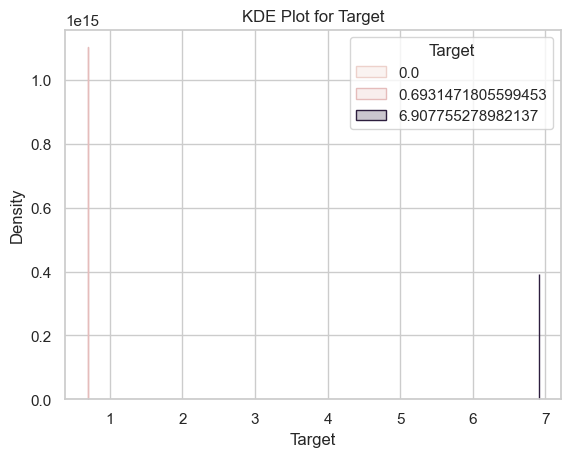

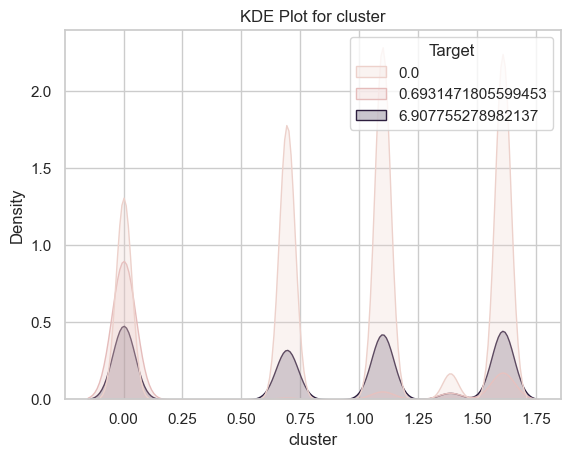

In [ ]:
for column in log_eda_df.columns:
    sns.kdeplot(data=log_eda_df, x=log_eda_df[column], hue='Target', fill=True)
    plt.title(f'KDE Plot for {column}')
    plt.show()

In [ ]:
raw_df['region']= raw_df['region'].fillna(999).astype(str)

In [ ]:
raw_df

region  tenure   Amount  refill_frequency  revenue  \
ID                                                                       
ID_YEB05X4KUGPQ        999      24      NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.96              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.23              22.0  5769.23   
ID_QS4F5LEX29KM        999      24      NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.88              58.0  5636.75   
...                    ...     ...      ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.50              19.0  4487.18   
ID_XGDT520DFBLP        999      24  6901.71              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24      NaN               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.69               9.0  2264.53   
ID_2F6Y446GS8T3        999      24      NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  \
ID                                                                         
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0   
...                       ...        ...          ...     ...        ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN   

                 Procuct_2  zone1  zone2 mrg  regularity  \
ID                                                         
ID_YEB05X4KUGPQ        NaN    NaN    NaN  NO           3   
ID_Z9IQ9QH52KVN        NaN    NaN    NaN  NO          62   
ID_YZSU7B7M35QS        1.0    NaN    NaN  NO          61   
ID_QS4F5LEX29KM        NaN    NaN    NaN  NO           6   
ID_8IYIC9PFU8U1        0.0    NaN    NaN  NO          62   
...                    ...    ...    ...  ..         ...   
ID_MGZSA4ICBD9O       80.0    NaN    NaN  NO          54   
ID_XGDT520DFBLP        5.0    NaN    NaN  NO          59   
ID_9RDB792PB5Q4        NaN    NaN    NaN  NO          43   
ID_KDTJHH8L8Z13       19.0    2.0    NaN  NO          61   
ID_2F6Y446GS8T3        NaN    NaN    NaN  NO           1   

                                       top_pack  freq_top_pack  Target  \
ID                                                                       
ID_YEB05X4KUGPQ                             NaN            NaN       0   
ID_Z9IQ9QH52KVN  On net 200F=Unlimited _call24H           31.0       0   
ID_YZSU7B7M35QS                             NaN            NaN       0   
ID_QS4F5LEX29KM                             NaN            NaN       0   
ID_8IYIC9PFU8U1     Mixt 250F=Unlimited_call24H           31.0       0   
...                                         ...            ...     ...   
ID_MGZSA4ICBD9O           All-net 500F=2000F;5d           20.0     999   
ID_XGDT520DFBLP           Data: 200 F=100MB,24H           33.0     999   
ID_9RDB792PB5Q4                             NaN            NaN     999   
ID_KDTJHH8L8Z13                Data:490F=1GB,7d            5.0     999   
ID_2F6Y446GS8T3                             NaN            NaN     999   

                 cluster  
ID                        
ID_YEB05X4KUGPQ        2  
ID_Z9IQ9QH52KVN        4  
ID_YZSU7B7M35QS        1  
ID_QS4F5LEX29KM        2  
ID_8IYIC9PFU8U1        4  
...                  ...  
ID_MGZSA4ICBD9O        4  
ID_XGDT520DFBLP        4  
ID_9RDB792PB5Q4        0  
ID_KDTJHH8L8Z13        1  


In [ ]:
list1 = raw_df.iloc[:,1:17].drop(columns=['mrg','top_pack']).columns
list1

Index(['tenure', 'Amount', 'refill_frequency', 'revenue', 'arpu_segment',
       'frequency', 'data_volume', 'on_net', 'Procuct_1', 'Procuct_2', 'zone1',
       'zone2', 'regularity', 'freq_top_pack'],
      dtype='object')

In [ ]:
agg_dict = {col: 'mean' for col in list1}
agg_dict.update({'mrg': 'count', 'top_pack': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan})

In [ ]:
test_df2 = raw_df.groupby(['region','Target','cluster']).agg(agg_dict).reset_index()

I want to see what is the differences in the features for cluster = 2 for each target variable

In [ ]:
test_df2 = test_df2[test_df2['cluster']==2]
test_df2.drop(columns='cluster',inplace=True)

In [ ]:
test_df2

region  Target     tenure      Amount  refill_frequency     revenue  \
2           999       0  23.832800  253.145355          1.418910  213.666170   
7           999       1  23.769365  288.482378          1.477318  222.919101   
12          999     999  23.783735  262.647856          1.439926  210.215761   
17       Astral       0  23.899718  210.318015          1.201527  189.687732   
22       Astral       1  23.911017  275.315769          1.403846  229.794490   
27       Astral     999  23.856128  210.562153          1.201389  189.698563   
32    Celestial       0  23.877868  208.391602          1.239952  187.999210   
37    Celestial       1  23.898719  231.286574          1.305556  194.272540   
42    Celestial     999  23.887762  200.323443          1.221491  191.879328   
47     Droidika       0  23.845532  234.170884          1.297750  195.757023   
52     Droidika       1  23.792598  291.126751          1.425868  252.163125   
57     Droidika     999  23.865536  231.006874          1.307207  202.401739   
62    Eclipsara       0  23.824437  208.831991          1.372634  195.082571   
67    Eclipsara       1  23.674208  302.807735          1.624309  251.644945   
72    Eclipsara     999  23.799448  200.678669          1.313609  176.415340   
77      Eternum       0  23.942857  297.080968          1.419355  241.342619   
82      Eternum       1  24.000000  181.627500          1.000000   96.668000   
87      Eternum     999  24.000000  287.493636          1.363636  225.756667   
92   Forcehaven       0  23.896226  281.083273          1.363636  242.114797   
97   Forcehaven       1  23.898305  375.892917          1.333333  345.122500   
102  Forcehaven     999  23.610000  284.528684          1.421053  257.277317   
107    Luminous       0  23.904506  239.772289          1.244423  201.146051   
112    Luminous       1  23.868565  241.212280          1.295337  215.828376   
117    Luminous     999  23.916201  250.808379          1.255009  212.240708   
122   Mandalore       0  23.885529  245.504174          1.373738  209.602150   
127   Mandalore       1  23.832106  367.454697          1.408355  243.059595   
132   Mandalore     999  23.879069  254.945169          1.363687  210.570156   
137      Nebula       0  23.781030  211.497676          1.310185  189.235799   
142      Nebula       1  23.871734  261.755000          1.375000  238.299506   
147      Nebula     999  23.808589  219.513193          1.357143  202.002885   
152    Nebulith       0  23.713190  212.856124          1.282544  169.197394   
157    Nebulith       1  23.758065  309.831667          1.229167  182.932400   
162    Nebulith     999  23.750943  213.618950          1.265193  185.406702   
167      Quasar       0  23.774252  212.463140          1.348578  188.645357   
172      Quasar       1  23.632184  233.176500          1.300000  225.201111   
177      Quasar     999  23.801262  232.416154          1.284615  185.925772   
182  Radiantara       0  23.882637  250.025364          1.383382  204.735808   
187  Radiantara       1  23.907850  245.587200          1.320000  195.930108   
192  Radiantara     999  23.823853  290.422251          1.403141  218.168957   
197   Stellaris       0  23.899038  202.066560          1.260567  177.687778   
202   Stellaris       1  23.872861  246.690200          1.410000  207.462029   
207   Stellaris     999  23.902477  213.661012          1.327381  187.637982   
212  Zodiacalia       0  23.928372  205.070355          1.219737  185.191248   
217  Zodiacalia       1  23.935714  260.248974          1.358974  226.465750   
222  Zodiacalia     999  23.954683  200.691989          1.226519  184.760749   

     arpu_segment  frequency  data_volume     on_net  Procuct_1  Procuct_2  \
2       71.230218   1.796502   403.433590   6.023539   8.620242   3.984580   
7       74.310456   1.831450   431.021019   6.658748   8.996186   6.299170   
12      70.077515   1.815016   414.954848   6.484297   8.567375   4.531520   
17      63.25963

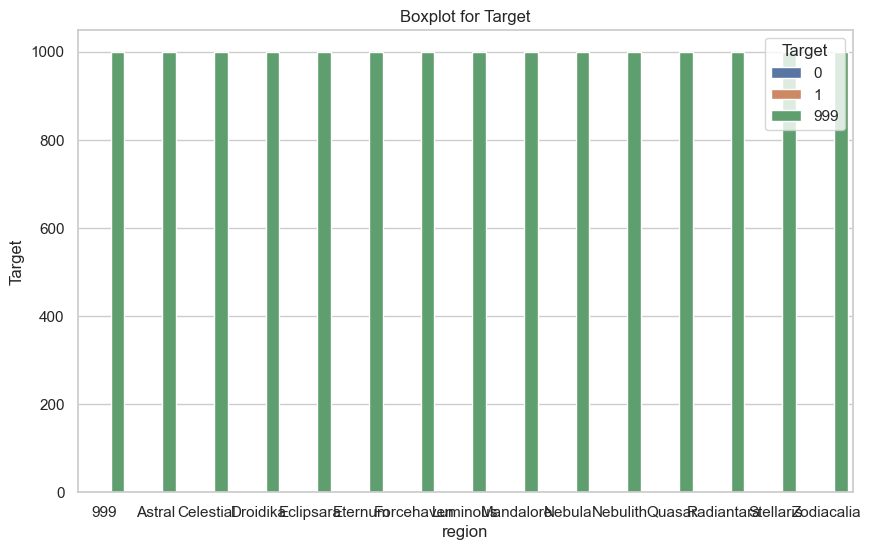

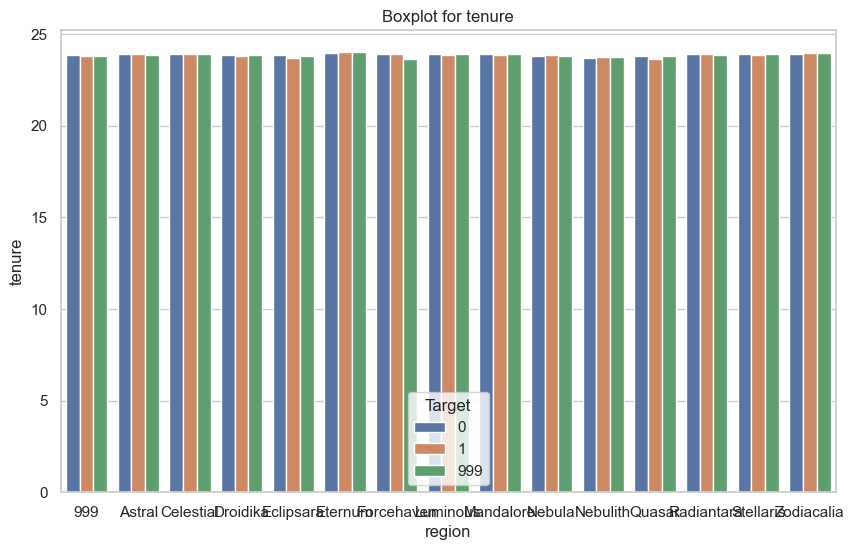

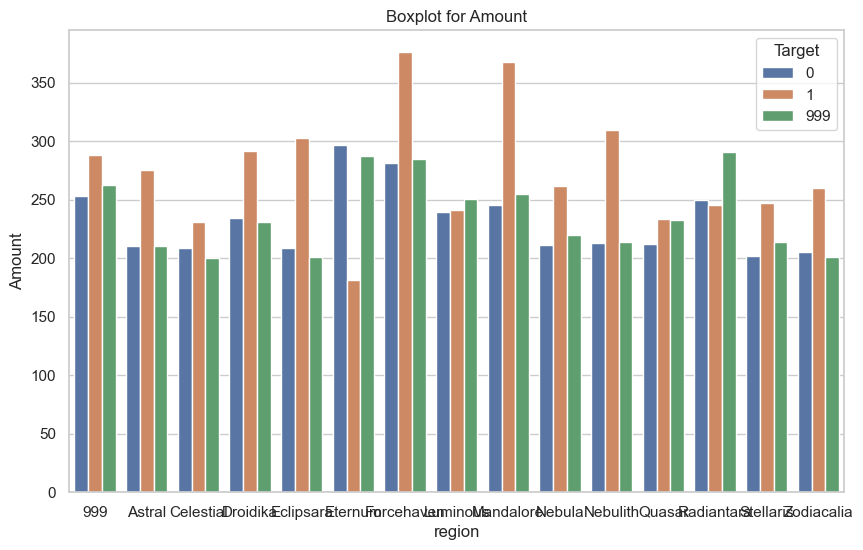

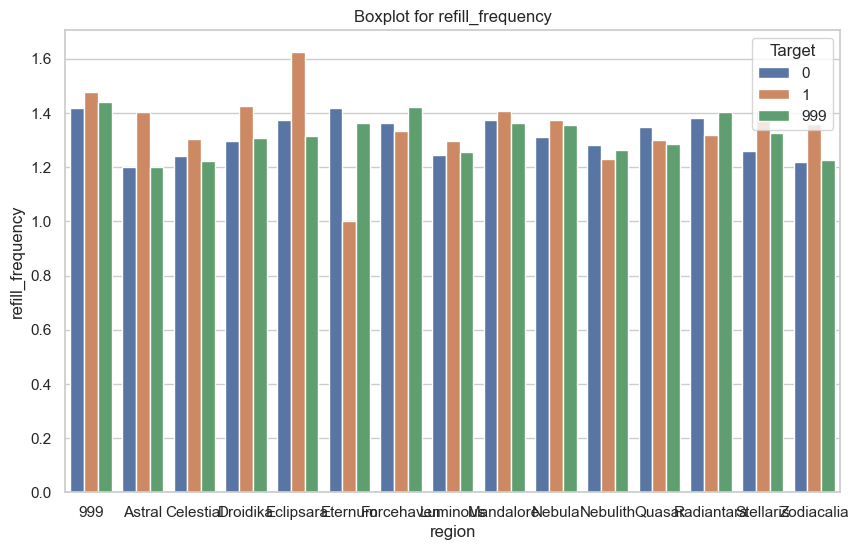

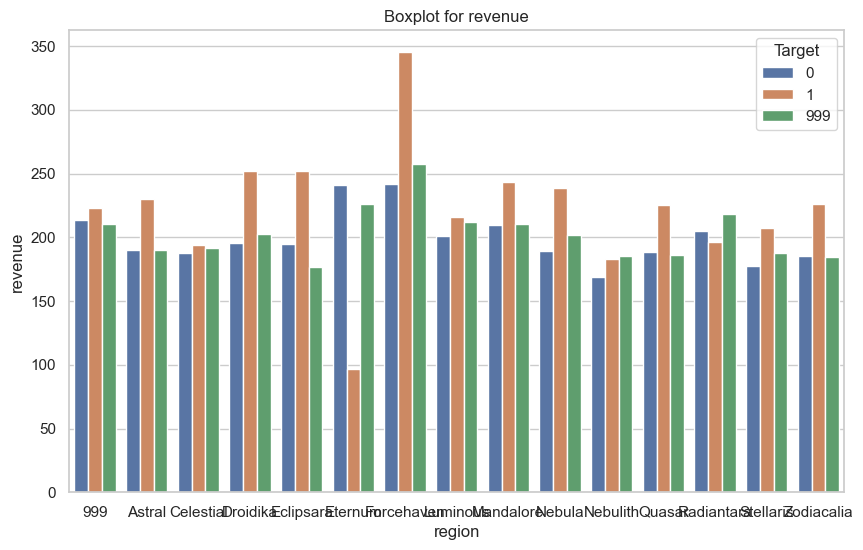

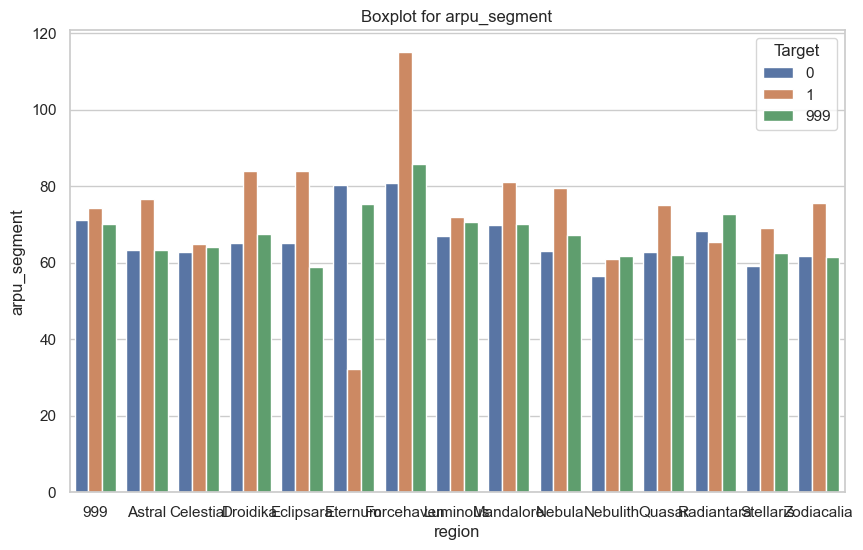

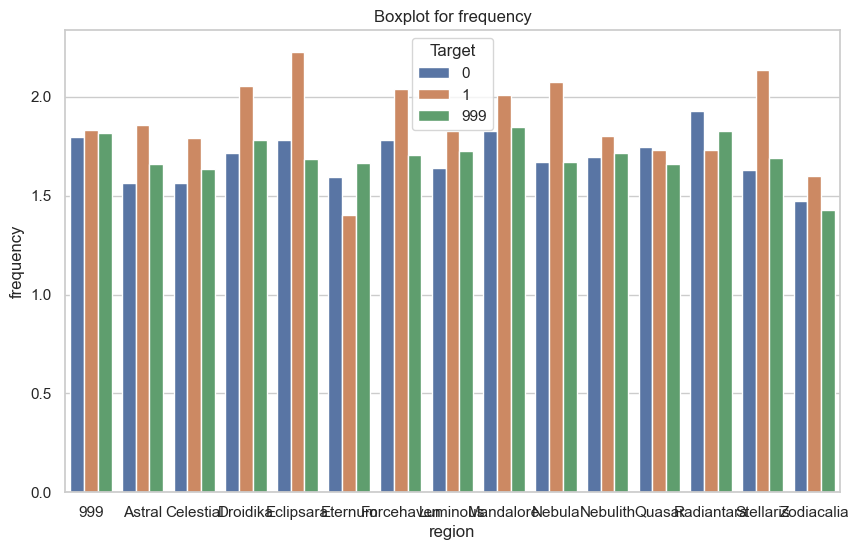

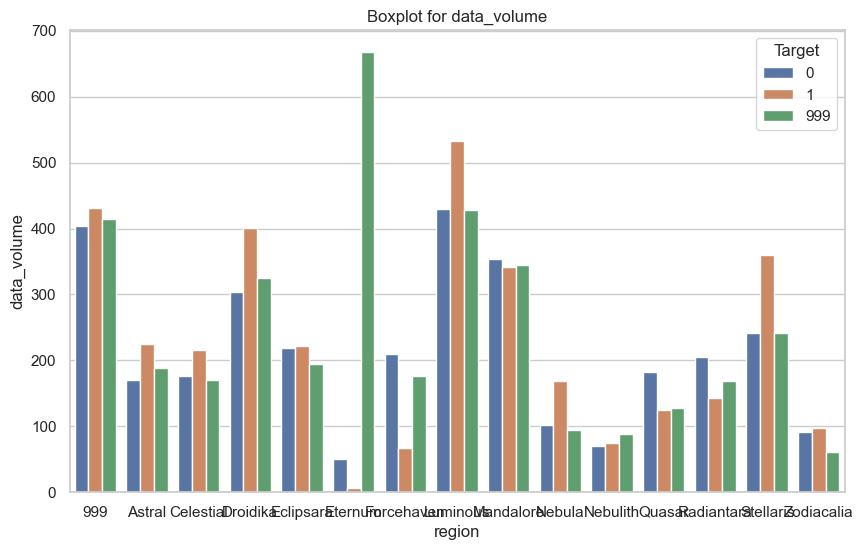

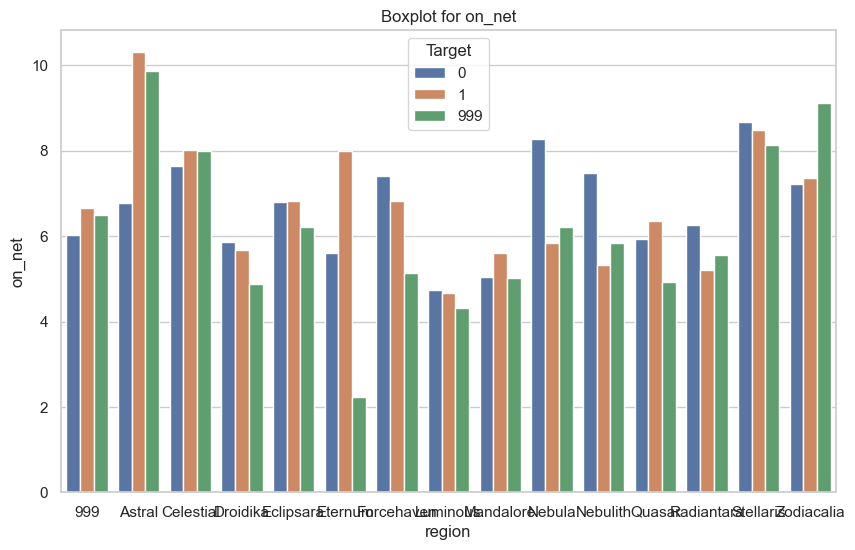

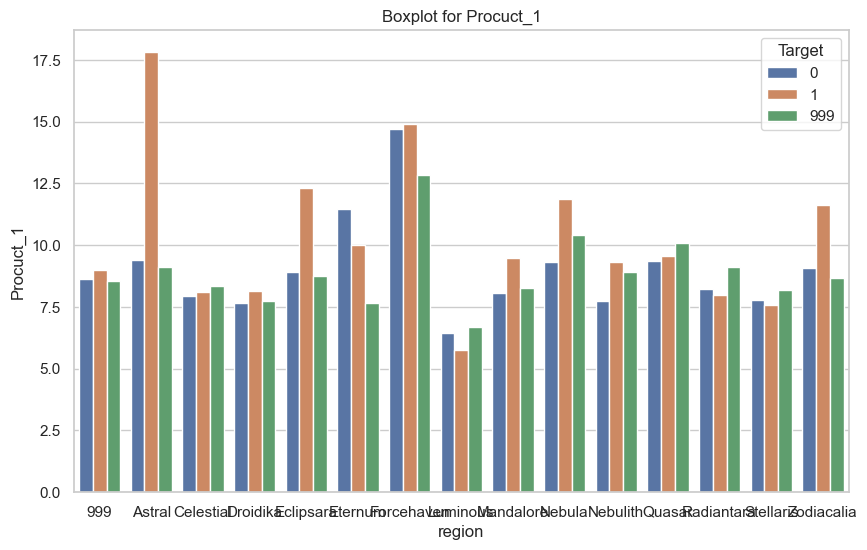

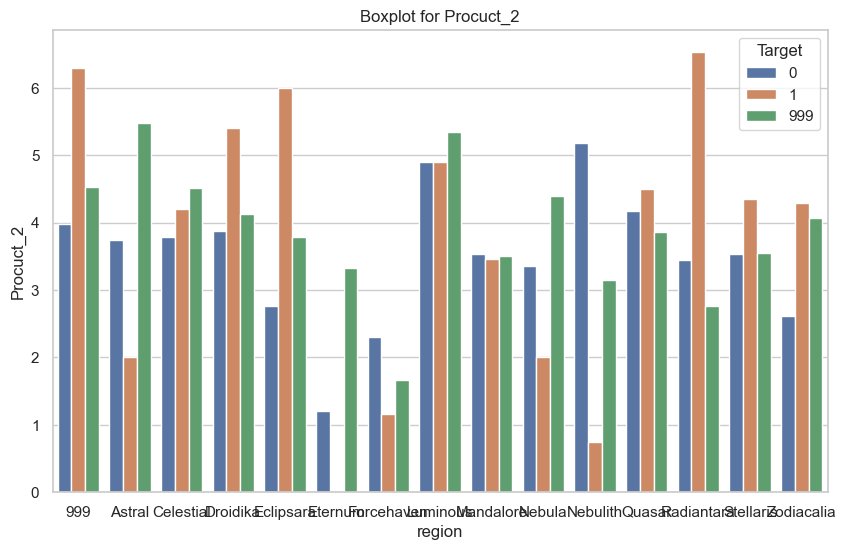

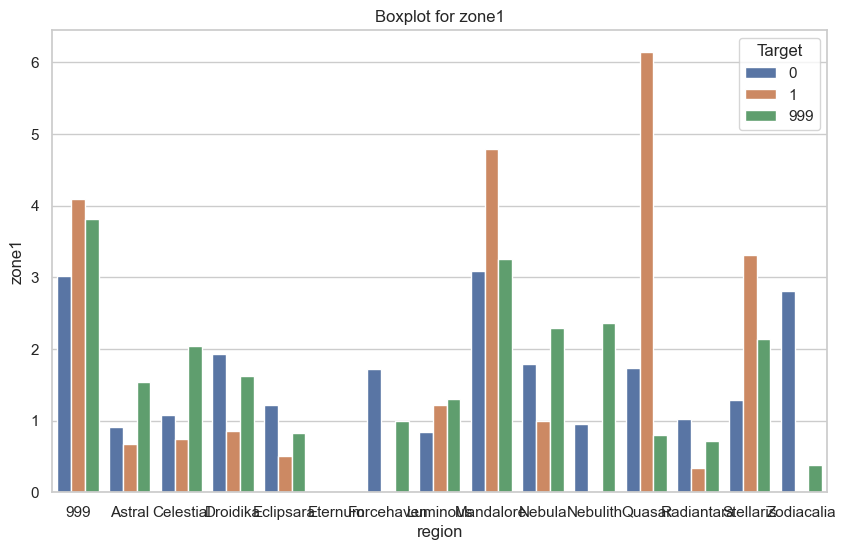

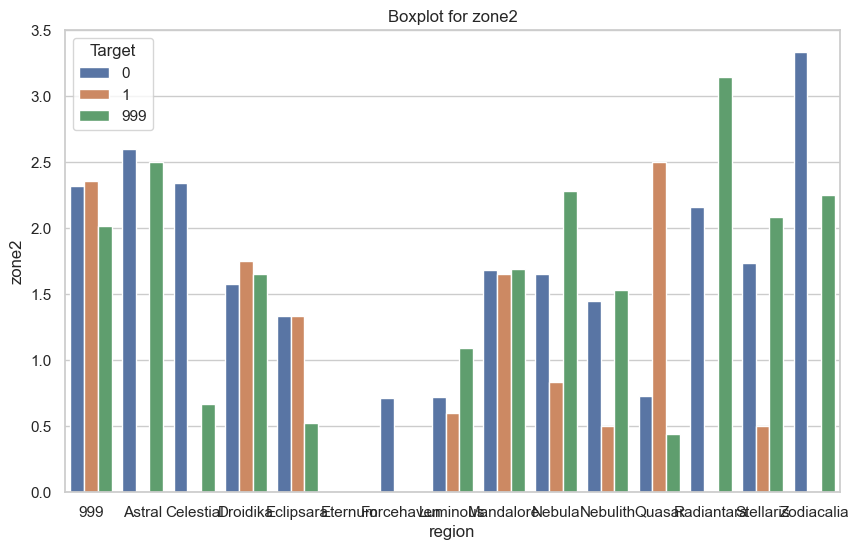

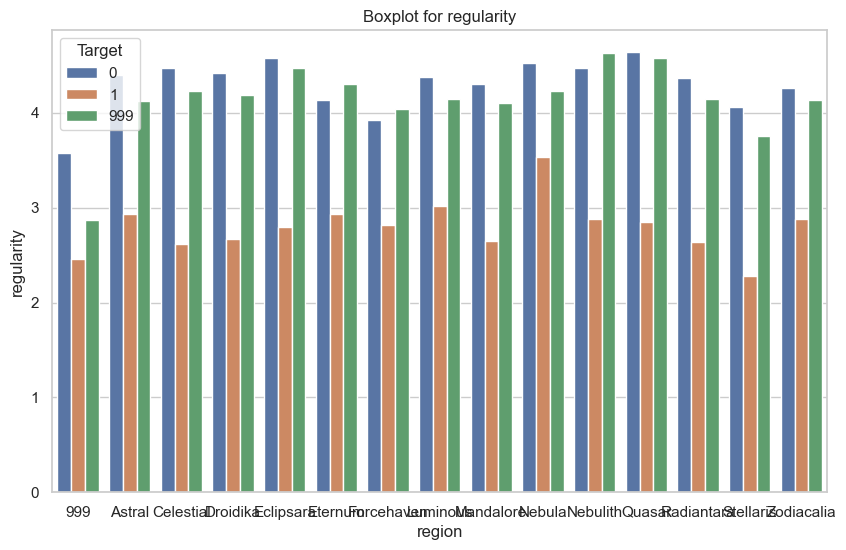

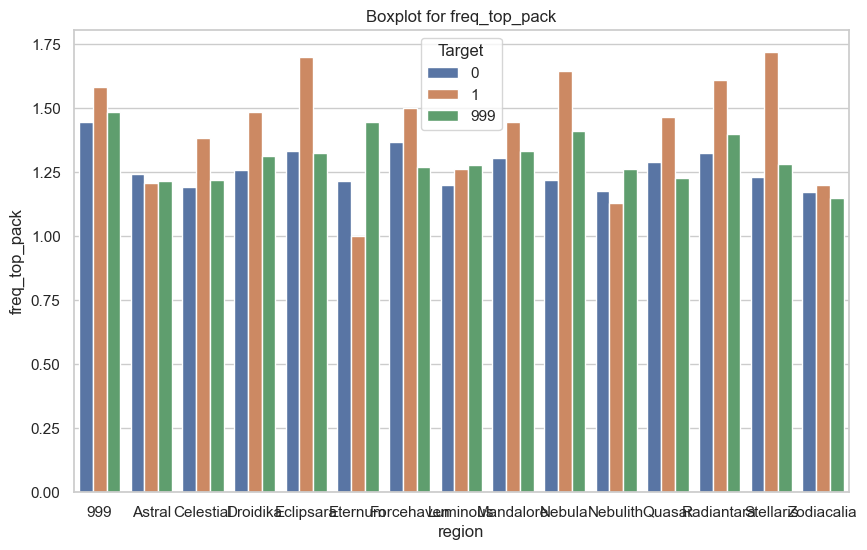

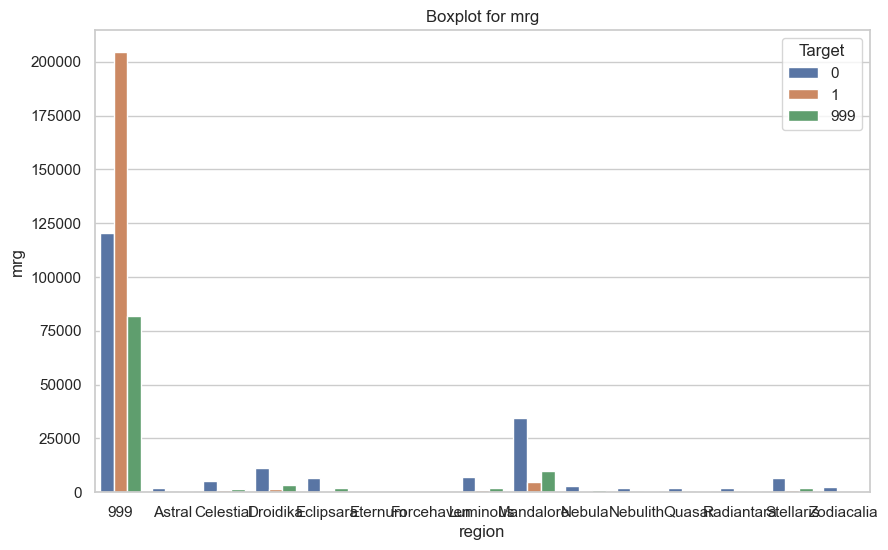

In [ ]:
features_to_plot = test_df2.drop(columns=['region','top_pack']).columns
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.barplot(x='region', y=feature, data=test_df2,hue='Target')
    plt.title(f'Boxplot for {feature}')
    plt.show()

In [ ]:
test_df_2 = raw_df[raw_df['cluster']==2]
test_df_2.drop(columns='cluster',inplace=True)

In [ ]:
test_df_2.isnull().sum()

region                   0
tenure                   0
Amount              436654
refill_frequency    436654
revenue             427272
arpu_segment        427272
frequency           427272
data_volume         436953
on_net              432108
Procuct_1           468136
Procuct_2           505451
zone1               522174
zone2               523474
mrg                      0
regularity               0
top_pack            478301
freq_top_pack       478301
Target                   0
dtype: int64

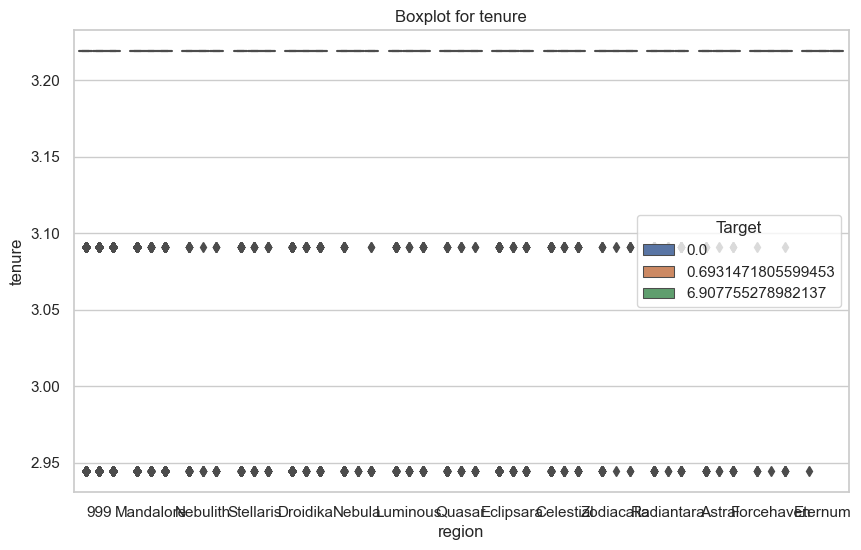

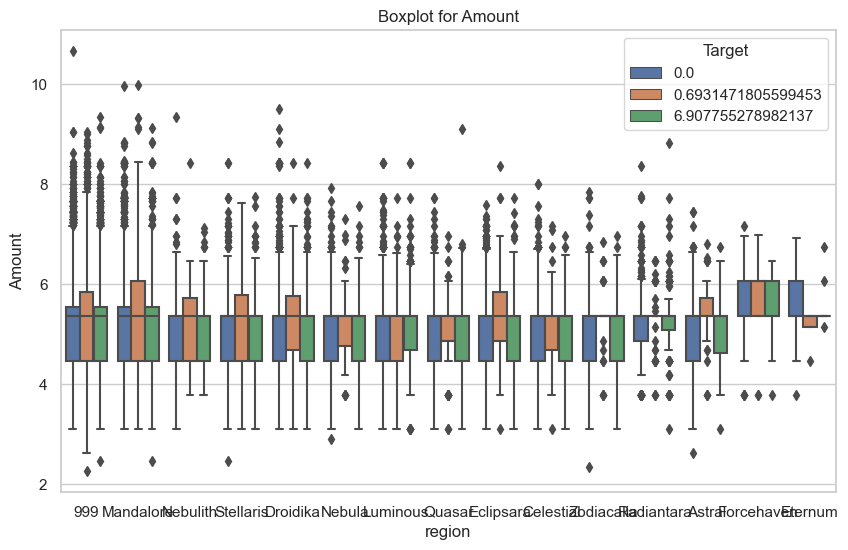

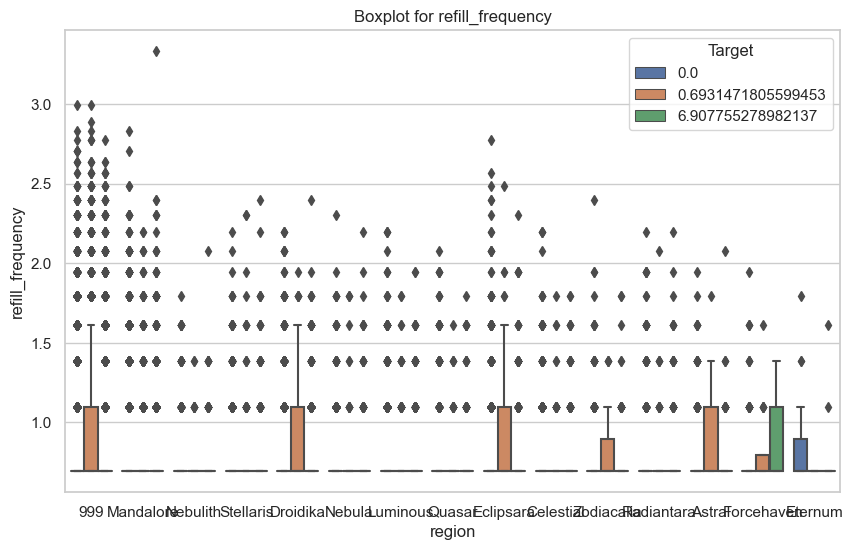

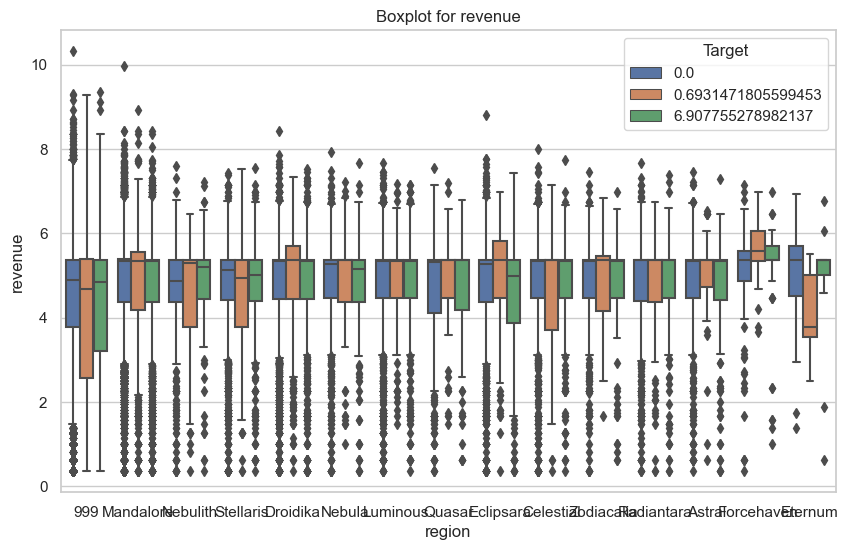

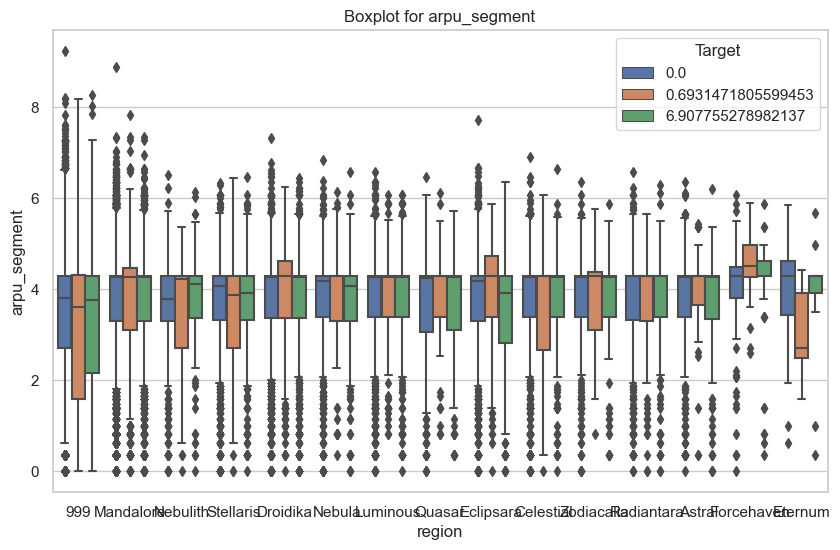

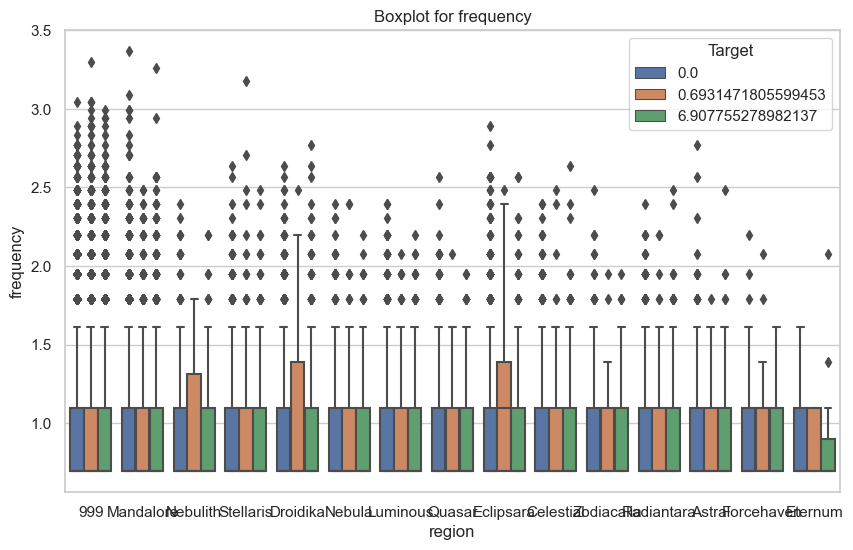

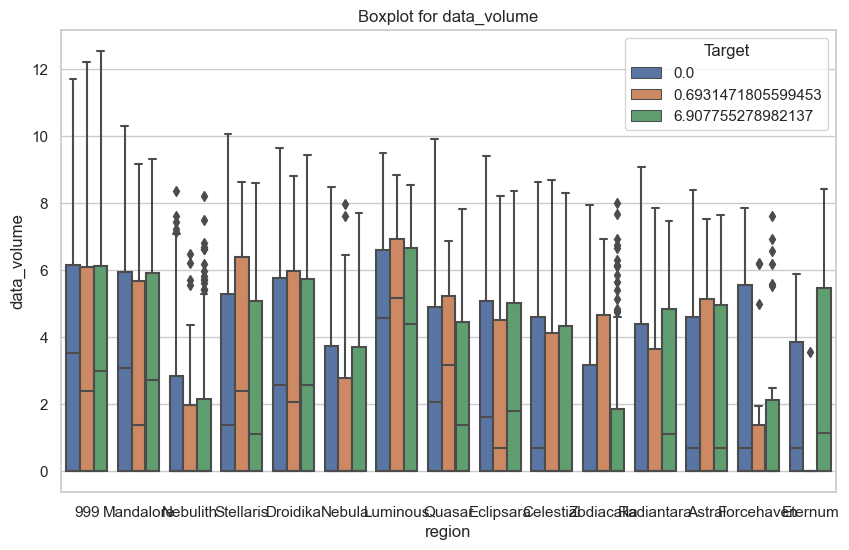

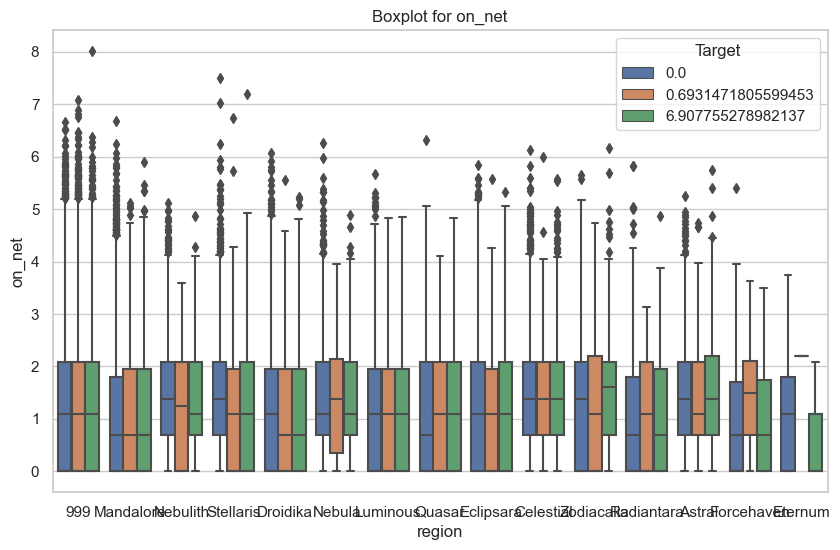

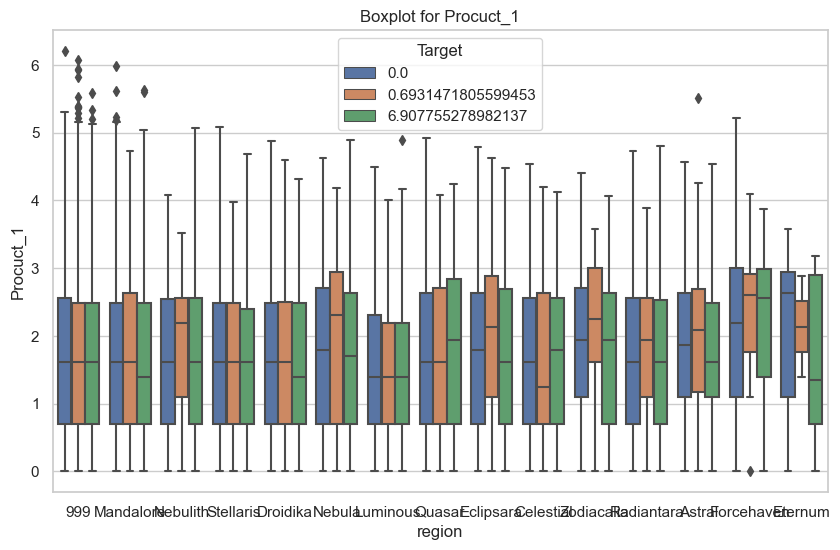

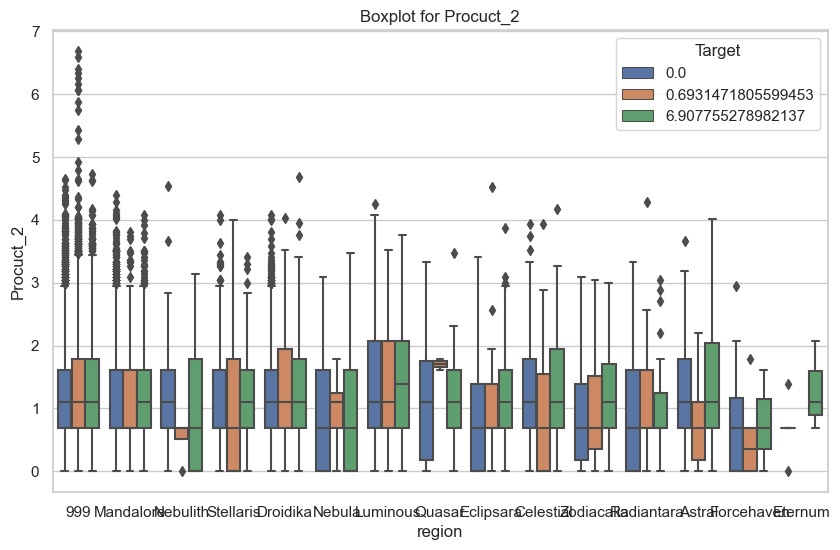

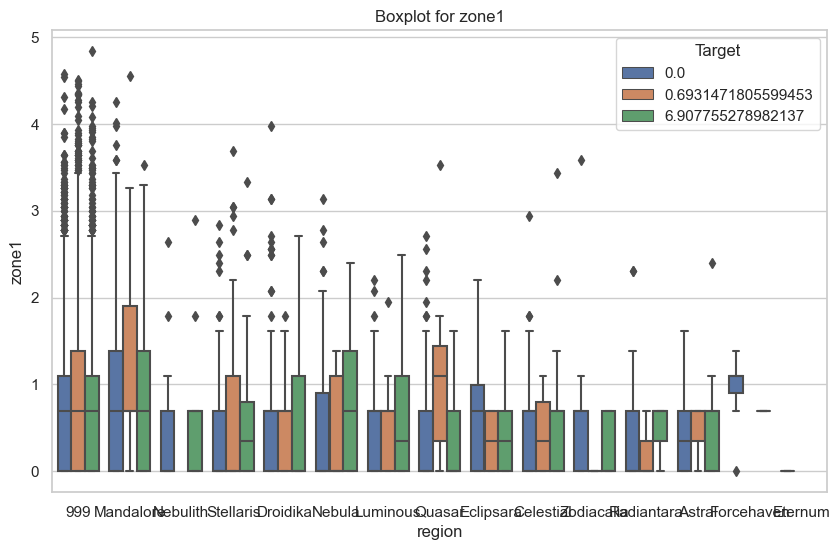

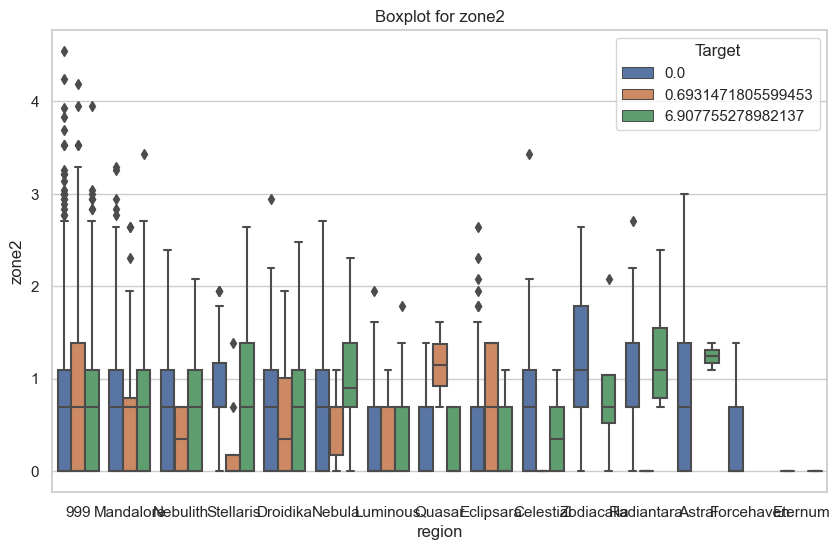

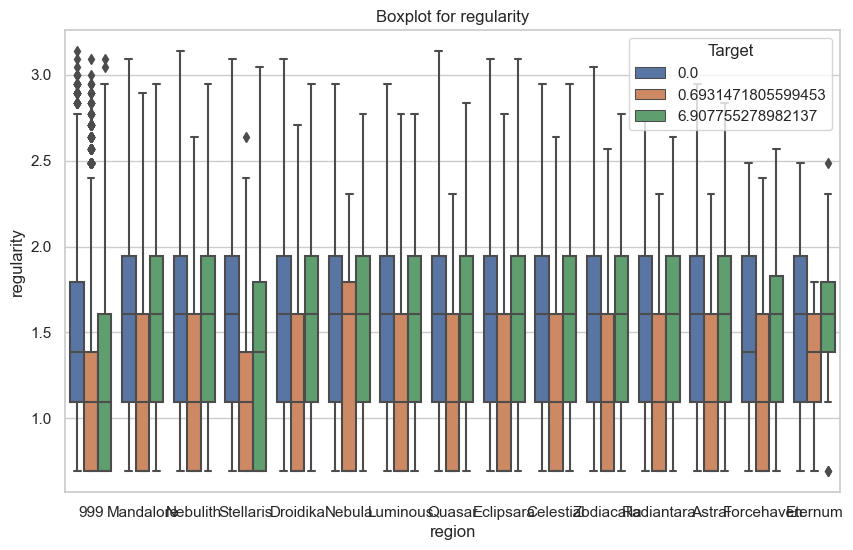

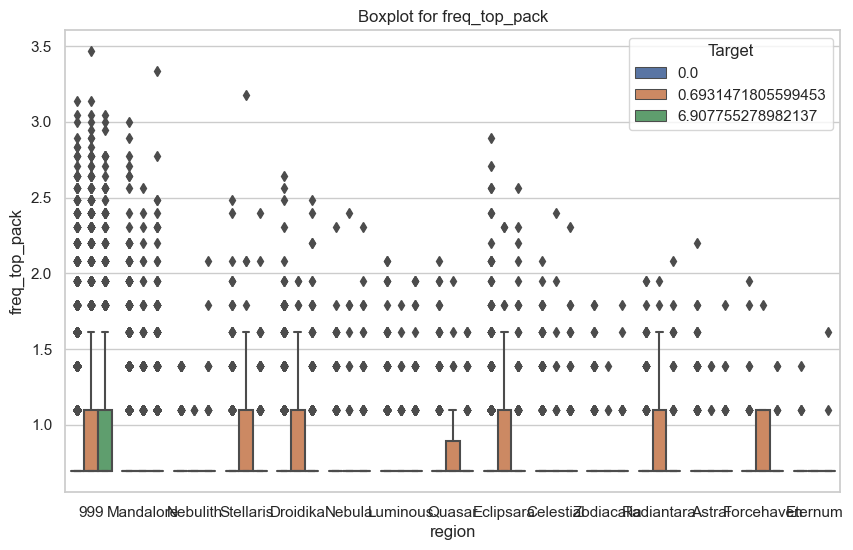

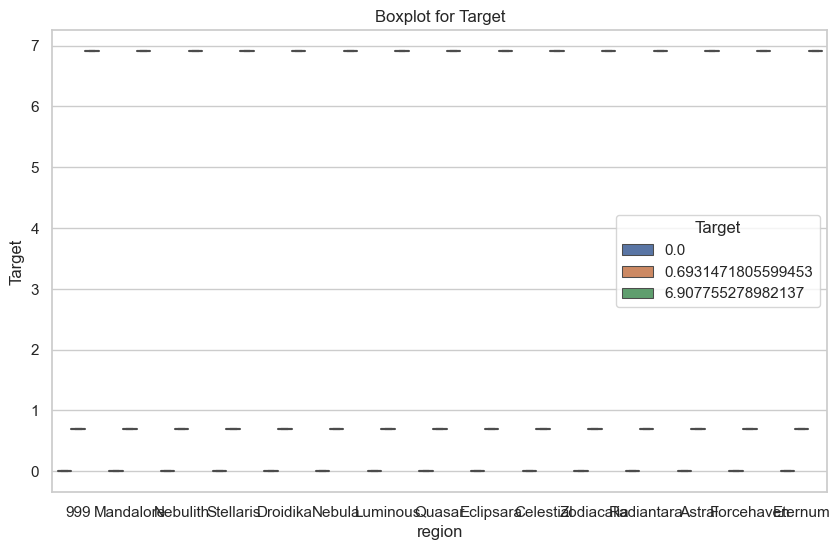

In [ ]:
features_to_plot = test_df_2.drop(columns=['region','top_pack','mrg']).columns
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.boxplot(x=test_df_2['region'], y=feature, data=np.log(test_df_2.select_dtypes(include=[np.number])+1),hue='Target')
    plt.title(f'Boxplot for {feature}')
    plt.show()

In [24]:
raw_df.groupby('top_pack').mean()

tenure        Amount  refill_frequency  \
top_pack                                                              
1000=Unlimited7Day        24.000000   2179.488462          6.461538   
1500=Unlimited7Day        24.000000    854.700000          1.000000   
150=unlimited pilot auto  24.000000    854.700000          2.000000   
200=Unlimited1Day         23.704000   3916.955383         26.031139   
200F=10mnOnNetValid1H     23.206897   1150.540000          8.428571   
...                             ...           ...               ...   
Yewouleen_PKG             24.000000   3430.514054          2.289189   
pack_chinguitel_24h       24.000000  12299.144000         16.400000   
pilot_offer4              24.000000    641.030000          1.000000   
pilot_offer6              24.000000    502.137500          2.000000   
pilot_offer7              24.000000    427.350000          1.000000   

                               revenue  arpu_segment  frequency  data_volume  \
top_pack                                                                       
1000=Unlimited7Day         2425.444615    808.447692  11.230769  1790.083333   
1500=Unlimited7Day          854.270000    284.620000   3.000000   289.000000   
150=unlimited pilot auto    335.470000    111.970000   3.500000    12.000000   
200=Unlimited1Day          3976.567831   1325.528196  30.186667  3210.231847   
200F=10mnOnNetValid1H      1132.964828    377.684483   9.333333   418.600000   
...                                ...           ...        ...          ...   
Yewouleen_PKG              3541.345833   1180.468788   5.328283  1604.619048   
pack_chinguitel_24h       10636.068000   3545.384000  22.600000  3924.333333   
pilot_offer4                641.030000    213.680000   1.000000  2508.000000   
pilot_offer6                501.815000    167.202500   2.000000   345.333333   
pilot_offer7                423.080000    141.030000   1.000000  1434.000000   

                               on_net   Procuct_1  Procuct_2      zone1  \
top_pack                                                                  
1000=Unlimited7Day         343.384615  106.538462   9.090909   0.500000   
1500=Unlimited7Day          89.000000   49.000000  10.000000        NaN   
150=unlimited pilot auto          NaN         NaN        NaN        NaN   
200=Unlimited1Day         1074.342576  227.835409  38.641879   4.067308   
200F=10mnOnNetValid1H       88.425000   52.594937  11.346154   1.769231   
...                               ...         ...        ...        ...   
Yewouleen_PKG              482.209596  183.775510  22.568116  10.132353   
pack_chinguitel_24h         71.500000   45.750000  14.500000        NaN   
pilot_offer4                      NaN   38.000000        NaN        NaN   
pilot_offer6                12.333333   33.000000   6.000000        NaN   
pilot_offer7                 0.000000   61.000000  16.000000        NaN   

                               zone2  regularity  freq_top_pack      Target  \
top_pack                                                                      
1000=Unlimited7Day               NaN   49.769231       1.615385  384.230769   
1500=Unlimited7Day               NaN   48.000000       1.000000    0.000000   
150=unlimited pilot auto         NaN    8.500000       4.500000    0.500000   
200=Unlimited1Day           6.652174   53.750222      12.453333  202.471111   
200F=10mnOnNetValid1H       3.625000   26.218391       4.114943  160.816092   
...                              ...         ...            ...         ...   
Yewouleen_PKG               1.883721   41.101010       1.131313  199.313131   
pack_chinguitel_24h       146.200000   26.200000       7.600000  599.400000   
pilot_offer4                     NaN   23.000000       1.000000    0.000000   
pilot_offer6                     NaN   18.750000       1.000000  249.750000   
pilot_offer7                     NaN   14.000000       1.000000    1.000000   

                           cluster  
top_pack               

In [25]:
raw_df['Target'].value_counts()

0      1225319
999     380127
1       282515
Name: Target, dtype: int64

In [13]:
raw_df['pct_top_refill'] = raw_df['freq_top_pack']/raw_df['frequency']
raw_df['pct_of_refill'] = raw_df['refill_frequency']/raw_df['frequency']
raw_df['pct_revenue'] = raw_df['revenue']/raw_df['frequency']
raw_df

In [14]:
raw_df

region  tenure   Amount  refill_frequency  revenue  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN      24      NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.96              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.23              22.0  5769.23   
ID_QS4F5LEX29KM        NaN      24      NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.88              58.0  5636.75   
...                    ...     ...      ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.50              19.0  4487.18   
ID_XGDT520DFBLP        NaN      24  6901.71              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24      NaN               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.69               9.0  2264.53   
ID_2F6Y446GS8T3        NaN      24      NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  ...  \
ID                                                                        ...   
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN  ...   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0  ...   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN  ...   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN  ...   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0  ...   
...                       ...        ...          ...     ...        ...  ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0  ...   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0  ...   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0  ...   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN  ...   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN  ...   

                 zone1  zone2  mrg regularity                        top_pack  \
ID                                                                              
ID_YEB05X4KUGPQ    NaN    NaN   NO          3                             NaN   
ID_Z9IQ9QH52KVN    NaN    NaN   NO         62  On net 200F=Unlimited _call24H   
ID_YZSU7B7M35QS    NaN    NaN   NO         61                             NaN   
ID_QS4F5LEX29KM    NaN    NaN   NO          6                             NaN   
ID_8IYIC9PFU8U1    NaN    NaN   NO         62     Mixt 250F=Unlimited_call24H   
...                ...    ...  ...        ...                             ...   
ID_MGZSA4ICBD9O    NaN    NaN   NO         54           All-net 500F=2000F;5d   
ID_XGDT520DFBLP    NaN    NaN   NO         59           Data: 200 F=100MB,24H   
ID_9RDB792PB5Q4    NaN    NaN   NO         43                             NaN   
ID_KDTJHH8L8Z13    2.0    NaN   NO         61                Data:490F=1GB,7d   
ID_2F6Y446GS8T3    NaN    NaN   NO          1                             NaN   

                freq_top_pack  Target  cluster  pct_top_refill  pct_of_refill  
ID                                                                             
ID_YEB05X4KUGPQ           NaN       0        4             NaN            NaN  
ID_Z9IQ9QH52KVN          31.0       0        3        0.756098       1.000000  
ID_YZSU7B7M35QS           NaN       0        2             NaN       1.000000  
ID_QS4F5LEX29KM           NaN       0        1             NaN            NaN  
ID_8IYIC9PFU8U1          31.0       0        3        0.516667       0.966667  
...                       ...     ...      ...             ...            ...  
ID_MGZSA4ICBD9O          20.0     999        2        1.000000       0.950000  
ID_XGDT520DFBLP          33.0     999        3        0.804878       1.000000  
ID_9RDB792PB5Q4           NaN     999        0             NaN            NaN  
ID_KDTJHH8L8Z13           5.0     999        2        0.384615       

In [15]:
raw_df.isnull().sum()

region               743819
tenure                    0
Amount               662569
refill_frequency     662569
revenue              635494
arpu_segment         635494
frequency            635494
data_volume          928846
on_net               689156
Procuct_1            783793
Procuct_2           1130051
zone1               1739114
zone2               1768380
mrg                       0
regularity                0
top_pack             790602
freq_top_pack        790602
Target                    0
cluster                   0
pct_top_refill       790665
pct_of_refill        681988
dtype: int64

In [16]:
print(raw_df[raw_df['refill_frequency'].notnull()].isnull().sum())
print(raw_df[raw_df['refill_frequency'].notnull()].shape)

region               266748
tenure                    0
Amount                    0
refill_frequency          0
revenue               19419
arpu_segment          19419
frequency             19419
data_volume          405261
on_net               140090
Procuct_1            149946
Procuct_2            479630
zone1               1083429
zone2               1107212
mrg                       0
regularity                0
top_pack             134526
freq_top_pack        134526
Target                    0
cluster                   0
pct_top_refill       134531
pct_of_refill         19419
dtype: int64
(1225392, 21)


In [17]:
print(raw_df[raw_df['frequency'].notnull()].isnull().sum())
print(raw_df[raw_df['frequency'].notnull()].shape)

region               280349
tenure                    0
Amount                46494
refill_frequency      46494
revenue                   0
arpu_segment              0
frequency                 0
data_volume          422141
on_net               152539
Procuct_1            160997
Procuct_2            500317
zone1               1109055
zone2               1133237
mrg                       0
regularity                0
top_pack             155171
freq_top_pack        155171
Target                    0
cluster                   0
pct_top_refill       155171
pct_of_refill         46494
dtype: int64
(1252467, 21)


In [18]:
print(raw_df[raw_df['Amount'].notnull()].isnull().sum())
print(raw_df[raw_df['Amount'].notnull()].shape)

region               266748
tenure                    0
Amount                    0
refill_frequency          0
revenue               19419
arpu_segment          19419
frequency             19419
data_volume          405261
on_net               140090
Procuct_1            149946
Procuct_2            479630
zone1               1083429
zone2               1107212
mrg                       0
regularity                0
top_pack             134526
freq_top_pack        134526
Target                    0
cluster                   0
pct_top_refill       134531
pct_of_refill         19419
dtype: int64
(1225392, 21)


In [19]:
print(raw_df[raw_df['region'] != '999'].isnull().sum())
print(raw_df[raw_df['region'] != '999'].shape)

region               743819
tenure                    0
Amount               662569
refill_frequency     662569
revenue              635494
arpu_segment         635494
frequency            635494
data_volume          928846
on_net               689156
Procuct_1            783793
Procuct_2           1130051
zone1               1739114
zone2               1768380
mrg                       0
regularity                0
top_pack             790602
freq_top_pack        790602
Target                    0
cluster                   0
pct_top_refill       790665
pct_of_refill        681988
dtype: int64
(1887961, 21)


In [20]:
print(raw_df[raw_df['top_pack'].notnull()].isnull().sum())
print(raw_df[raw_df['top_pack'].notnull()].shape)

region              219523
tenure                   0
Amount                6493
refill_frequency      6493
revenue                 63
arpu_segment            63
frequency               63
data_volume         325083
on_net               93396
Procuct_1           107115
Procuct_2           390091
zone1               963506
zone2               992743
mrg                      0
regularity               0
top_pack                 0
freq_top_pack            0
Target                   0
cluster                  0
pct_top_refill          63
pct_of_refill         6498
dtype: int64
(1097359, 21)


In [21]:
print(raw_df[raw_df['freq_top_pack'].notnull()].isnull().sum())
print(raw_df[raw_df['freq_top_pack'].notnull()].shape)

region              219523
tenure                   0
Amount                6493
refill_frequency      6493
revenue                 63
arpu_segment            63
frequency               63
data_volume         325083
on_net               93396
Procuct_1           107115
Procuct_2           390091
zone1               963506
zone2               992743
mrg                      0
regularity               0
top_pack                 0
freq_top_pack            0
Target                   0
cluster                  0
pct_top_refill          63
pct_of_refill         6498
dtype: int64
(1097359, 21)


In [22]:
print(raw_df[raw_df['data_volume'].notnull()].isnull().sum())
print(raw_df[raw_df['data_volume'].notnull()].shape)

region              247562
tenure                   0
Amount              138984
refill_frequency    138984
revenue             128789
arpu_segment        128789
frequency           128789
data_volume              0
on_net              160460
Procuct_1           225439
Procuct_2           440451
zone1               856892
zone2               870995
mrg                      0
regularity               0
top_pack            186839
freq_top_pack       186839
Target                   0
cluster                  0
pct_top_refill      186847
pct_of_refill       141401
dtype: int64
(959115, 21)


In [23]:
raw_df.drop(columns = ['zone1','zone2','mrg'],inplace=True)
raw_df

region  tenure   Amount  refill_frequency  revenue  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN      24      NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.96              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.23              22.0  5769.23   
ID_QS4F5LEX29KM        NaN      24      NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.88              58.0  5636.75   
...                    ...     ...      ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.50              19.0  4487.18   
ID_XGDT520DFBLP        NaN      24  6901.71              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24      NaN               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.69               9.0  2264.53   
ID_2F6Y446GS8T3        NaN      24      NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  \
ID                                                                         
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0   
...                       ...        ...          ...     ...        ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN   

                 Procuct_2  regularity                        top_pack  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN           3                             NaN   
ID_Z9IQ9QH52KVN        NaN          62  On net 200F=Unlimited _call24H   
ID_YZSU7B7M35QS        1.0          61                             NaN   
ID_QS4F5LEX29KM        NaN           6                             NaN   
ID_8IYIC9PFU8U1        0.0          62     Mixt 250F=Unlimited_call24H   
...                    ...         ...                             ...   
ID_MGZSA4ICBD9O       80.0          54           All-net 500F=2000F;5d   
ID_XGDT520DFBLP        5.0          59           Data: 200 F=100MB,24H   
ID_9RDB792PB5Q4        NaN          43                             NaN   
ID_KDTJHH8L8Z13       19.0          61                Data:490F=1GB,7d   
ID_2F6Y446GS8T3        NaN           1                             NaN   

                 freq_top_pack  Target  cluster  pct_top_refill  pct_of_refill  
ID                                                                              
ID_YEB05X4KUGPQ            NaN       0        4             NaN            NaN  
ID_Z9IQ9QH52KVN           31.0       0        3        0.756098       1.000000  
ID_YZSU7B7M35QS            NaN       0        2             NaN       1.000000  
ID_QS4F5LEX29KM            NaN       0        1             NaN            NaN  
ID_8IYIC9PFU8U1           31.0       0        3        0.516667       0.966667  
...                        ...     ...      ...             ...            ...  
ID_MGZSA4ICBD9O           20.0     999        2        1.000000       0.950000  
ID_XGDT520DFBLP           33.0     999        3        0.804878       1.000000  
ID_9RDB792PB5Q4            NaN     999        0             NaN            NaN  
ID_KDTJHH8L8Z13            5.0     999        2        0.384615       0.692308  
ID_2F6Y446GS8T3            NaN     999        4             NaN            NaN  

[1887961 rows x 18 columns]

In [24]:
raw_df['pct_revenue'] = raw_df['revenue']/raw_df['frequency']
raw_df

region  tenure   Amount  refill_frequency  revenue  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN      24      NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.96              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.23              22.0  5769.23   
ID_QS4F5LEX29KM        NaN      24      NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.88              58.0  5636.75   
...                    ...     ...      ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.50              19.0  4487.18   
ID_XGDT520DFBLP        NaN      24  6901.71              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24      NaN               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.69               9.0  2264.53   
ID_2F6Y446GS8T3        NaN      24      NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  \
ID                                                                         
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0   
...                       ...        ...          ...     ...        ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN   

                 Procuct_2  regularity                        top_pack  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN           3                             NaN   
ID_Z9IQ9QH52KVN        NaN          62  On net 200F=Unlimited _call24H   
ID_YZSU7B7M35QS        1.0          61                             NaN   
ID_QS4F5LEX29KM        NaN           6                             NaN   
ID_8IYIC9PFU8U1        0.0          62     Mixt 250F=Unlimited_call24H   
...                    ...         ...                             ...   
ID_MGZSA4ICBD9O       80.0          54           All-net 500F=2000F;5d   
ID_XGDT520DFBLP        5.0          59           Data: 200 F=100MB,24H   
ID_9RDB792PB5Q4        NaN          43                             NaN   
ID_KDTJHH8L8Z13       19.0          61                Data:490F=1GB,7d   
ID_2F6Y446GS8T3        NaN           1                             NaN   

                 freq_top_pack  Target  cluster  pct_top_refill  \
ID                                                                
ID_YEB05X4KUGPQ            NaN       0        4             NaN   
ID_Z9IQ9QH52KVN           31.0       0        3        0.756098   
ID_YZSU7B7M35QS            NaN       0        2             NaN   
ID_QS4F5LEX29KM            NaN       0        1             NaN   
ID_8IYIC9PFU8U1           31.0       0        3        0.516667   
...                        ...     ...      ...             ...   
ID_MGZSA4ICBD9O           20.0     999        2        1.000000   
ID_XGDT520DFBLP           33.0     999        3        0.804878   
ID_9RDB792PB5Q4            NaN     999        0             NaN   
ID_KDTJHH8L8Z13            5.0     999        2        0.384615   
ID_2F6Y446GS8T3            NaN     999        4             NaN   

                 pct_of_refill  pct_revenue  
ID                                           
ID_YEB05X4KUGPQ            NaN          NaN  
ID_Z9IQ9QH52KVN       1.000000   116.020488  
ID_YZSU7B7M35QS       1.000000   262.237727  
ID_

<Figure size 1500x1000 with 0 Axes>

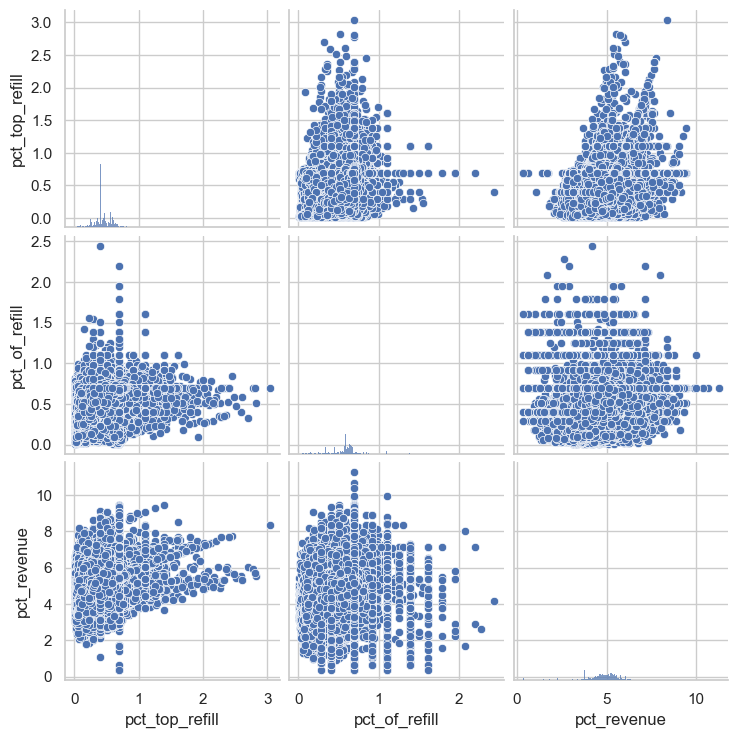

In [ ]:
log_eda_df = np.log(raw_df.iloc[:,1:19].copy().drop(columns =['top_pack'])+1)
vars = ['pct_top_refill','pct_of_refill','pct_revenue']
plt.figure(figsize=(15,10))
sns.pairplot(data=log_eda_df,vars=vars)
plt.show()

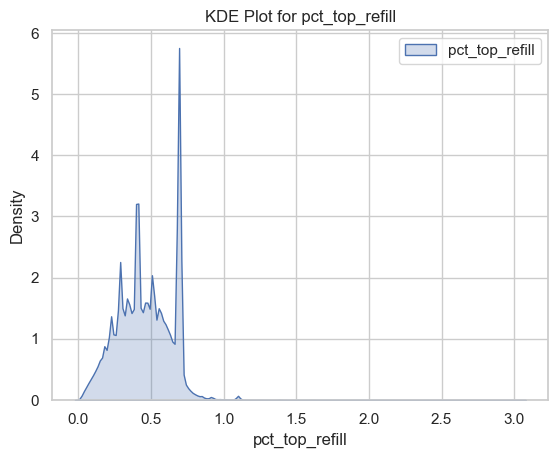

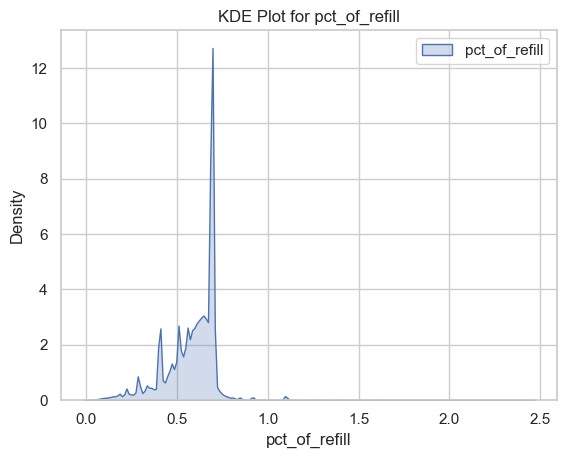

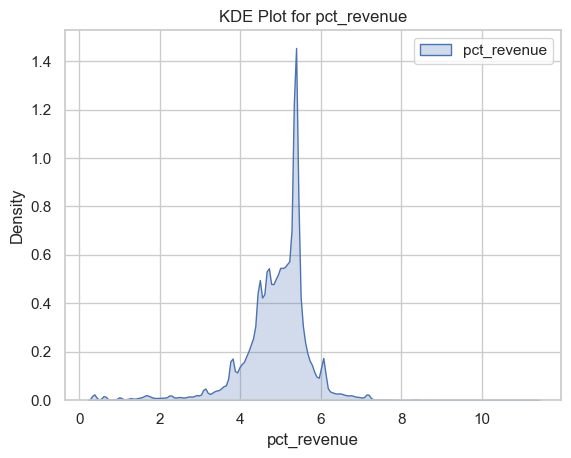

In [ ]:
for column in vars:
    sns.kdeplot(log_eda_df[column], label=column, shade=True)
    plt.title(f'KDE Plot for {column}')
    plt.legend()
    plt.show()

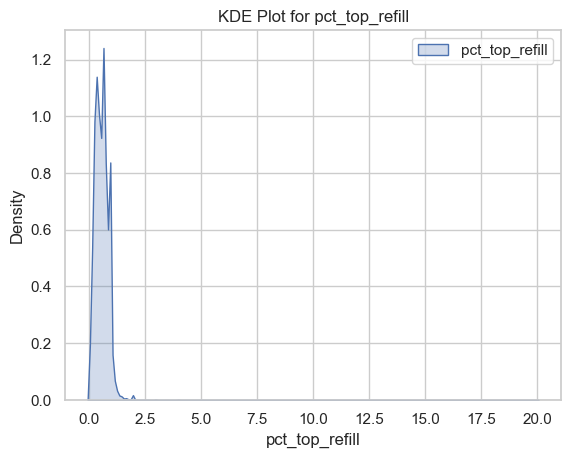

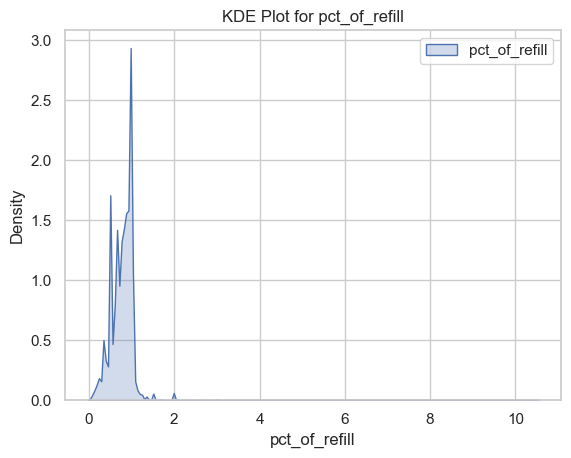

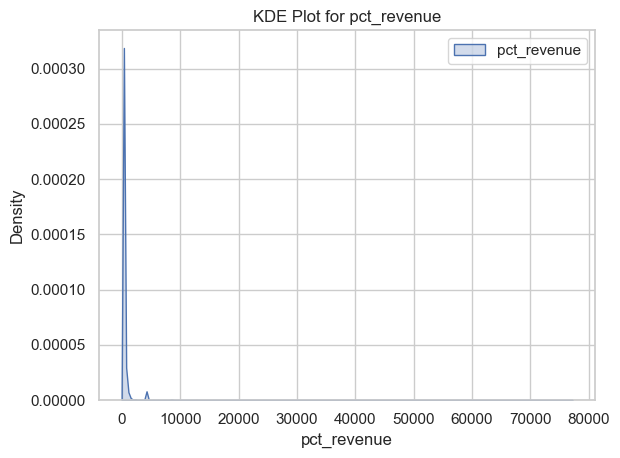

In [ ]:
for column in vars:
    sns.kdeplot(raw_df[column], label=column, shade=True)
    plt.title(f'KDE Plot for {column}')
    plt.legend()
    plt.show()

In [25]:
cluster_map = {0:'A',1:'B',2:'C',3:'D',4:'E'}
raw_df['cluster'] = raw_df['cluster'].map(cluster_map)

In [26]:
mask = raw_df['frequency'].notnull()
amount_df = raw_df[['tenure','regularity','cluster','region','frequency','Amount']]
amount_df = pd.get_dummies(amount_df[mask])
amount_df

tenure  regularity  frequency   Amount  cluster_A  cluster_B  \
ID                                                                              
ID_Z9IQ9QH52KVN      24          62       41.0  4764.96          0          0   
ID_YZSU7B7M35QS      24          61       22.0  5769.23          0          0   
ID_8IYIC9PFU8U1      24          62       60.0  5341.88          0          0   
ID_MJFIYBIBY0JO      24          44        2.0    42.74          0          0   
ID_BY33YU074XLI      24          59       13.0  2564.10          1          0   
...                 ...         ...        ...      ...        ...        ...   
ID_O3XU4THPJKOT      24          55       15.0  3098.29          0          0   
ID_MGZSA4ICBD9O      24          54       20.0  4273.50          0          0   
ID_XGDT520DFBLP      24          59       41.0  6901.71          0          0   
ID_9RDB792PB5Q4      24          43        1.0      NaN          1          0   
ID_KDTJHH8L8Z13      24          61       13.0  2307.69          0          0   

                 cluster_C  cluster_D  cluster_E  region_Astral  ...  \
ID                                                               ...   
ID_Z9IQ9QH52KVN          0          1          0              0  ...   
ID_YZSU7B7M35QS          1          0          0              0  ...   
ID_8IYIC9PFU8U1          0          1          0              0  ...   
ID_MJFIYBIBY0JO          1          0          0              0  ...   
ID_BY33YU074XLI          0          0          0              0  ...   
...                    ...        ...        ...            ...  ...   
ID_O3XU4THPJKOT          0          1          0              0  ...   
ID_MGZSA4ICBD9O          1          0          0              0  ...   
ID_XGDT520DFBLP          0          1          0              0  ...   
ID_9RDB792PB5Q4          0          0          0              0  ...   
ID_KDTJHH8L8Z13          1          0          0              0  ...   

                 region_Eternum  region_Forcehaven  region_Luminous  \
ID                                                                    
ID_Z9IQ9QH52KVN               0                  0                0   
ID_YZSU7B7M35QS               0                  0                0   
ID_8IYIC9PFU8U1               0                  0                0   
ID_MJFIYBIBY0JO               0                  0                0   
ID_BY33YU074XLI               0                  0                0   
...                         ...                ...              ...   
ID_O3XU4THPJKOT               0                  0                1   
ID_MGZSA4ICBD9O               0                  0                0   
ID_XGDT520DFBLP               0                  0                0   
ID_9RDB792PB5Q4               0                  0                0   
ID_KDTJHH8L8Z13               0                  0                1   

                 region_Mandalore  region_Nebula  region_Nebulith  \
ID                                                                  
ID_Z9IQ9QH52KVN                 0              1                0   
ID_YZSU7B7M35QS                 0              0                0   
ID_8IYIC9PFU8U1                 0              0                0   
ID_MJFIYBIBY0JO                 0              0                0   
ID_BY33YU074XLI                 0              0                0   
...                           ...            ...              ...   
ID_O3XU4THPJKOT                 0              0                0   
ID_MGZSA4ICBD9O                 0              0                0   
ID_XGDT520DFBLP                 0              0                0   
ID_9RDB792PB5Q4                 1              0                0   
ID_KDTJHH8L8Z13                 0              0                0   

                 region_Quasar  region_Radiantara  region_Stellaris  \
ID                                                                    
ID_Z9IQ9QH52KVN              0                  0             

In [27]:
X = amount_df[amount_df['Amount'].notnull()].drop(columns='Amount')
y = amount_df[amount_df['Amount'].notnull()]['Amount']

In [28]:
X_log = np.log(X+1)
y_log = np.log(y+1)

In [29]:
model_xgb = XGBRegressor(objective='reg:squarederror', max_depth=7, learning_rate=0.1, n_estimators=200,reg_alpha = 0.1,reg_lambda = 0.1, random_state=0)
model_xgb.fit(X_log, y_log)
y_pred = model_xgb.predict(X_log)
mse = mean_squared_error(y_log,y_pred)
mape = 100 * mean_absolute_error(y_log, y_pred) / y.mean()
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Squared Error: {mse}')

Mean Absolute Percentage Error (MAPE): 0.02%
Mean Squared Error: 0.2771254037019377


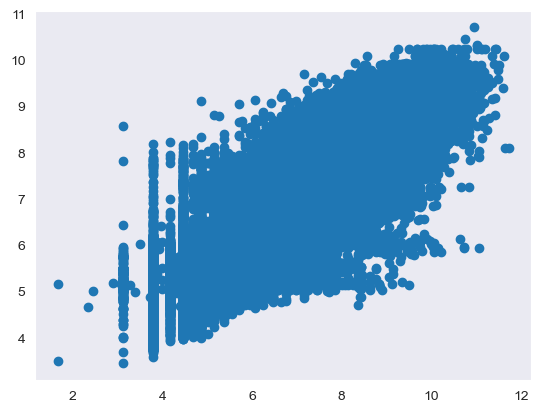

In [30]:
plt.scatter(x=y_log,y=y_pred)

In [31]:
X_fill = amount_df[amount_df['Amount'].isnull()].drop(columns='Amount')
amount_fill_log = model_xgb.predict(np.log(X_fill+1))
amount_fill = np.exp(amount_fill_log) - 1
amount_df.loc[amount_df['Amount'].isnull(), 'Amount'] = amount_fill

In [32]:
amount_df[amount_df['Amount'].isnull()]['Amount']

Series([], Name: Amount, dtype: float64)

In [33]:
amount_df

tenure  regularity  frequency       Amount  cluster_A  \
ID                                                                       
ID_Z9IQ9QH52KVN      24          62       41.0  4764.960000          0   
ID_YZSU7B7M35QS      24          61       22.0  5769.230000          0   
ID_8IYIC9PFU8U1      24          62       60.0  5341.880000          0   
ID_MJFIYBIBY0JO      24          44        2.0    42.740000          0   
ID_BY33YU074XLI      24          59       13.0  2564.100000          1   
...                 ...         ...        ...          ...        ...   
ID_O3XU4THPJKOT      24          55       15.0  3098.290000          0   
ID_MGZSA4ICBD9O      24          54       20.0  4273.500000          0   
ID_XGDT520DFBLP      24          59       41.0  6901.710000          0   
ID_9RDB792PB5Q4      24          43        1.0  1702.038574          1   
ID_KDTJHH8L8Z13      24          61       13.0  2307.690000          0   

                 cluster_B  cluster_C  cluster_D  cluster_E  region_Astral  \
ID                                                                           
ID_Z9IQ9QH52KVN          0          0          1          0              0   
ID_YZSU7B7M35QS          0          1          0          0              0   
ID_8IYIC9PFU8U1          0          0          1          0              0   
ID_MJFIYBIBY0JO          0          1          0          0              0   
ID_BY33YU074XLI          0          0          0          0              0   
...                    ...        ...        ...        ...            ...   
ID_O3XU4THPJKOT          0          0          1          0              0   
ID_MGZSA4ICBD9O          0          1          0          0              0   
ID_XGDT520DFBLP          0          0          1          0              0   
ID_9RDB792PB5Q4          0          0          0          0              0   
ID_KDTJHH8L8Z13          0          1          0          0              0   

                 ...  region_Eternum  region_Forcehaven  region_Luminous  \
ID               ...                                                       
ID_Z9IQ9QH52KVN  ...               0                  0                0   
ID_YZSU7B7M35QS  ...               0                  0                0   
ID_8IYIC9PFU8U1  ...               0                  0                0   
ID_MJFIYBIBY0JO  ...               0                  0                0   
ID_BY33YU074XLI  ...               0                  0                0   
...              ...             ...                ...              ...   
ID_O3XU4THPJKOT  ...               0                  0                1   
ID_MGZSA4ICBD9O  ...               0                  0                0   
ID_XGDT520DFBLP  ...               0                  0                0   
ID_9RDB792PB5Q4  ...               0                  0                0   
ID_KDTJHH8L8Z13  ...               0                  0                1   

                 region_Mandalore  region_Nebula  region_Nebulith  \
ID                                                                  
ID_Z9IQ9QH52KVN                 0              1                0   
ID_YZSU7B7M35QS                 0              0                0   
ID_8IYIC9PFU8U1                 0              0                0   
ID_MJFIYBIBY0JO                 0              0                0   
ID_BY33YU074XLI                 0              0                0   
...                           ...            ...              ...   
ID_O3XU4THPJKOT                 0              0                0   
ID_MGZSA4ICBD9O                 0              0                0   
ID_XGDT520DFBLP                 0              0                0   
ID_9RDB792PB5Q4                 1              0                0   
ID_KDTJHH8L8Z13                 0              0                0   

                 region_Quasar  region_Radiantara  region_Stellaris  \
ID                                                                    
ID_Z9IQ9QH

In [34]:
raw_df.loc[(raw_df['frequency'].notnull()) & (raw_df['Amount'].isnull()), 'Amount'] = amount_fill
raw_df

region  tenure       Amount  refill_frequency  revenue  \
ID                                                                           
ID_YEB05X4KUGPQ        NaN      24          NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.960000              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.230000              22.0  5769.23   
ID_QS4F5LEX29KM        NaN      24          NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.880000              58.0  5636.75   
...                    ...     ...          ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.500000              19.0  4487.18   
ID_XGDT520DFBLP        NaN      24  6901.710000              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24  1702.038574               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.690000               9.0  2264.53   
ID_2F6Y446GS8T3        NaN      24          NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  \
ID                                                                         
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0   
...                       ...        ...          ...     ...        ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN   

                 Procuct_2  regularity                        top_pack  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN           3                             NaN   
ID_Z9IQ9QH52KVN        NaN          62  On net 200F=Unlimited _call24H   
ID_YZSU7B7M35QS        1.0          61                             NaN   
ID_QS4F5LEX29KM        NaN           6                             NaN   
ID_8IYIC9PFU8U1        0.0          62     Mixt 250F=Unlimited_call24H   
...                    ...         ...                             ...   
ID_MGZSA4ICBD9O       80.0          54           All-net 500F=2000F;5d   
ID_XGDT520DFBLP        5.0          59           Data: 200 F=100MB,24H   
ID_9RDB792PB5Q4        NaN          43                             NaN   
ID_KDTJHH8L8Z13       19.0          61                Data:490F=1GB,7d   
ID_2F6Y446GS8T3        NaN           1                             NaN   

                 freq_top_pack  Target cluster  pct_top_refill  pct_of_refill  \
ID                                                                              
ID_YEB05X4KUGPQ            NaN       0       E             NaN            NaN   
ID_Z9IQ9QH52KVN           31.0       0       D        0.756098       1.000000   
ID_YZSU7B7M35QS            NaN       0       C             NaN       1.000000   
ID_QS4F5LEX29KM            NaN       0       B             NaN            NaN   
ID_8IYIC9PFU8U1           31.0       0       D        0.516667       0.966667   
...                        ...     ...     ...             ...            ...   
ID_MGZSA4ICBD9O           20.0     999       C        1.000000       0.950000   
ID_XGDT520DFBLP           33.0     999       D        0.804878       1.000000   
ID_9RDB792PB5Q4            NaN     999       A             NaN            NaN   
ID_KDTJHH8L8Z13            5.0     999       C        0.384615       0.692308   
ID_2F6Y446GS8T3            NaN     999       E             NaN            NaN   


Mean Absolute Percentage Error (MAPE): 1.91%
Mean Squared Error: 0.12591861120948036


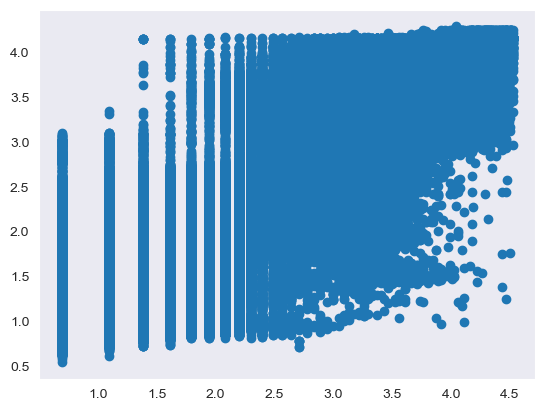

In [35]:
mask = raw_df['Amount'].notnull()
freq_df = raw_df[['tenure','regularity','cluster','region','Amount','frequency']]
freq_df = pd.get_dummies(freq_df[mask])
X = freq_df[freq_df['frequency'].notnull()].drop(columns='frequency')
y = freq_df[freq_df['frequency'].notnull()]['frequency']
X_log = np.log(X+1)
y_log = np.log(y+1)
model_xgb = XGBRegressor(objective='reg:squarederror', max_depth=7, learning_rate=0.1, n_estimators=200,reg_alpha = 0.1,reg_lambda = 0.1, random_state=0)
model_xgb.fit(X_log, y_log)
y_pred = model_xgb.predict(X_log)
mse = mean_squared_error(y_log,y_pred)
mape = 100 * mean_absolute_error(y_log, y_pred) / y.mean()
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Squared Error: {mse}')
plt.scatter(x=y_log,y=y_pred)


In [36]:
X_fill = freq_df[freq_df['frequency'].isnull()].drop(columns='frequency')
amount_fill_log = model_xgb.predict(np.log(X_fill+1))
amount_fill = np.exp(amount_fill_log) - 1
freq_df.loc[freq_df['frequency'].isnull(), 'frequency'] = amount_fill
freq_df[freq_df['frequency'].isnull()]['frequency']
freq_df


tenure  regularity       Amount  frequency  cluster_A  \
ID                                                                       
ID_Z9IQ9QH52KVN      24          62  4764.960000       41.0          0   
ID_YZSU7B7M35QS      24          61  5769.230000       22.0          0   
ID_8IYIC9PFU8U1      24          62  5341.880000       60.0          0   
ID_MJFIYBIBY0JO      24          44    42.740000        2.0          0   
ID_BY33YU074XLI      24          59  2564.100000       13.0          1   
...                 ...         ...          ...        ...        ...   
ID_O3XU4THPJKOT      24          55  3098.290000       15.0          0   
ID_MGZSA4ICBD9O      24          54  4273.500000       20.0          0   
ID_XGDT520DFBLP      24          59  6901.710000       41.0          0   
ID_9RDB792PB5Q4      24          43  1702.038574        1.0          1   
ID_KDTJHH8L8Z13      24          61  2307.690000       13.0          0   

                 cluster_B  cluster_C  cluster_D  cluster_E  region_Astral  \
ID                                                                           
ID_Z9IQ9QH52KVN          0          0          1          0              0   
ID_YZSU7B7M35QS          0          1          0          0              0   
ID_8IYIC9PFU8U1          0          0          1          0              0   
ID_MJFIYBIBY0JO          0          1          0          0              0   
ID_BY33YU074XLI          0          0          0          0              0   
...                    ...        ...        ...        ...            ...   
ID_O3XU4THPJKOT          0          0          1          0              0   
ID_MGZSA4ICBD9O          0          1          0          0              0   
ID_XGDT520DFBLP          0          0          1          0              0   
ID_9RDB792PB5Q4          0          0          0          0              0   
ID_KDTJHH8L8Z13          0          1          0          0              0   

                 ...  region_Eternum  region_Forcehaven  region_Luminous  \
ID               ...                                                       
ID_Z9IQ9QH52KVN  ...               0                  0                0   
ID_YZSU7B7M35QS  ...               0                  0                0   
ID_8IYIC9PFU8U1  ...               0                  0                0   
ID_MJFIYBIBY0JO  ...               0                  0                0   
ID_BY33YU074XLI  ...               0                  0                0   
...              ...             ...                ...              ...   
ID_O3XU4THPJKOT  ...               0                  0                1   
ID_MGZSA4ICBD9O  ...               0                  0                0   
ID_XGDT520DFBLP  ...               0                  0                0   
ID_9RDB792PB5Q4  ...               0                  0                0   
ID_KDTJHH8L8Z13  ...               0                  0                1   

                 region_Mandalore  region_Nebula  region_Nebulith  \
ID                                                                  
ID_Z9IQ9QH52KVN                 0              1                0   
ID_YZSU7B7M35QS                 0              0                0   
ID_8IYIC9PFU8U1                 0              0                0   
ID_MJFIYBIBY0JO                 0              0                0   
ID_BY33YU074XLI                 0              0                0   
...                           ...            ...              ...   
ID_O3XU4THPJKOT                 0              0                0   
ID_MGZSA4ICBD9O                 0              0                0   
ID_XGDT520DFBLP                 0              0                0   
ID_9RDB792PB5Q4                 1              0                0   
ID_KDTJHH8L8Z13                 0              0                0   

                 region_Quasar  region_Radiantara  region_Stellaris  \
ID                                                                    
ID_Z9IQ9QH

In [37]:
raw_df.loc[(raw_df['Amount'].notnull()) & (raw_df['frequency'].isnull()), 'frequency'] = amount_fill
raw_df

region  tenure       Amount  refill_frequency  revenue  \
ID                                                                           
ID_YEB05X4KUGPQ        NaN      24          NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.960000              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.230000              22.0  5769.23   
ID_QS4F5LEX29KM        NaN      24          NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.880000              58.0  5636.75   
...                    ...     ...          ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.500000              19.0  4487.18   
ID_XGDT520DFBLP        NaN      24  6901.710000              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24  1702.038574               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.690000               9.0  2264.53   
ID_2F6Y446GS8T3        NaN      24          NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  \
ID                                                                         
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0   
...                       ...        ...          ...     ...        ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN   

                 Procuct_2  regularity                        top_pack  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN           3                             NaN   
ID_Z9IQ9QH52KVN        NaN          62  On net 200F=Unlimited _call24H   
ID_YZSU7B7M35QS        1.0          61                             NaN   
ID_QS4F5LEX29KM        NaN           6                             NaN   
ID_8IYIC9PFU8U1        0.0          62     Mixt 250F=Unlimited_call24H   
...                    ...         ...                             ...   
ID_MGZSA4ICBD9O       80.0          54           All-net 500F=2000F;5d   
ID_XGDT520DFBLP        5.0          59           Data: 200 F=100MB,24H   
ID_9RDB792PB5Q4        NaN          43                             NaN   
ID_KDTJHH8L8Z13       19.0          61                Data:490F=1GB,7d   
ID_2F6Y446GS8T3        NaN           1                             NaN   

                 freq_top_pack  Target cluster  pct_top_refill  pct_of_refill  \
ID                                                                              
ID_YEB05X4KUGPQ            NaN       0       E             NaN            NaN   
ID_Z9IQ9QH52KVN           31.0       0       D        0.756098       1.000000   
ID_YZSU7B7M35QS            NaN       0       C             NaN       1.000000   
ID_QS4F5LEX29KM            NaN       0       B             NaN            NaN   
ID_8IYIC9PFU8U1           31.0       0       D        0.516667       0.966667   
...                        ...     ...     ...             ...            ...   
ID_MGZSA4ICBD9O           20.0     999       C        1.000000       0.950000   
ID_XGDT520DFBLP           33.0     999       D        0.804878       1.000000   
ID_9RDB792PB5Q4            NaN     999       A             NaN            NaN   
ID_KDTJHH8L8Z13            5.0     999       C        0.384615       0.692308   
ID_2F6Y446GS8T3            NaN     999       E             NaN            NaN   


In [38]:
raw_df.isnull().sum()

region               743819
tenure                    0
Amount               616075
refill_frequency     662569
revenue              635494
arpu_segment         635494
frequency            616075
data_volume          928846
on_net               689156
Procuct_1            783793
Procuct_2           1130051
regularity                0
top_pack             790602
freq_top_pack        790602
Target                    0
cluster                   0
pct_top_refill       790665
pct_of_refill        681988
pct_revenue          635494
dtype: int64

In [39]:
raw_df[raw_df['region'].notnull()].isnull().sum()

region                   0
tenure                   0
Amount              166150
refill_frequency    185498
revenue             172024
arpu_segment        172024
frequency           166150
data_volume         432589
on_net              206681
Procuct_1           256953
Procuct_2           516679
regularity               0
top_pack            266306
freq_top_pack       266306
Target                   0
cluster                  0
pct_top_refill      266328
pct_of_refill       191372
pct_revenue         172024
dtype: int64

In [40]:
raw_df.columns

Index(['region', 'tenure', 'Amount', 'refill_frequency', 'revenue',
       'arpu_segment', 'frequency', 'data_volume', 'on_net', 'Procuct_1',
       'Procuct_2', 'regularity', 'top_pack', 'freq_top_pack', 'Target',
       'cluster', 'pct_top_refill', 'pct_of_refill', 'pct_revenue'],
      dtype='object')

In [41]:
raw_df

region  tenure       Amount  refill_frequency  revenue  \
ID                                                                           
ID_YEB05X4KUGPQ        NaN      24          NaN               NaN      NaN   
ID_Z9IQ9QH52KVN     Nebula      24  4764.960000              41.0  4756.84   
ID_YZSU7B7M35QS  Celestial      24  5769.230000              22.0  5769.23   
ID_QS4F5LEX29KM        NaN      24          NaN               NaN      NaN   
ID_8IYIC9PFU8U1  Eclipsara      24  5341.880000              58.0  5636.75   
...                    ...     ...          ...               ...      ...   
ID_MGZSA4ICBD9O  Stellaris      24  4273.500000              19.0  4487.18   
ID_XGDT520DFBLP        NaN      24  6901.710000              41.0  7115.38   
ID_9RDB792PB5Q4  Mandalore      24  1702.038574               NaN    42.31   
ID_KDTJHH8L8Z13   Luminous      24  2307.690000               9.0  2264.53   
ID_2F6Y446GS8T3        NaN      24          NaN               NaN      NaN   

                 arpu_segment  frequency  data_volume  on_net  Procuct_1  \
ID                                                                         
ID_YEB05X4KUGPQ           NaN        NaN          NaN     NaN        NaN   
ID_Z9IQ9QH52KVN       1585.47       41.0          2.0   626.0       24.0   
ID_YZSU7B7M35QS       1923.08       22.0      28121.0     0.0        NaN   
ID_QS4F5LEX29KM           NaN        NaN          NaN     NaN        NaN   
ID_8IYIC9PFU8U1       1879.06       60.0       1131.0   546.0      376.0   
...                       ...        ...          ...     ...        ...   
ID_MGZSA4ICBD9O       1495.73       20.0          NaN    60.0      208.0   
ID_XGDT520DFBLP       2371.79       41.0       7019.0   105.0      257.0   
ID_9RDB792PB5Q4         14.10        1.0          0.0     1.0        1.0   
ID_KDTJHH8L8Z13        754.70       13.0       7381.0    15.0        NaN   
ID_2F6Y446GS8T3           NaN        NaN          NaN     NaN        NaN   

                 Procuct_2  regularity                        top_pack  \
ID                                                                       
ID_YEB05X4KUGPQ        NaN           3                             NaN   
ID_Z9IQ9QH52KVN        NaN          62  On net 200F=Unlimited _call24H   
ID_YZSU7B7M35QS        1.0          61                             NaN   
ID_QS4F5LEX29KM        NaN           6                             NaN   
ID_8IYIC9PFU8U1        0.0          62     Mixt 250F=Unlimited_call24H   
...                    ...         ...                             ...   
ID_MGZSA4ICBD9O       80.0          54           All-net 500F=2000F;5d   
ID_XGDT520DFBLP        5.0          59           Data: 200 F=100MB,24H   
ID_9RDB792PB5Q4        NaN          43                             NaN   
ID_KDTJHH8L8Z13       19.0          61                Data:490F=1GB,7d   
ID_2F6Y446GS8T3        NaN           1                             NaN   

                 freq_top_pack  Target cluster  pct_top_refill  pct_of_refill  \
ID                                                                              
ID_YEB05X4KUGPQ            NaN       0       E             NaN            NaN   
ID_Z9IQ9QH52KVN           31.0       0       D        0.756098       1.000000   
ID_YZSU7B7M35QS            NaN       0       C             NaN       1.000000   
ID_QS4F5LEX29KM            NaN       0       B             NaN            NaN   
ID_8IYIC9PFU8U1           31.0       0       D        0.516667       0.966667   
...                        ...     ...     ...             ...            ...   
ID_MGZSA4ICBD9O           20.0     999       C        1.000000       0.950000   
ID_XGDT520DFBLP           33.0     999       D        0.804878       1.000000   
ID_9RDB792PB5Q4            NaN     999       A             NaN            NaN   
ID_KDTJHH8L8Z13            5.0     999       C        0.384615       0.692308   
ID_2F6Y446GS8T3            NaN     999       E             NaN            NaN   


In [63]:
df = raw_df.drop(columns=['region','top_pack','Target']).copy()
df['region'] = raw_df['region']
features_to_fill = ['Amount', 'refill_frequency','revenue', 'arpu_segment','frequency', 'data_volume', 'on_net', 'Procuct_1','Procuct_2','freq_top_pack']

In [64]:
df

tenure       Amount  refill_frequency  revenue  arpu_segment  \
ID                                                                              
ID_YEB05X4KUGPQ      24          NaN               NaN      NaN           NaN   
ID_Z9IQ9QH52KVN      24  4764.960000              41.0  4756.84       1585.47   
ID_YZSU7B7M35QS      24  5769.230000              22.0  5769.23       1923.08   
ID_QS4F5LEX29KM      24          NaN               NaN      NaN           NaN   
ID_8IYIC9PFU8U1      24  5341.880000              58.0  5636.75       1879.06   
...                 ...          ...               ...      ...           ...   
ID_MGZSA4ICBD9O      24  4273.500000              19.0  4487.18       1495.73   
ID_XGDT520DFBLP      24  6901.710000              41.0  7115.38       2371.79   
ID_9RDB792PB5Q4      24  1702.038574               NaN    42.31         14.10   
ID_KDTJHH8L8Z13      24  2307.690000               9.0  2264.53        754.70   
ID_2F6Y446GS8T3      24          NaN               NaN      NaN           NaN   

                 frequency  data_volume  on_net  Procuct_1  Procuct_2  \
ID                                                                      
ID_YEB05X4KUGPQ        NaN          NaN     NaN        NaN        NaN   
ID_Z9IQ9QH52KVN       41.0          2.0   626.0       24.0        NaN   
ID_YZSU7B7M35QS       22.0      28121.0     0.0        NaN        1.0   
ID_QS4F5LEX29KM        NaN          NaN     NaN        NaN        NaN   
ID_8IYIC9PFU8U1       60.0       1131.0   546.0      376.0        0.0   
...                    ...          ...     ...        ...        ...   
ID_MGZSA4ICBD9O       20.0          NaN    60.0      208.0       80.0   
ID_XGDT520DFBLP       41.0       7019.0   105.0      257.0        5.0   
ID_9RDB792PB5Q4        1.0          0.0     1.0        1.0        NaN   
ID_KDTJHH8L8Z13       13.0       7381.0    15.0        NaN       19.0   
ID_2F6Y446GS8T3        NaN          NaN     NaN        NaN        NaN   

                 regularity  freq_top_pack cluster  pct_top_refill  \
ID                                                                   
ID_YEB05X4KUGPQ           3            NaN       E             NaN   
ID_Z9IQ9QH52KVN          62           31.0       D        0.756098   
ID_YZSU7B7M35QS          61            NaN       C             NaN   
ID_QS4F5LEX29KM           6            NaN       B             NaN   
ID_8IYIC9PFU8U1          62           31.0       D        0.516667   
...                     ...            ...     ...             ...   
ID_MGZSA4ICBD9O          54           20.0       C        1.000000   
ID_XGDT520DFBLP          59           33.0       D        0.804878   
ID_9RDB792PB5Q4          43            NaN       A             NaN   
ID_KDTJHH8L8Z13          61            5.0       C        0.384615   
ID_2F6Y446GS8T3           1            NaN       E             NaN   

                 pct_of_refill  pct_revenue     region  
ID                                                      
ID_YEB05X4KUGPQ            NaN          NaN        NaN  
ID_Z9IQ9QH52KVN       1.000000   116.020488     Nebula  
ID_YZSU7B7M35QS       1.000000   262.237727  Celestial  
ID_QS4F5LEX29KM            NaN          NaN        NaN  
ID_8IYIC9PFU8U1       0.966667    93.945833  Eclipsara  
...                        ...          ...        ...  
ID_MGZSA4ICBD9O       0.950000   224.359000  Stellaris  
ID_XGDT520DFBLP       1.000000   173.545854        NaN  
ID_9RDB792PB5Q4            NaN    42.310000  Mandalore  
ID_KDTJHH8L8Z13       0.692308   174.194615   Luminous  
ID_2F6Y446GS8T3            NaN          NaN        NaN  

[1887961 rows x 17 columns]

In [65]:
df = df.reset_index(drop=True)
df

tenure       Amount  refill_frequency  revenue  arpu_segment  \
0            24          NaN               NaN      NaN           NaN   
1            24  4764.960000              41.0  4756.84       1585.47   
2            24  5769.230000              22.0  5769.23       1923.08   
3            24          NaN               NaN      NaN           NaN   
4            24  5341.880000              58.0  5636.75       1879.06   
...         ...          ...               ...      ...           ...   
1887956      24  4273.500000              19.0  4487.18       1495.73   
1887957      24  6901.710000              41.0  7115.38       2371.79   
1887958      24  1702.038574               NaN    42.31         14.10   
1887959      24  2307.690000               9.0  2264.53        754.70   
1887960      24          NaN               NaN      NaN           NaN   

         frequency  data_volume  on_net  Procuct_1  Procuct_2  regularity  \
0              NaN          NaN     NaN        NaN        NaN           3   
1             41.0          2.0   626.0       24.0        NaN          62   
2             22.0      28121.0     0.0        NaN        1.0          61   
3              NaN          NaN     NaN        NaN        NaN           6   
4             60.0       1131.0   546.0      376.0        0.0          62   
...            ...          ...     ...        ...        ...         ...   
1887956       20.0          NaN    60.0      208.0       80.0          54   
1887957       41.0       7019.0   105.0      257.0        5.0          59   
1887958        1.0          0.0     1.0        1.0        NaN          43   
1887959       13.0       7381.0    15.0        NaN       19.0          61   
1887960        NaN          NaN     NaN        NaN        NaN           1   

         freq_top_pack cluster  pct_top_refill  pct_of_refill  pct_revenue  \
0                  NaN       E             NaN            NaN          NaN   
1                 31.0       D        0.756098       1.000000   116.020488   
2                  NaN       C             NaN       1.000000   262.237727   
3                  NaN       B             NaN            NaN          NaN   
4                 31.0       D        0.516667       0.966667    93.945833   
...                ...     ...             ...            ...          ...   
1887956           20.0       C        1.000000       0.950000   224.359000   
1887957           33.0       D        0.804878       1.000000   173.545854   
1887958            NaN       A             NaN            NaN    42.310000   
1887959            5.0       C        0.384615       0.692308   174.194615   
1887960            NaN       E             NaN            NaN          NaN   

            region  
0              NaN  
1           Nebula  
2        Celestial  
3              NaN  
4        Eclipsara  
...            ...  
1887956  Stellaris  
1887957        NaN  
1887958  Mandalore  
1887959   Luminous  
1887960        NaN  

[1887961 rows x 17 columns]

In [66]:
features_to_fill

['Amount',
 'refill_frequency',
 'revenue',
 'arpu_segment',
 'frequency',
 'data_volume',
 'on_net',
 'Procuct_1',
 'Procuct_2',
 'freq_top_pack']

In [67]:
df.memory_usage(deep=True)

Index                     132
tenure               15103688
Amount               15103688
refill_frequency     15103688
revenue              15103688
arpu_segment         15103688
frequency            15103688
data_volume          15103688
on_net               15103688
Procuct_1            15103688
Procuct_2            15103688
regularity           15103688
freq_top_pack        15103688
cluster             109501738
pct_top_refill       15103688
pct_of_refill        15103688
pct_revenue          15103688
region               98808456
dtype: int64

In [68]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

In [69]:
df = pd.get_dummies(df, drop_first=True)

In [70]:
df.isnull().sum()

tenure                     0
Amount                616075
refill_frequency      662569
revenue               635494
arpu_segment          635494
frequency             616075
data_volume           928846
on_net                689156
Procuct_1             783793
Procuct_2            1130051
regularity                 0
freq_top_pack         790602
pct_top_refill        790665
pct_of_refill         681988
pct_revenue           635494
cluster_B                  0
cluster_C                  0
cluster_D                  0
cluster_E                  0
region_Celestial           0
region_Droidika            0
region_Eclipsara           0
region_Eternum             0
region_Forcehaven          0
region_Luminous            0
region_Mandalore           0
region_Nebula              0
region_Nebulith            0
region_Quasar              0
region_Radiantara          0
region_Stellaris           0
region_Zodiacalia          0
dtype: int64

In [71]:
for feature in features_to_fill:
    # Step 1: Extract a table to train the XGB model
    train_data = np.log(df[df[feature].notnull()]+1)
    X_train = train_data.drop(columns=[feature])
    y_train = train_data[feature]

    # Step 2: Train the XGBoost model
    model_xgb = XGBRegressor(objective='reg:squarederror', max_depth=7, learning_rate=0.1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1, random_state=0)
    model_xgb.fit(X_train, y_train)
    print('model trained')
    # Step 3: Extract a table to update the original data
    impute_data = np.log(df[df[feature].isnull()]+1)
    X_impute = impute_data.drop(columns=[feature])
    
    # Step 4: Impute missing values
    imputed_values = np.exp(model_xgb.predict(X_impute)) - 1

    # Step 5: Update the original data with imputed values
    df.loc[df[feature].isnull(), feature] = imputed_values[:sum(df[feature].isnull())]
    


model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained


In [72]:
df.isnull().sum()

tenure                    0
Amount                    0
refill_frequency          0
revenue                   0
arpu_segment              0
frequency                 0
data_volume               0
on_net                    0
Procuct_1                 0
Procuct_2                 0
regularity                0
freq_top_pack             0
pct_top_refill       790665
pct_of_refill        681988
pct_revenue          635494
cluster_B                 0
cluster_C                 0
cluster_D                 0
cluster_E                 0
region_Celestial          0
region_Droidika           0
region_Eclipsara          0
region_Eternum            0
region_Forcehaven         0
region_Luminous           0
region_Mandalore          0
region_Nebula             0
region_Nebulith           0
region_Quasar             0
region_Radiantara         0
region_Stellaris          0
region_Zodiacalia         0
dtype: int64

In [73]:
df['pct_top_refill'] = df['freq_top_pack']/df['frequency']
df['pct_of_refill'] = df['refill_frequency']/df['frequency']
df['pct_revenue'] = df['revenue']/df['frequency']
df = df.iloc[:,0:15]


In [74]:
df.index = raw_df.index
df

tenure       Amount  refill_frequency        revenue  \
ID                                                                      
ID_YEB05X4KUGPQ      24   599.998474         44.664513  136932.718750   
ID_Z9IQ9QH52KVN      24  4764.960000         41.000000    4756.840000   
ID_YZSU7B7M35QS      24  5769.230000         22.000000    5769.230000   
ID_QS4F5LEX29KM      24   176.783722         39.507954  136199.484375   
ID_8IYIC9PFU8U1      24  5341.880000         58.000000    5636.750000   
...                 ...          ...               ...            ...   
ID_MGZSA4ICBD9O      24  4273.500000         19.000000    4487.180000   
ID_XGDT520DFBLP      24  6901.710000         41.000000    7115.380000   
ID_9RDB792PB5Q4      24  1702.038574          1.432940      42.310000   
ID_KDTJHH8L8Z13      24  2307.690000          9.000000    2264.530000   
ID_2F6Y446GS8T3      24   574.959717         42.138290  136932.718750   

                 arpu_segment  frequency   data_volume      on_net  \
ID                                                                   
ID_YEB05X4KUGPQ  57697.367188  47.254963    293.933075    1.555526   
ID_Z9IQ9QH52KVN   1585.470000  41.000000      2.000000  626.000000   
ID_YZSU7B7M35QS   1923.080000  22.000000  28121.000000    0.000000   
ID_QS4F5LEX29KM  55805.335938  41.238922    221.357040    1.530284   
ID_8IYIC9PFU8U1   1879.060000  60.000000   1131.000000  546.000000   
...                       ...        ...           ...         ...   
ID_MGZSA4ICBD9O   1495.730000  20.000000      1.489634   60.000000   
ID_XGDT520DFBLP   2371.790000  41.000000   7019.000000  105.000000   
ID_9RDB792PB5Q4     14.100000   1.000000      0.000000    1.000000   
ID_KDTJHH8L8Z13    754.700000  13.000000   7381.000000   15.000000   
ID_2F6Y446GS8T3  57717.339844  59.322701    291.771881    1.612311   

                  Procuct_1  Procuct_2  regularity  freq_top_pack  \
ID                                                                  
ID_YEB05X4KUGPQ    2.071044   1.079161           3       0.984065   
ID_Z9IQ9QH52KVN   24.000000   6.433506          62      31.000000   
ID_YZSU7B7M35QS    9.944307   1.000000          61       5.318420   
ID_QS4F5LEX29KM    7.256878   2.985912           6       1.143136   
ID_8IYIC9PFU8U1  376.000000   0.000000          62      31.000000   
...                     ...        ...         ...            ...   
ID_MGZSA4ICBD9O  208.000000  80.000000          54      20.000000   
ID_XGDT520DFBLP  257.000000   5.000000          59      33.000000   
ID_9RDB792PB5Q4    1.000000   0.888619          43       1.028045   
ID_KDTJHH8L8Z13   10.431211  19.000000          61       5.000000   
ID_2F6Y446GS8T3    2.899877   1.758302           1       0.988371   

                 pct_top_refill  pct_of_refill  pct_revenue  
ID                                                           
ID_YEB05X4KUGPQ        0.020825       0.945181  2897.742592  
ID_Z9IQ9QH52KVN        0.756098       1.000000   116.020488  
ID_YZSU7B7M35QS        0.241746       1.000000   262.237727  
ID_QS4F5LEX29KM        0.027720       0.958026  3302.692635  
ID_8IYIC9PFU8U1        0.516667       0.966667    93.945833  
...                         ...            ...          ...  
ID_MGZSA4ICBD9O        1.000000       0.950000   224.359000  
ID_XGDT520DFBLP        0.804878       1.000000   173.545854  
ID_9RDB792PB5Q4        1.028045       1.432940    42.310000  
ID_KDTJHH8L8Z13        0.384615       0.692308   174.194615  
ID_2F6Y446GS8T3        0.016661       0.710323  2308.268464  

[1887961 rows x 15 columns]

In [75]:
df['region'] = raw_df['region']
df['cluster'] = raw_df['cluster']
df

tenure       Amount  refill_frequency        revenue  \
ID                                                                      
ID_YEB05X4KUGPQ      24   599.998474         44.664513  136932.718750   
ID_Z9IQ9QH52KVN      24  4764.960000         41.000000    4756.840000   
ID_YZSU7B7M35QS      24  5769.230000         22.000000    5769.230000   
ID_QS4F5LEX29KM      24   176.783722         39.507954  136199.484375   
ID_8IYIC9PFU8U1      24  5341.880000         58.000000    5636.750000   
...                 ...          ...               ...            ...   
ID_MGZSA4ICBD9O      24  4273.500000         19.000000    4487.180000   
ID_XGDT520DFBLP      24  6901.710000         41.000000    7115.380000   
ID_9RDB792PB5Q4      24  1702.038574          1.432940      42.310000   
ID_KDTJHH8L8Z13      24  2307.690000          9.000000    2264.530000   
ID_2F6Y446GS8T3      24   574.959717         42.138290  136932.718750   

                 arpu_segment  frequency   data_volume      on_net  \
ID                                                                   
ID_YEB05X4KUGPQ  57697.367188  47.254963    293.933075    1.555526   
ID_Z9IQ9QH52KVN   1585.470000  41.000000      2.000000  626.000000   
ID_YZSU7B7M35QS   1923.080000  22.000000  28121.000000    0.000000   
ID_QS4F5LEX29KM  55805.335938  41.238922    221.357040    1.530284   
ID_8IYIC9PFU8U1   1879.060000  60.000000   1131.000000  546.000000   
...                       ...        ...           ...         ...   
ID_MGZSA4ICBD9O   1495.730000  20.000000      1.489634   60.000000   
ID_XGDT520DFBLP   2371.790000  41.000000   7019.000000  105.000000   
ID_9RDB792PB5Q4     14.100000   1.000000      0.000000    1.000000   
ID_KDTJHH8L8Z13    754.700000  13.000000   7381.000000   15.000000   
ID_2F6Y446GS8T3  57717.339844  59.322701    291.771881    1.612311   

                  Procuct_1  Procuct_2  regularity  freq_top_pack  \
ID                                                                  
ID_YEB05X4KUGPQ    2.071044   1.079161           3       0.984065   
ID_Z9IQ9QH52KVN   24.000000   6.433506          62      31.000000   
ID_YZSU7B7M35QS    9.944307   1.000000          61       5.318420   
ID_QS4F5LEX29KM    7.256878   2.985912           6       1.143136   
ID_8IYIC9PFU8U1  376.000000   0.000000          62      31.000000   
...                     ...        ...         ...            ...   
ID_MGZSA4ICBD9O  208.000000  80.000000          54      20.000000   
ID_XGDT520DFBLP  257.000000   5.000000          59      33.000000   
ID_9RDB792PB5Q4    1.000000   0.888619          43       1.028045   
ID_KDTJHH8L8Z13   10.431211  19.000000          61       5.000000   
ID_2F6Y446GS8T3    2.899877   1.758302           1       0.988371   

                 pct_top_refill  pct_of_refill  pct_revenue     region cluster  
ID                                                                              
ID_YEB05X4KUGPQ        0.020825       0.945181  2897.742592        NaN       E  
ID_Z9IQ9QH52KVN        0.756098       1.000000   116.020488     Nebula       D  
ID_YZSU7B7M35QS        0.241746       1.000000   262.237727  Celestial       C  
ID_QS4F5LEX29KM        0.027720       0.958026  3302.692635        NaN       B  
ID_8IYIC9PFU8U1        0.516667       0.966667    93.945833  Eclipsara       D  
...                         ...            ...          ...        ...     ...  
ID_MGZSA4ICBD9O        1.000000       0.950000   224.359000  Stellaris       C  
ID_XGDT520DFBLP        0.804878       1.000000   173.545854        NaN       D  
ID_9RDB792PB5Q4        1.028045       1.432940    42.310000  Mandalore       A  
ID_KDTJHH8L8Z13        0.384615       0.692308   174.194615   Luminous       C  
ID_2F6Y446GS8T3        0.016661       0.710323  2308.268464        NaN       E  

[1887961 rows x 17 columns]

In [77]:
df['Target'] = raw_df['Target']
df

tenure       Amount  refill_frequency        revenue  \
ID                                                                      
ID_YEB05X4KUGPQ      24   599.998474         44.664513  136932.718750   
ID_Z9IQ9QH52KVN      24  4764.960000         41.000000    4756.840000   
ID_YZSU7B7M35QS      24  5769.230000         22.000000    5769.230000   
ID_QS4F5LEX29KM      24   176.783722         39.507954  136199.484375   
ID_8IYIC9PFU8U1      24  5341.880000         58.000000    5636.750000   
...                 ...          ...               ...            ...   
ID_MGZSA4ICBD9O      24  4273.500000         19.000000    4487.180000   
ID_XGDT520DFBLP      24  6901.710000         41.000000    7115.380000   
ID_9RDB792PB5Q4      24  1702.038574          1.432940      42.310000   
ID_KDTJHH8L8Z13      24  2307.690000          9.000000    2264.530000   
ID_2F6Y446GS8T3      24   574.959717         42.138290  136932.718750   

                 arpu_segment  frequency   data_volume      on_net  \
ID                                                                   
ID_YEB05X4KUGPQ  57697.367188  47.254963    293.933075    1.555526   
ID_Z9IQ9QH52KVN   1585.470000  41.000000      2.000000  626.000000   
ID_YZSU7B7M35QS   1923.080000  22.000000  28121.000000    0.000000   
ID_QS4F5LEX29KM  55805.335938  41.238922    221.357040    1.530284   
ID_8IYIC9PFU8U1   1879.060000  60.000000   1131.000000  546.000000   
...                       ...        ...           ...         ...   
ID_MGZSA4ICBD9O   1495.730000  20.000000      1.489634   60.000000   
ID_XGDT520DFBLP   2371.790000  41.000000   7019.000000  105.000000   
ID_9RDB792PB5Q4     14.100000   1.000000      0.000000    1.000000   
ID_KDTJHH8L8Z13    754.700000  13.000000   7381.000000   15.000000   
ID_2F6Y446GS8T3  57717.339844  59.322701    291.771881    1.612311   

                  Procuct_1  Procuct_2  regularity  freq_top_pack  \
ID                                                                  
ID_YEB05X4KUGPQ    2.071044   1.079161           3       0.984065   
ID_Z9IQ9QH52KVN   24.000000   6.433506          62      31.000000   
ID_YZSU7B7M35QS    9.944307   1.000000          61       5.318420   
ID_QS4F5LEX29KM    7.256878   2.985912           6       1.143136   
ID_8IYIC9PFU8U1  376.000000   0.000000          62      31.000000   
...                     ...        ...         ...            ...   
ID_MGZSA4ICBD9O  208.000000  80.000000          54      20.000000   
ID_XGDT520DFBLP  257.000000   5.000000          59      33.000000   
ID_9RDB792PB5Q4    1.000000   0.888619          43       1.028045   
ID_KDTJHH8L8Z13   10.431211  19.000000          61       5.000000   
ID_2F6Y446GS8T3    2.899877   1.758302           1       0.988371   

                 pct_top_refill  pct_of_refill  pct_revenue     region  \
ID                                                                       
ID_YEB05X4KUGPQ        0.020825       0.945181  2897.742592        NaN   
ID_Z9IQ9QH52KVN        0.756098       1.000000   116.020488     Nebula   
ID_YZSU7B7M35QS        0.241746       1.000000   262.237727  Celestial   
ID_QS4F5LEX29KM        0.027720       0.958026  3302.692635        NaN   
ID_8IYIC9PFU8U1        0.516667       0.966667    93.945833  Eclipsara   
...                         ...            ...          ...        ...   
ID_MGZSA4ICBD9O        1.000000       0.950000   224.359000  Stellaris   
ID_XGDT520DFBLP        0.804878       1.000000   173.545854        NaN   
ID_9RDB792PB5Q4        1.028045       1.432940    42.310000  Mandalore   
ID_KDTJHH8L8Z13        0.384615       0.692308   174.194615   Luminous   
ID_2F6Y446GS8T3        0.016661       0.710323  2308.268464        NaN   

                cluster  Target  
ID                               
ID_YEB05X4KUGPQ       E       0  
ID_Z9IQ9QH52KVN       D       0  
ID_YZSU7B7M35QS       C       0  
ID_QS4F5LEX29KM       B       0  
ID_8IYIC9PFU8U1       D       0  
...                 ...     ...  
ID_MGZSA4ICBD9O       C

In [62]:
df.cluster.value_counts()

A    496134
C    448734
E    361940
B    346789
D    234364
Name: cluster, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


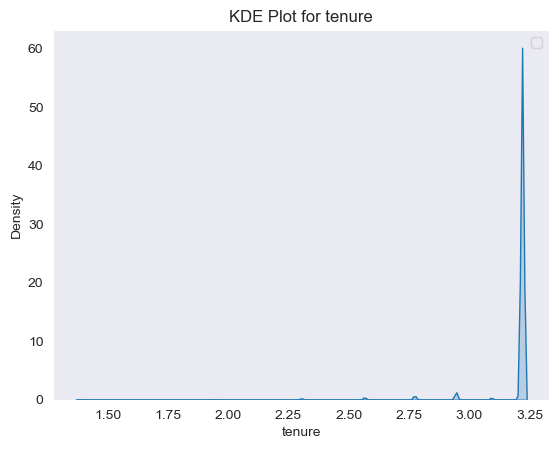

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


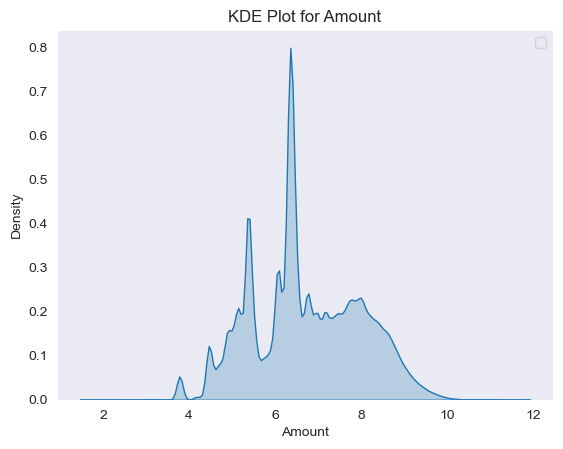

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


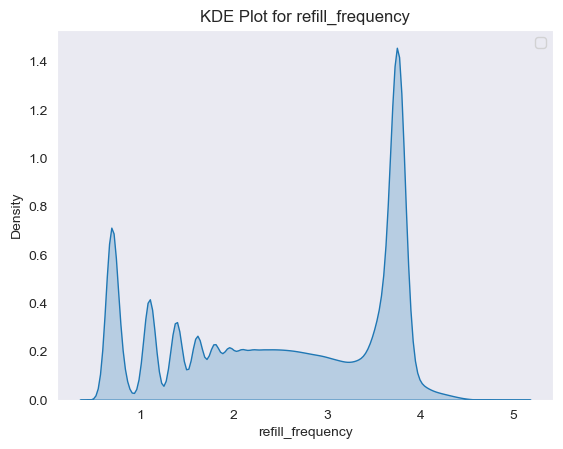

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


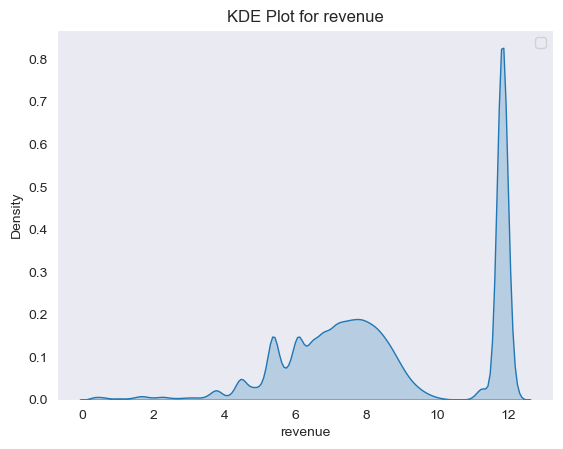

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


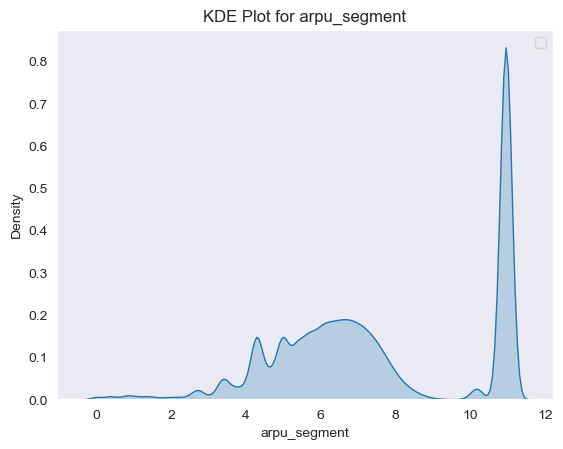

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


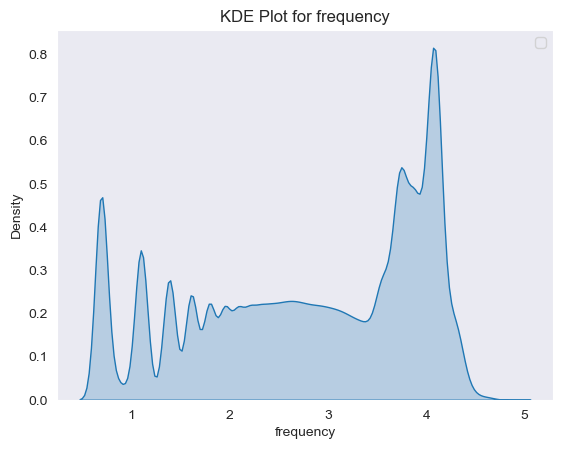

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


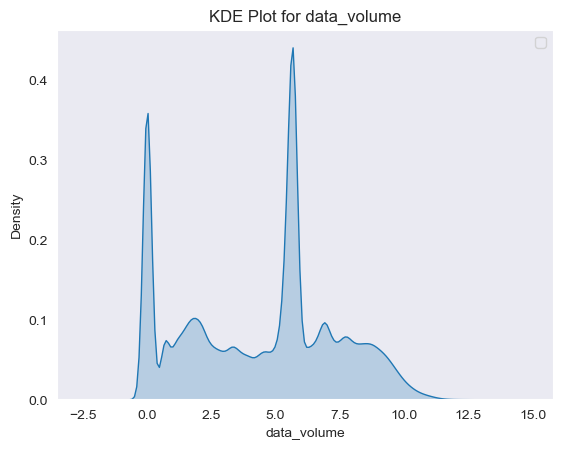

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


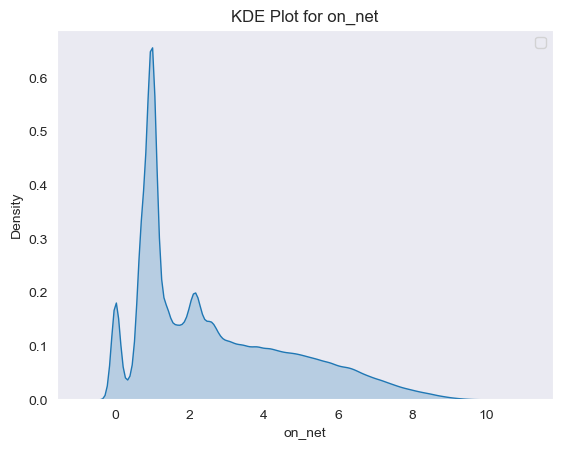

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


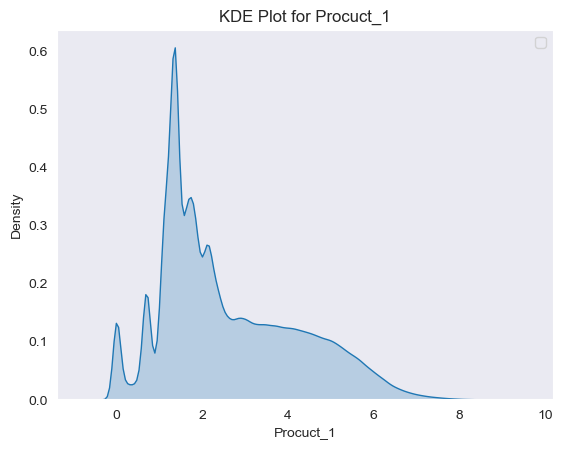

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


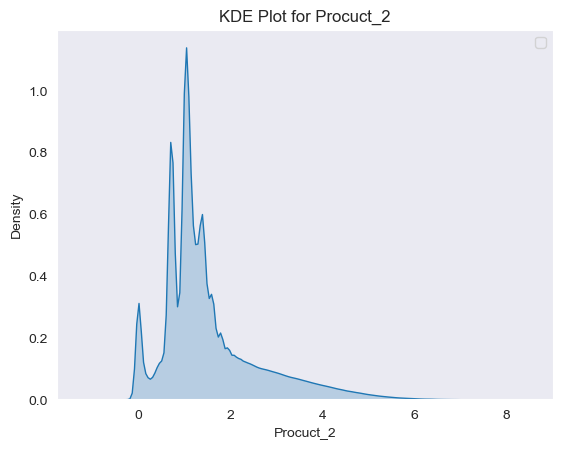

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


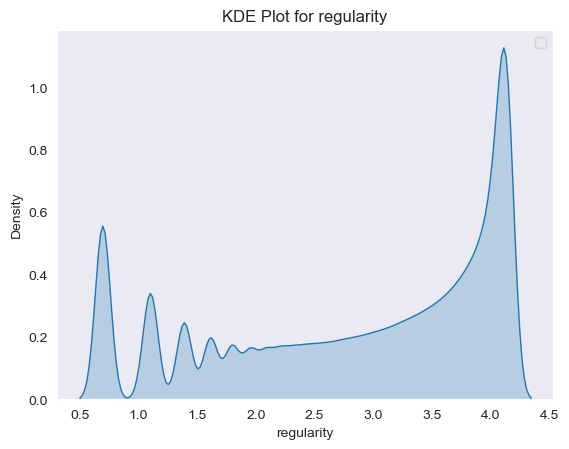

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


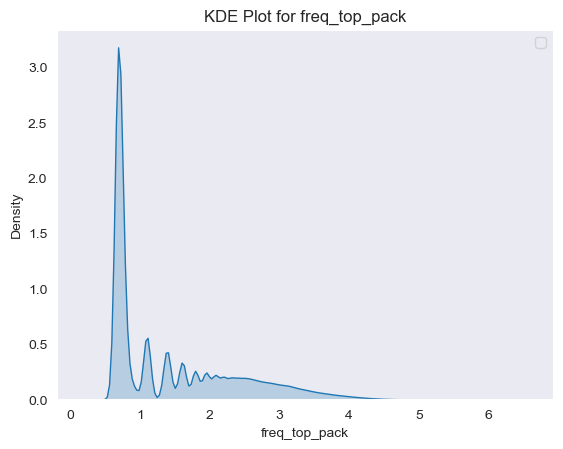

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


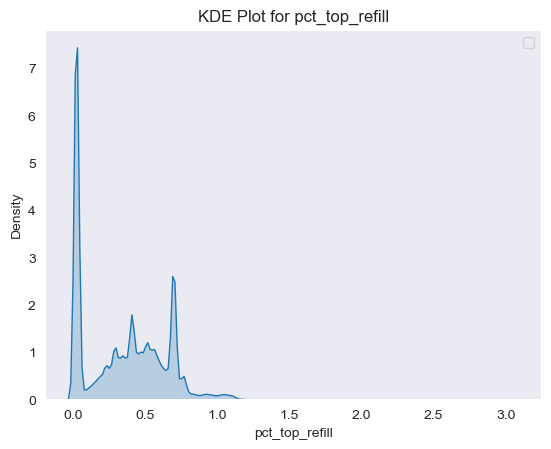

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


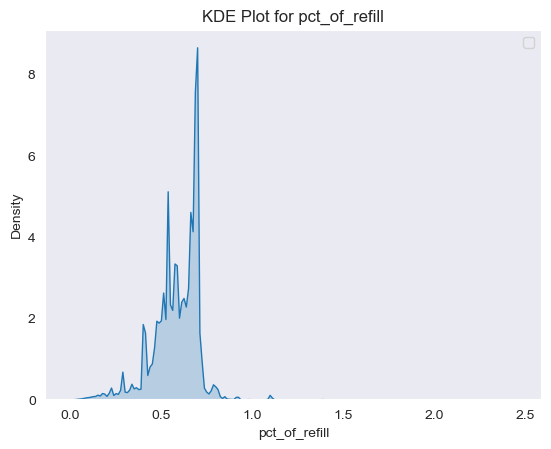

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


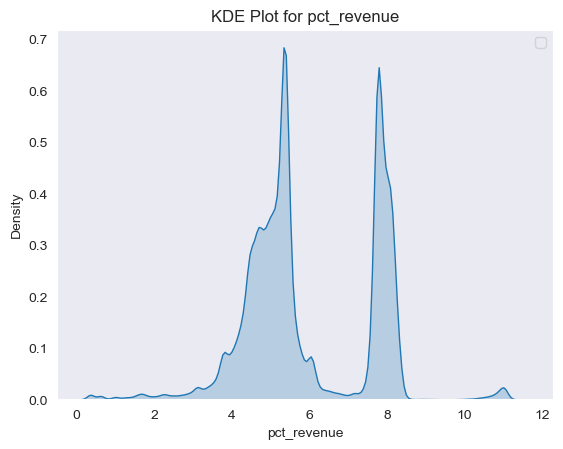

In [76]:
log_eda_df = np.log(df.iloc[:,0:15].copy()+1)
for column in log_eda_df.columns:
    sns.kdeplot(data=log_eda_df, x=log_eda_df[column], shade=True)
    plt.title(f'KDE Plot for {column}')
    plt.legend()
    plt.show()

In [80]:
df

tenure       Amount  refill_frequency        revenue  \
ID                                                                      
ID_YEB05X4KUGPQ      24   599.998474         44.664513  136932.718750   
ID_Z9IQ9QH52KVN      24  4764.960000         41.000000    4756.840000   
ID_YZSU7B7M35QS      24  5769.230000         22.000000    5769.230000   
ID_QS4F5LEX29KM      24   176.783722         39.507954  136199.484375   
ID_8IYIC9PFU8U1      24  5341.880000         58.000000    5636.750000   
...                 ...          ...               ...            ...   
ID_MGZSA4ICBD9O      24  4273.500000         19.000000    4487.180000   
ID_XGDT520DFBLP      24  6901.710000         41.000000    7115.380000   
ID_9RDB792PB5Q4      24  1702.038574          1.432940      42.310000   
ID_KDTJHH8L8Z13      24  2307.690000          9.000000    2264.530000   
ID_2F6Y446GS8T3      24   574.959717         42.138290  136932.718750   

                 arpu_segment  frequency   data_volume      on_net  \
ID                                                                   
ID_YEB05X4KUGPQ  57697.367188  47.254963    293.933075    1.555526   
ID_Z9IQ9QH52KVN   1585.470000  41.000000      2.000000  626.000000   
ID_YZSU7B7M35QS   1923.080000  22.000000  28121.000000    0.000000   
ID_QS4F5LEX29KM  55805.335938  41.238922    221.357040    1.530284   
ID_8IYIC9PFU8U1   1879.060000  60.000000   1131.000000  546.000000   
...                       ...        ...           ...         ...   
ID_MGZSA4ICBD9O   1495.730000  20.000000      1.489634   60.000000   
ID_XGDT520DFBLP   2371.790000  41.000000   7019.000000  105.000000   
ID_9RDB792PB5Q4     14.100000   1.000000      0.000000    1.000000   
ID_KDTJHH8L8Z13    754.700000  13.000000   7381.000000   15.000000   
ID_2F6Y446GS8T3  57717.339844  59.322701    291.771881    1.612311   

                  Procuct_1  Procuct_2  regularity  freq_top_pack  \
ID                                                                  
ID_YEB05X4KUGPQ    2.071044   1.079161           3       0.984065   
ID_Z9IQ9QH52KVN   24.000000   6.433506          62      31.000000   
ID_YZSU7B7M35QS    9.944307   1.000000          61       5.318420   
ID_QS4F5LEX29KM    7.256878   2.985912           6       1.143136   
ID_8IYIC9PFU8U1  376.000000   0.000000          62      31.000000   
...                     ...        ...         ...            ...   
ID_MGZSA4ICBD9O  208.000000  80.000000          54      20.000000   
ID_XGDT520DFBLP  257.000000   5.000000          59      33.000000   
ID_9RDB792PB5Q4    1.000000   0.888619          43       1.028045   
ID_KDTJHH8L8Z13   10.431211  19.000000          61       5.000000   
ID_2F6Y446GS8T3    2.899877   1.758302           1       0.988371   

                 pct_top_refill  pct_of_refill  pct_revenue     region  \
ID                                                                       
ID_YEB05X4KUGPQ        0.020825       0.945181  2897.742592        NaN   
ID_Z9IQ9QH52KVN        0.756098       1.000000   116.020488     Nebula   
ID_YZSU7B7M35QS        0.241746       1.000000   262.237727  Celestial   
ID_QS4F5LEX29KM        0.027720       0.958026  3302.692635        NaN   
ID_8IYIC9PFU8U1        0.516667       0.966667    93.945833  Eclipsara   
...                         ...            ...          ...        ...   
ID_MGZSA4ICBD9O        1.000000       0.950000   224.359000  Stellaris   
ID_XGDT520DFBLP        0.804878       1.000000   173.545854        NaN   
ID_9RDB792PB5Q4        1.028045       1.432940    42.310000  Mandalore   
ID_KDTJHH8L8Z13        0.384615       0.692308   174.194615   Luminous   
ID_2F6Y446GS8T3        0.016661       0.710323  2308.268464        NaN   

                cluster  Target  
ID                               
ID_YEB05X4KUGPQ       E       0  
ID_Z9IQ9QH52KVN       D       0  
ID_YZSU7B7M35QS       C       0  
ID_QS4F5LEX29KM       B       0  
ID_8IYIC9PFU8U1       D       0  
...                 ...     ...  
ID_MGZSA4ICBD9O       C

In [83]:
label_encoder = LabelEncoder()
df['region_encoded'] = label_encoder.fit_transform(df['region'])

# Step 2: Split the data into training and testing sets
train_data = df[df['region'].notnull()]
X_train = pd.get_dummies(train_data.drop(columns=['region', 'region_encoded']))
X_train = np.log(X_train+1)
y_train = train_data['region_encoded']

X_test = pd.get_dummies(df[df['region'].isnull()].drop(columns=['region', 'region_encoded']))
X_test = np.log(X_test+1)

# Step 3: Train an XGBoost classifier
model_xgb = XGBClassifier(objective='multi:softmax', num_class=len(df['region'].unique()), random_state=0)
model_xgb.fit(X_train, y_train)

# Step 4: Predict the missing 'region' values
predicted_regions = model_xgb.predict(X_test)

# Step 5: Inverse transform to get original labels
predicted_regions_original = label_encoder.inverse_transform(predicted_regions)

# Step 6: Fill the missing 'region' values in the original DataFrame
df.loc[df['region'].isnull(), 'region'] = predicted_regions_original
df

tenure       Amount  refill_frequency        revenue  \
ID                                                                      
ID_YEB05X4KUGPQ      24   599.998474         44.664513  136932.718750   
ID_Z9IQ9QH52KVN      24  4764.960000         41.000000    4756.840000   
ID_YZSU7B7M35QS      24  5769.230000         22.000000    5769.230000   
ID_QS4F5LEX29KM      24   176.783722         39.507954  136199.484375   
ID_8IYIC9PFU8U1      24  5341.880000         58.000000    5636.750000   
...                 ...          ...               ...            ...   
ID_MGZSA4ICBD9O      24  4273.500000         19.000000    4487.180000   
ID_XGDT520DFBLP      24  6901.710000         41.000000    7115.380000   
ID_9RDB792PB5Q4      24  1702.038574          1.432940      42.310000   
ID_KDTJHH8L8Z13      24  2307.690000          9.000000    2264.530000   
ID_2F6Y446GS8T3      24   574.959717         42.138290  136932.718750   

                 arpu_segment  frequency   data_volume      on_net  \
ID                                                                   
ID_YEB05X4KUGPQ  57697.367188  47.254963    293.933075    1.555526   
ID_Z9IQ9QH52KVN   1585.470000  41.000000      2.000000  626.000000   
ID_YZSU7B7M35QS   1923.080000  22.000000  28121.000000    0.000000   
ID_QS4F5LEX29KM  55805.335938  41.238922    221.357040    1.530284   
ID_8IYIC9PFU8U1   1879.060000  60.000000   1131.000000  546.000000   
...                       ...        ...           ...         ...   
ID_MGZSA4ICBD9O   1495.730000  20.000000      1.489634   60.000000   
ID_XGDT520DFBLP   2371.790000  41.000000   7019.000000  105.000000   
ID_9RDB792PB5Q4     14.100000   1.000000      0.000000    1.000000   
ID_KDTJHH8L8Z13    754.700000  13.000000   7381.000000   15.000000   
ID_2F6Y446GS8T3  57717.339844  59.322701    291.771881    1.612311   

                  Procuct_1  Procuct_2  regularity  freq_top_pack  \
ID                                                                  
ID_YEB05X4KUGPQ    2.071044   1.079161           3       0.984065   
ID_Z9IQ9QH52KVN   24.000000   6.433506          62      31.000000   
ID_YZSU7B7M35QS    9.944307   1.000000          61       5.318420   
ID_QS4F5LEX29KM    7.256878   2.985912           6       1.143136   
ID_8IYIC9PFU8U1  376.000000   0.000000          62      31.000000   
...                     ...        ...         ...            ...   
ID_MGZSA4ICBD9O  208.000000  80.000000          54      20.000000   
ID_XGDT520DFBLP  257.000000   5.000000          59      33.000000   
ID_9RDB792PB5Q4    1.000000   0.888619          43       1.028045   
ID_KDTJHH8L8Z13   10.431211  19.000000          61       5.000000   
ID_2F6Y446GS8T3    2.899877   1.758302           1       0.988371   

                 pct_top_refill  pct_of_refill  pct_revenue     region  \
ID                                                                       
ID_YEB05X4KUGPQ        0.020825       0.945181  2897.742592     Astral   
ID_Z9IQ9QH52KVN        0.756098       1.000000   116.020488     Nebula   
ID_YZSU7B7M35QS        0.241746       1.000000   262.237727  Celestial   
ID_QS4F5LEX29KM        0.027720       0.958026  3302.692635     Astral   
ID_8IYIC9PFU8U1        0.516667       0.966667    93.945833  Eclipsara   
...                         ...            ...          ...        ...   
ID_MGZSA4ICBD9O        1.000000       0.950000   224.359000  Stellaris   
ID_XGDT520DFBLP        0.804878       1.000000   173.545854  Mandalore   
ID_9RDB792PB5Q4        1.028045       1.432940    42.310000  Mandalore   
ID_KDTJHH8L8Z13        0.384615       0.692308   174.194615   Luminous   
ID_2F6Y446GS8T3        0.016661       0.710323  2308.268464     Astral   

                cluster  Target  region_encoded  
ID                                               
ID_YEB05X4KUGPQ       E       0              14  
ID_Z9IQ9QH52KVN       D       0               8  
ID_YZSU7B7M35QS       C       0               1  
ID_QS4F5LEX29KM       B       0              

In [88]:
# Assuming df is your DataFrame
train_indices = raw_data.index
test_indices = raw_test.index

# Split the DataFrame into train and test
df_train = df[df.index.isin(train_indices)]
df_test = df[df.index.isin(test_indices)]
df_train.to_csv('Train_clean.csv')
df_test.to_csv('Test_clean.csv')

In [78]:
raw_data.index

Index(['ID_YEB05X4KUGPQ', 'ID_Z9IQ9QH52KVN', 'ID_YZSU7B7M35QS',
       'ID_QS4F5LEX29KM', 'ID_8IYIC9PFU8U1', 'ID_MJFIYBIBY0JO',
       'ID_LRE4OJMM1T2C', 'ID_BY33YU074XLI', 'ID_GV22KJO949U2',
       'ID_8EP70ZC40LKW',
       ...
       'ID_3LDL5JYMVOLQ', 'ID_HTVA7OKUK8BE', 'ID_1XD4G9II1BB8',
       'ID_0OJQIB9CZT6Z', 'ID_9GHCP2J4MPZQ', 'ID_D1MA2025F1U6',
       'ID_9H6BGU1FS1CD', 'ID_QWJPIJ065LA4', 'ID_B0S6HQUEDWJ7',
       'ID_T7DN0N7KLS2R'],
      dtype='object', name='ID', length=1507834)

In [79]:
raw_test.index

Index(['ID_LZ8K373W7EWV', 'ID_04KNWHGV5783', 'ID_CXS07G6VLB2U',
       'ID_N3NFJJVHS25K', 'ID_R36J4ROT93E9', 'ID_3O1YCY9NJSVS',
       'ID_ZC11TNQPE0JH', 'ID_AXR9LX732HEC', 'ID_1TSCOFIM2RLP',
       'ID_8IA0KI3LJZ1W',
       ...
       'ID_9GAM95FRVGE1', 'ID_FEDEZSBZ2AX3', 'ID_WXR8JDCZCYXK',
       'ID_X0ZJRWDCAOC0', 'ID_O3XU4THPJKOT', 'ID_MGZSA4ICBD9O',
       'ID_XGDT520DFBLP', 'ID_9RDB792PB5Q4', 'ID_KDTJHH8L8Z13',
       'ID_2F6Y446GS8T3'],
      dtype='object', name='ID', length=380127)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1887961 entries, ID_YEB05X4KUGPQ to ID_2F6Y446GS8T3
Data columns (total 19 columns):
 #   Column            Dtype  
---  ------            -----  
 0   tenure            int64  
 1   Amount            float64
 2   refill_frequency  float64
 3   revenue           float64
 4   arpu_segment      float64
 5   frequency         float64
 6   data_volume       float64
 7   on_net            float64
 8   Procuct_1         float64
 9   Procuct_2         float64
 10  regularity        int64  
 11  freq_top_pack     float64
 12  pct_top_refill    float64
 13  pct_of_refill     float64
 14  pct_revenue       float64
 15  region            object 
 16  cluster           object 
 17  Target            int32  
 18  region_encoded    int32  
dtypes: float64(13), int32(2), int64(2), object(2)
memory usage: 338.2+ MB


In [91]:
from sklearn.preprocessing import RobustScaler

# Assuming df is your DataFrame with numerical features
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Instantiate the RobustScaler
scaler = RobustScaler()

In [99]:
log_eda_df

tenure    Amount  refill_frequency    revenue  \
ID                                                                 
ID_YEB05X4KUGPQ  3.218876  6.398592          3.821321  11.827252   
ID_Z9IQ9QH52KVN  3.218876  8.469254          3.737670   8.467549   
ID_YZSU7B7M35QS  3.218876  8.660467          3.135494   8.660467   
ID_QS4F5LEX29KM  3.218876  5.180568          3.701498  11.821883   
ID_8IYIC9PFU8U1  3.218876  8.583520          4.077537   8.637240   
...                   ...       ...               ...        ...   
ID_MGZSA4ICBD9O  3.218876  8.360422          2.995732   8.409203   
ID_XGDT520DFBLP  3.218876  8.839669          3.737670   8.870154   
ID_9RDB792PB5Q4  3.218876  7.440169          0.889101   3.768384   
ID_KDTJHH8L8Z13  3.218876  7.744436          2.302585   7.725564   
ID_2F6Y446GS8T3  3.218876  6.356038          3.764411  11.827252   

                 arpu_segment  frequency  data_volume    on_net  Procuct_1  \
ID                                                                           
ID_YEB05X4KUGPQ     10.962984   3.876499     5.686748  0.938258   1.122018   
ID_Z9IQ9QH52KVN      7.369267   3.737670     1.098612  6.440947   3.218876   
ID_YZSU7B7M35QS      7.562203   3.135494    10.244307  0.000000   2.392819   
ID_QS4F5LEX29KM     10.929643   3.743342     5.404284  0.928332   2.111047   
ID_8IYIC9PFU8U1      7.539059   4.110874     7.031741  6.304449   5.932245   
...                       ...        ...          ...       ...        ...   
ID_MGZSA4ICBD9O      7.311038   3.044522     0.912136  4.110874   5.342334   
ID_XGDT520DFBLP      7.771822   3.737670     8.856518  4.663439   5.552960   
ID_9RDB792PB5Q4      2.714695   0.693147     0.000000  0.693147   0.693147   
ID_KDTJHH8L8Z13      6.627644   2.639057     8.906800  2.772589   2.436347   
ID_2F6Y446GS8T3     10.963330   4.099708     5.679394  0.960235   1.360945   

                 Procuct_2  regularity  freq_top_pack  pct_top_refill  \
ID                                                                      
ID_YEB05X4KUGPQ   0.731964    1.386294       0.685148        0.020611   
ID_Z9IQ9QH52KVN   2.005998    4.143135       3.465736        0.563094   
ID_YZSU7B7M35QS   0.693147    4.127134       1.843469        0.216519   
ID_QS4F5LEX29KM   1.382766    1.945910       0.762270        0.027343   
ID_8IYIC9PFU8U1   0.000000    4.143135       3.465736        0.416515   
...                    ...         ...            ...             ...   
ID_MGZSA4ICBD9O   4.394449    4.007333       3.044522        0.693147   
ID_XGDT520DFBLP   1.791759    4.094345       3.526361        0.590493   
ID_9RDB792PB5Q4   0.635846    3.784190       0.707072        0.707072   
ID_KDTJHH8L8Z13   2.995732    4.127134       1.791759        0.325422   
ID_2F6Y446GS8T3   1.014615    0.693147       0.687316        0.016524   

                 pct_of_refill  pct_revenue  
ID                                           
ID_YEB05X4KUGPQ       0.665355     7.972032  
ID_Z9IQ9QH52KVN       0.693147     4.762349  
ID_YZSU7B7M35QS       0.693147     5.573058  
ID_QS4F5LEX29KM       0.671937     8.102796  
ID_8IYIC9PFU8U1       0.676340     4.553307  
...                        ...          ...  
ID_MGZSA4ICBD9O       0.667829     5.417695  
ID_XGDT520DFBLP       0.693147     5.162187  
ID_9RDB792PB5Q4       0.889101     3.768384  
ID_KDTJHH8L8Z13       0.526093     5.165897  
ID_2F6Y446GS8T3       0.536682     7.744686  

[1887961 rows x 15 columns]

In [100]:
scaled_eda = pd.DataFrame(scaler.fit_transform(log_eda_df),columns=log_eda_df.columns)
scaled_eda

tenure    Amount  refill_frequency   revenue  arpu_segment  \
0           0.0 -0.034844          0.500716  0.733248      0.749009   
1           0.0  1.057649          0.460777  0.077208      0.074214   
2           0.0  1.158534          0.173269  0.114879      0.110442   
3           0.0 -0.677482          0.443507  0.732199      0.742748   
4           0.0  1.117936          0.623047  0.110343      0.106096   
...         ...       ...               ...       ...           ...   
1887956     0.0  1.000229          0.106540  0.065815      0.063280   
1887957     0.0  1.253082          0.460777  0.155824      0.149802   
1887958     0.0  0.514698         -0.899270 -0.840385     -0.799778   
1887959     0.0  0.675230         -0.224403 -0.067677     -0.065041   
1887960     0.0 -0.057297          0.473545  0.733248      0.749074   

         frequency  data_volume    on_net  Procuct_1  Procuct_2  regularity  \
0         0.422483     0.066478 -0.368099  -0.416131  -0.484843   -0.913854   
1         0.355890    -0.895709  1.406843   0.466116   0.896302    0.460900   
2         0.067040     1.022253 -0.670743   0.118555  -0.526924    0.452921   
3         0.358611     0.007242 -0.371301   0.000000   0.220674   -0.634790   
4         0.534907     0.348539  1.362814   1.607758  -1.278346    0.460900   
...            ...          ...       ...        ...        ...         ...   
1887956   0.023403    -0.934815  0.655257   1.359555   3.485559    0.393180   
1887957   0.355890     0.731217  0.833492   1.448175   0.664053    0.436570   
1887958  -1.104496    -1.126101 -0.447162  -0.596577  -0.589043    0.281905   
1887959  -0.171089     0.741761  0.223581   0.136869   1.969247    0.452921   
1887960   0.529551     0.064936 -0.361010  -0.315603  -0.178429   -1.259505   

         freq_top_pack  pct_top_refill  pct_of_refill  pct_revenue  
0            -0.298252       -0.601713       0.326625     0.884831  
1             1.707519        0.394391       0.479911    -0.206269  
2             0.537301       -0.241988       0.479911     0.069323  
3            -0.242619       -0.589352       0.362925     0.929283  
4             1.707519        0.125243       0.387212    -0.277331  
...                ...             ...            ...          ...  
1887956       1.403677        0.633193       0.340271     0.016509  
1887957       1.751250        0.444701       0.479911    -0.070348  
1887958      -0.282436        0.658763       1.560692    -0.544158  
1887959       0.500000       -0.042020      -0.441476    -0.069087  
1887960      -0.296688       -0.609217      -0.383071     0.807547  

[1887961 rows x 15 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


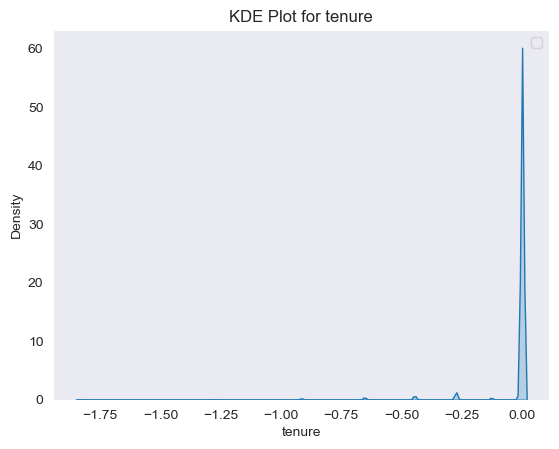

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


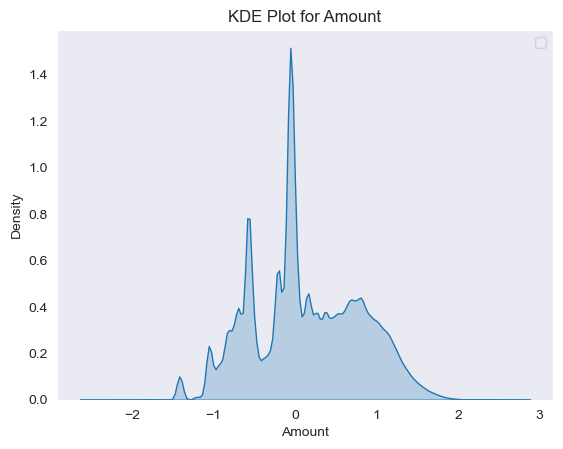

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


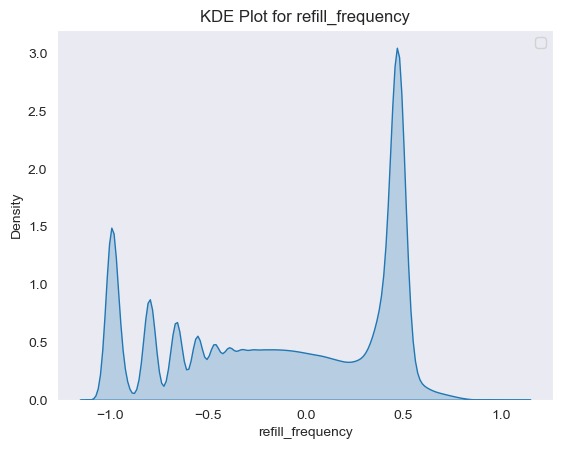

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


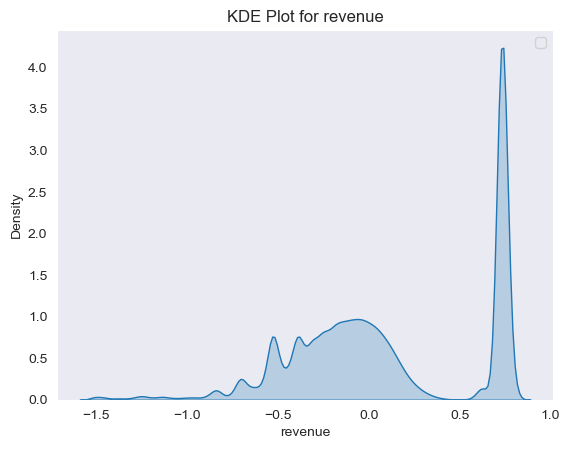

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


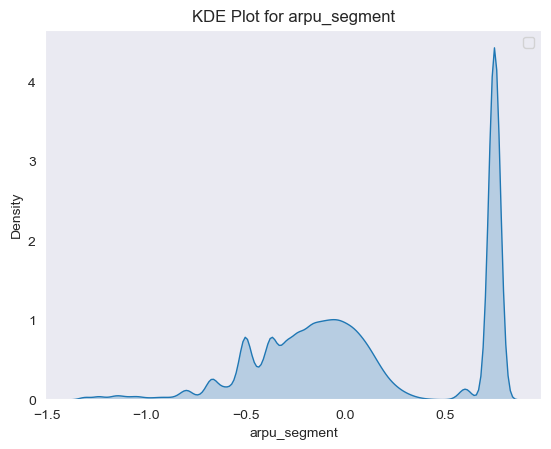

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


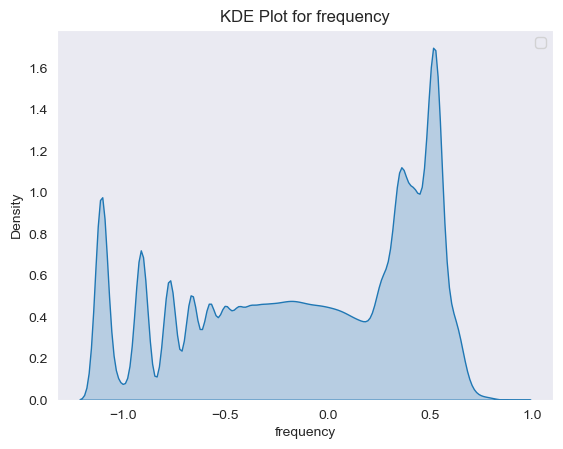

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


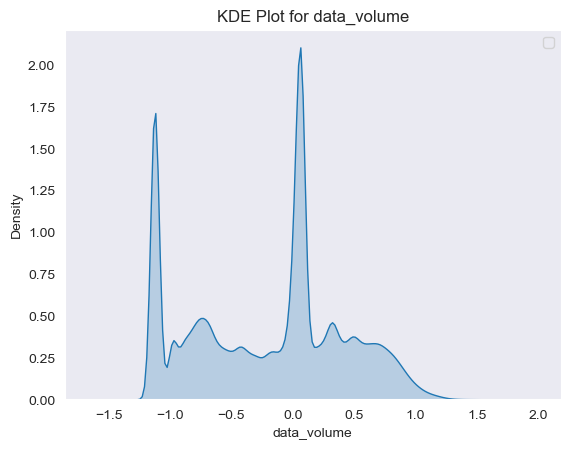

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


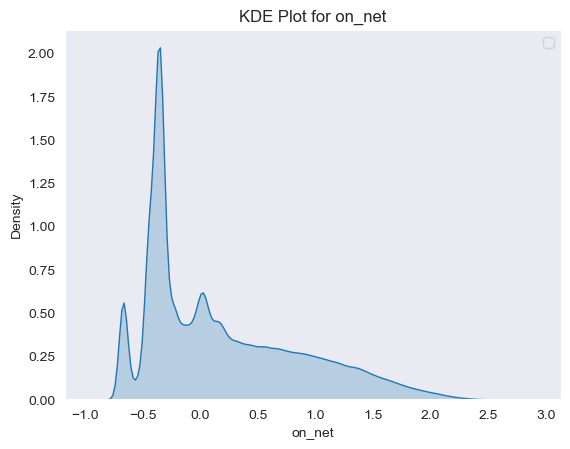

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


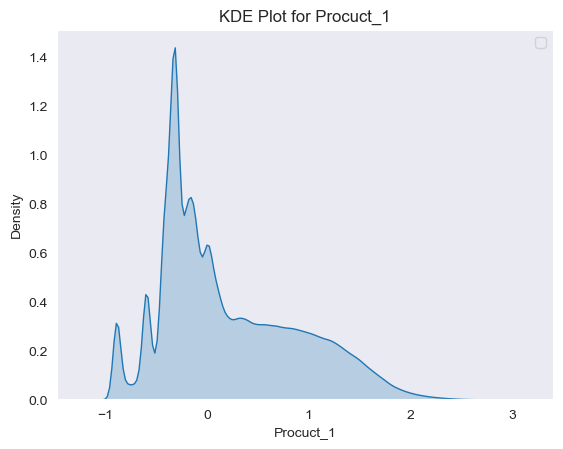

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


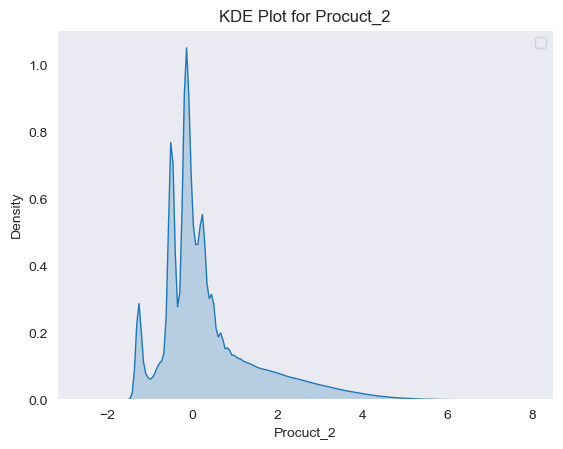

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


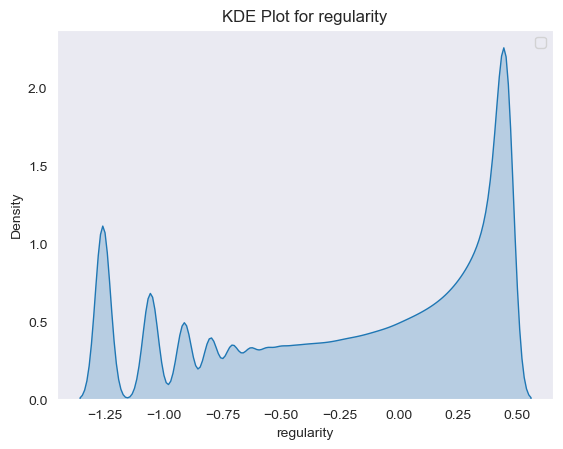

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


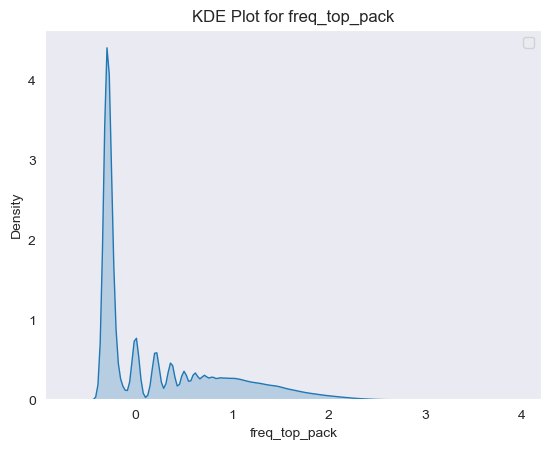

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


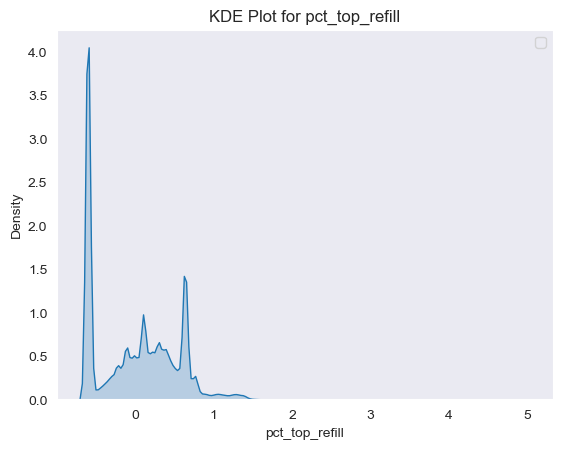

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


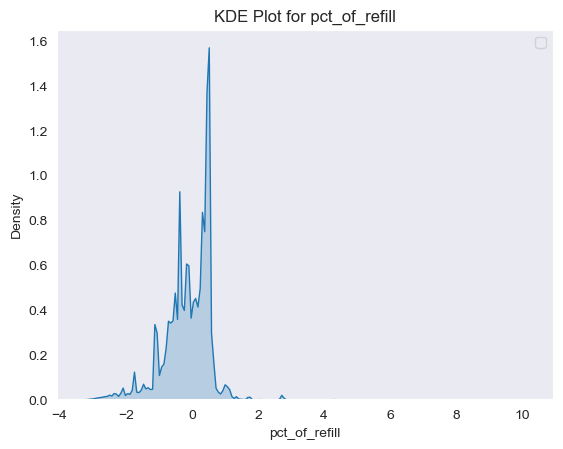

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


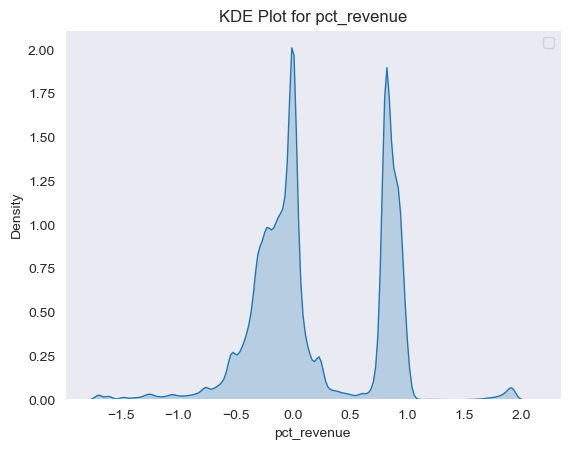

In [101]:
for column in scaled_eda.columns:
    sns.kdeplot(data=scaled_eda, x=scaled_eda[column], shade=True)
    plt.title(f'KDE Plot for {column}')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


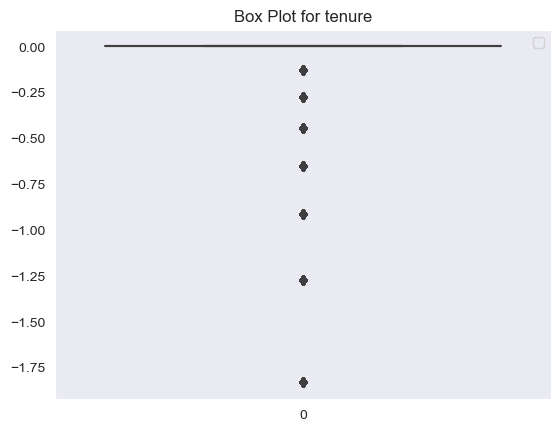

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


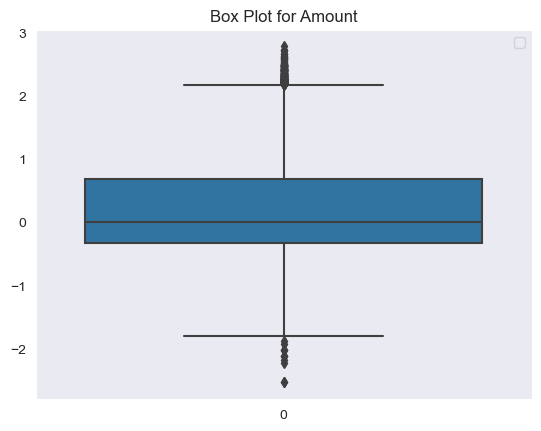

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


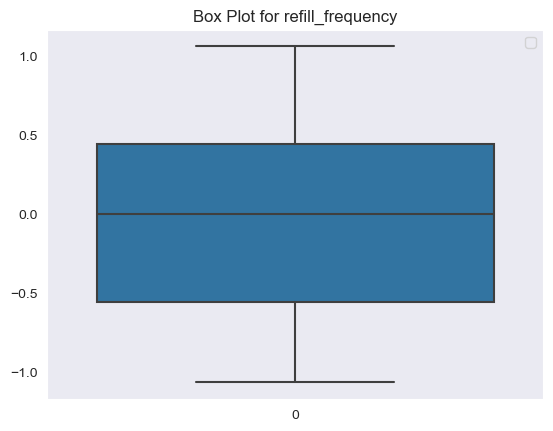

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


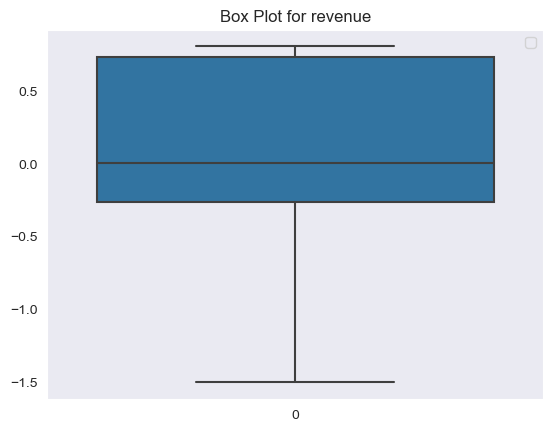

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


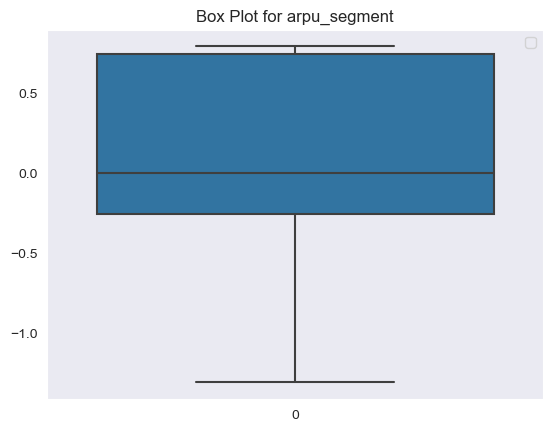

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


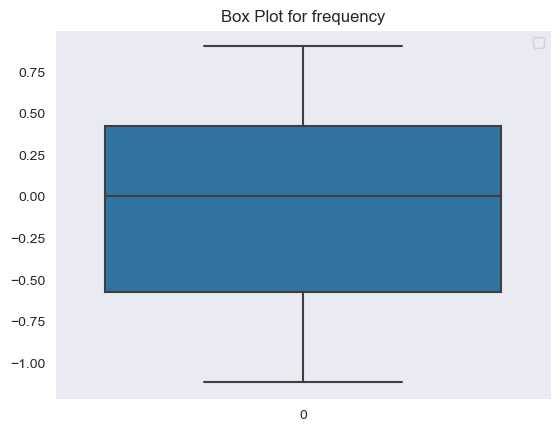

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


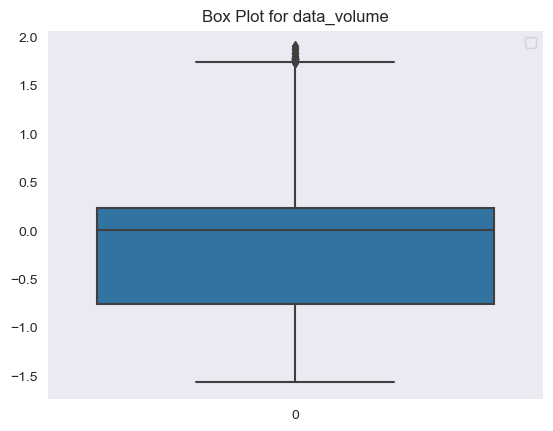

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


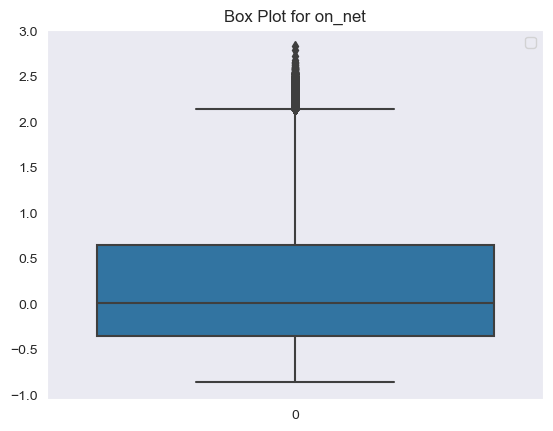

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


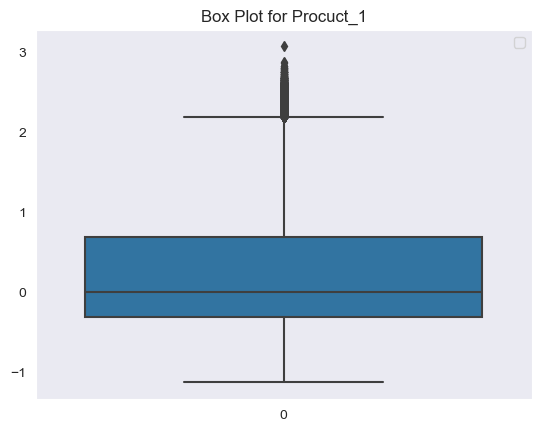

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


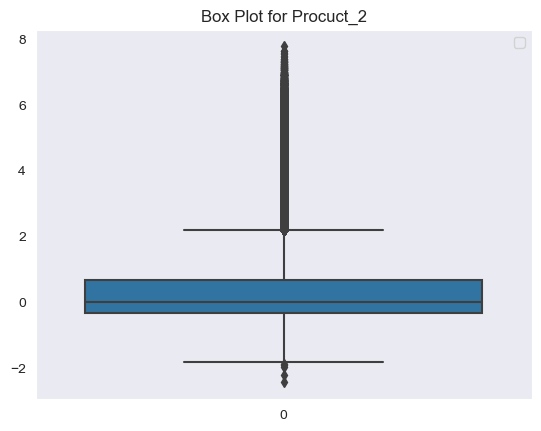

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


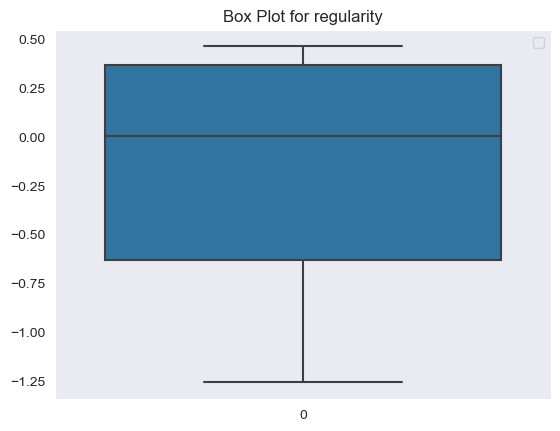

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


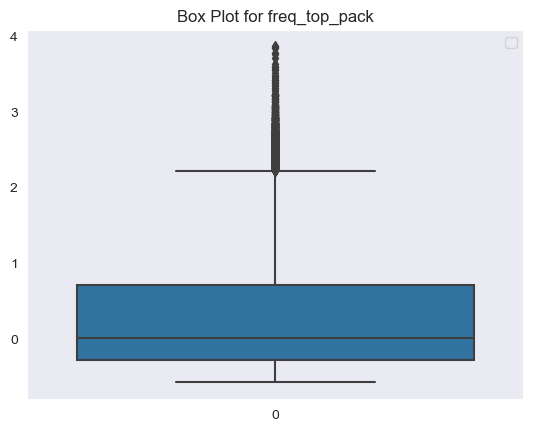

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


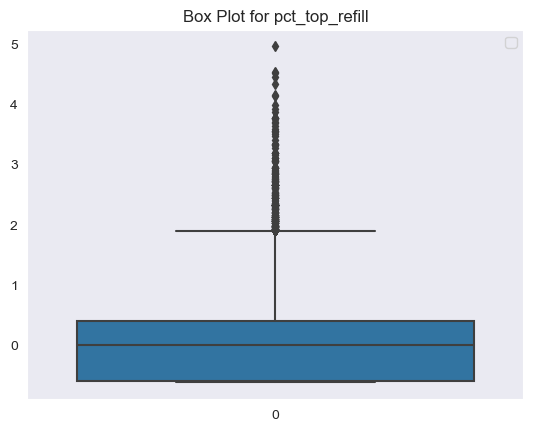

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


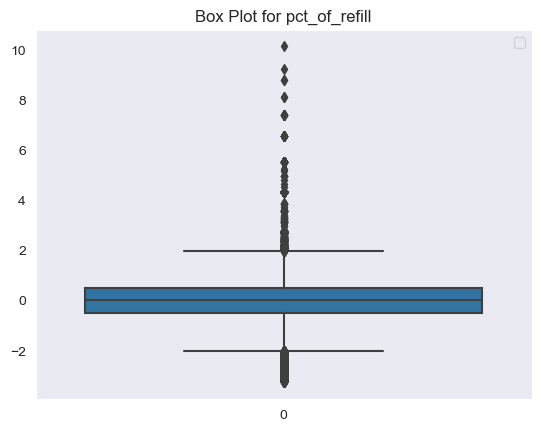

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


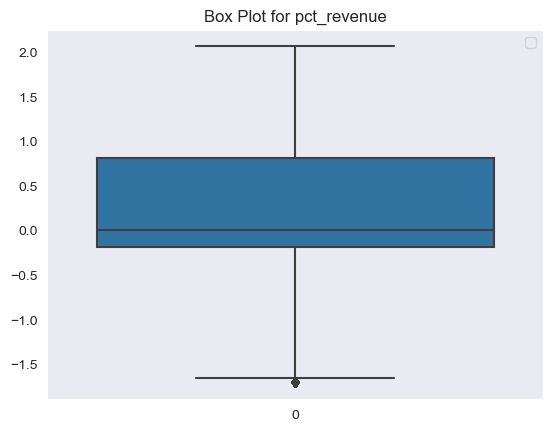

In [102]:
for column in scaled_eda.columns:
    sns.boxplot(scaled_eda[column])
    plt.title(f'Box Plot for {column}')
    plt.legend()
    plt.show()